# **BUSINESS CASE 2: SIEMENS ADVANTA SALES FORECASTING**  


## 🎓 Master’s Program in Data Science & Advanced Analytics 
**Nova IMS** | March 2025   
**Course:** Business Cases with Data Science

## 👥 Team **Group A**  
- **Alice Viegas** | 20240572  
- **Bernardo Faria** | 20240579  
- **Dinis Pinto** | 20240612  
- **Daan van Holten** | 20240681
- **Philippe Dutranoit** | 20240518

## 📊 Project Overview  
This notebook utilizes the following datasets:  
- **Case2_Sales Data.csv**:  Daily sales data per GCK (product groups) in EUR
- **Case2_Market Data.xlsx**: Important macro-economic indices for Siemens in its most important countries
- **Case2_Test Set Template.xlsx**: Template for the test set submission

The goal of this project is to forecast the sales of some selected product groups of Siemens in Germany.

## 📊 Goal of the notebook

In this notebook we process with the EDA of the data <br>

we also process with a feature selection part for each group focusing on correlation and autocorrelation to identify the relevant features and lag that may explain the target variable

 ## 1. Initial setup and modules/packages loading

In [162]:
!pip install statsmodels
!pip install openpyxl

In [1]:
# Packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm



# importing relevant 
from Functions import *

import importlib
imported_module = importlib.import_module("Functions")
importlib.reload(imported_module)

<module 'Functions' from '/Users/philippedutranoit/document_ordi/nova/business_case_for_data_sciense/cases/BC_DA_Siemens/Notebooks/Functions.py'>

In [2]:
#!pip install openpyxl

In [3]:
# Global definitions
baseFolder = os.getcwd()
exportsFolder = baseFolder + os.sep +'Exports' + os.sep

In [4]:
subPlots_Title_fontSize = 12
subPlots_xAxis_fontSize = 10
subPlots_yAxis_fontSize = 10
subPlots_label_fontSize = 10
heatmaps_text_fontSize = 8

plots_Title_fontSize = 14
plots_Title_textColour = 'black'

plots_Legend_fontSize = 12
plots_Legend_textColour = 'black'

plots_barTexts_fontSize = 8

## 2. Importing Data

In [5]:
sales_data = pd.read_csv('../Data/Case2_Sales data.csv', sep=';')
market_data = pd.read_excel('../Data/Case2_Market data.xlsx')

## 3. Data Understanding/Preparation

In [6]:
df_sales = sales_data.copy()
df_market = market_data.copy()

In [7]:
pd.set_option('display.max_columns', None)  # Displays all columns

### 3.1. Sales Data

In [8]:
df_sales.shape

(9802, 3)

In [9]:
df_sales.head()

DATE Mapped_GCK Sales_EUR
0  01.10.2018         #1         0
1  02.10.2018         #1         0
2  03.10.2018         #1         0
3  04.10.2018         #1         0
4  05.10.2018         #1         0

In [10]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9802 entries, 0 to 9801
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DATE        9802 non-null   object
 1   Mapped_GCK  9802 non-null   object
 2   Sales_EUR   9802 non-null   object
dtypes: object(3)
memory usage: 229.9+ KB


In [11]:
df_sales.describe().T

count unique         top  freq
DATE        9802   1216  16.04.2021    14
Mapped_GCK  9802     14          #1  1179
Sales_EUR   9802   2609           0  7134

In [12]:
df_sales.duplicated().sum()

np.int64(0)

We can see there are no missing values or duplicates, but the features are not in the correct formats.   
We will need to correct these before proceeding with the analysis.
Additionally, the data is daily, but we need to forecast monthly sales. We will need to aggregate the data accordingly.


In [13]:
df_sales['Sales_EUR']= df_sales['Sales_EUR'].apply(lambda x : x.replace(',', '.')).astype(float)  # Replace comma with dot and convert to float

In [14]:
df_sales['DATE'] = df_sales['DATE'].apply(lambda x : pd.to_datetime(x, format='%d.%m.%Y'))  # Convert to datetime

In [15]:
df_sales['DATE'] = df_sales['DATE'].dt.to_period('M')  # Convert to month

# Aggregating the sales on a monthly basis
df_sales = df_sales.groupby(['DATE', 'Mapped_GCK']).agg({'Sales_EUR': 'sum'}).reset_index()

In [16]:
# Remove the # from the 'Mapped_GCK' column for data cleanliness and ease of processing
# Convert 'Mapped_GCK' to integer as it is a categorical numeric identifier for Product Groups
df_sales['Mapped_GCK'] = df_sales['Mapped_GCK'].str[1:].astype(int)

In [17]:
df_sales.shape

(602, 3)

In [18]:
df_sales.head()

DATE  Mapped_GCK    Sales_EUR
0  2018-10           1  36098918.79
1  2018-10          11   1021303.50
2  2018-10          12     28686.33
3  2018-10          13     27666.10
4  2018-10          14      5770.00

In [19]:
df_sales.describe()

Mapped_GCK     Sales_EUR
count  602.000000  6.020000e+02
mean    11.285714  4.441603e+06
std      8.588083  9.743326e+06
min      1.000000 -1.520296e+04
25%      5.000000  1.376013e+04
50%     10.000000  2.911755e+05
75%     14.000000  1.591996e+06
max     36.000000  4.448301e+07

In [20]:
#check how many rows have negative values for sales
df_sales[df_sales['Sales_EUR'] < 0]

DATE  Mapped_GCK  Sales_EUR
221  2020-01           6  -15202.96
256  2020-04          14   -2851.45
363  2020-11           9   -4358.10
494  2021-09          14    -561.25

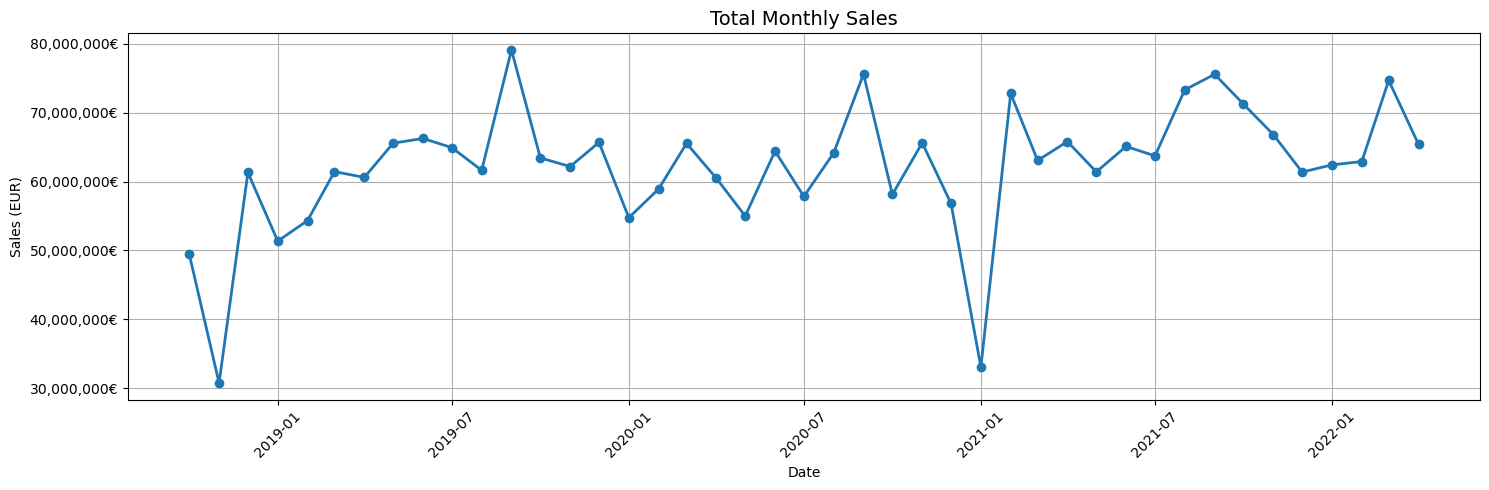

In [21]:
df_sales['DATE'] = df_sales['DATE'].dt.to_timestamp()  # Convert to timestamp for visualizations

plt.figure(figsize=(15, 5))

plt.plot(df_sales.groupby('DATE')['Sales_EUR'].sum(), marker='o', linewidth=2)
plt.title('Total Monthly Sales', fontsize=plots_Title_fontSize, color=plots_Title_textColour)
plt.xlabel('Date', fontsize=subPlots_label_fontSize)
plt.ylabel('Sales (EUR)', fontsize=subPlots_label_fontSize)

# Format y-axis to show values in millions
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}€')) 

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

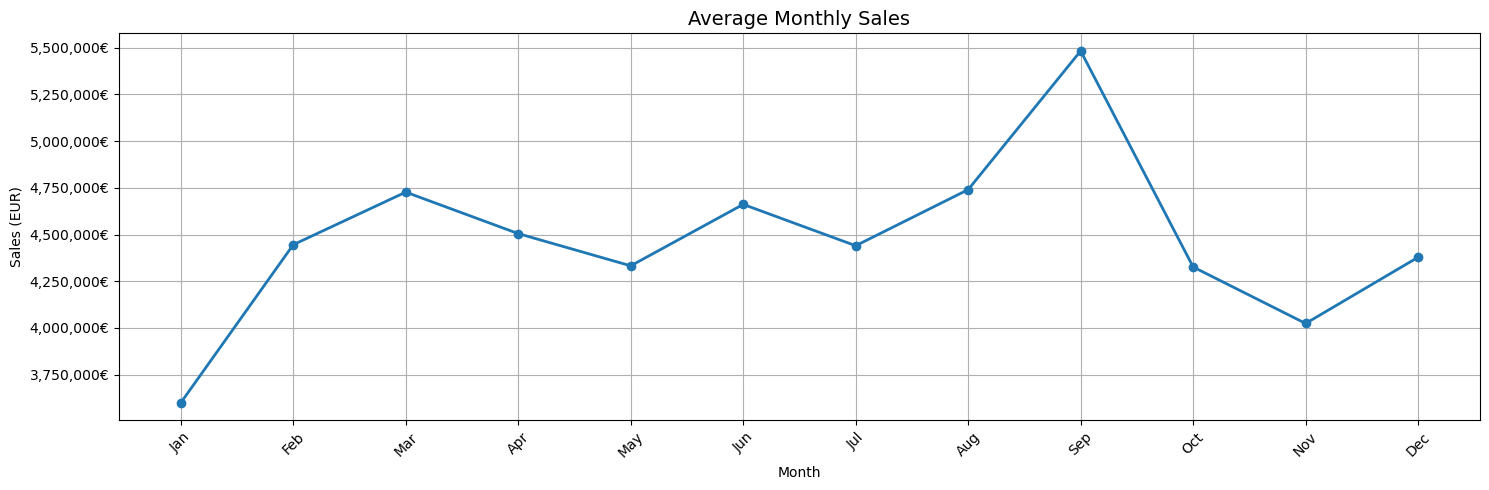

In [22]:
plt.figure(figsize=(15, 5))

plt.plot(df_sales.groupby(df_sales['DATE'].dt.month)['Sales_EUR'].mean(), marker='o', linewidth=2)
plt.title('Average Monthly Sales', fontsize=plots_Title_fontSize, color=plots_Title_textColour)
plt.xlabel('Month', fontsize=subPlots_label_fontSize)
plt.ylabel('Sales (EUR)', fontsize=subPlots_label_fontSize)

# Format y-axis to show values in millions
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}€'))

# Replace x-ticks with month names
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

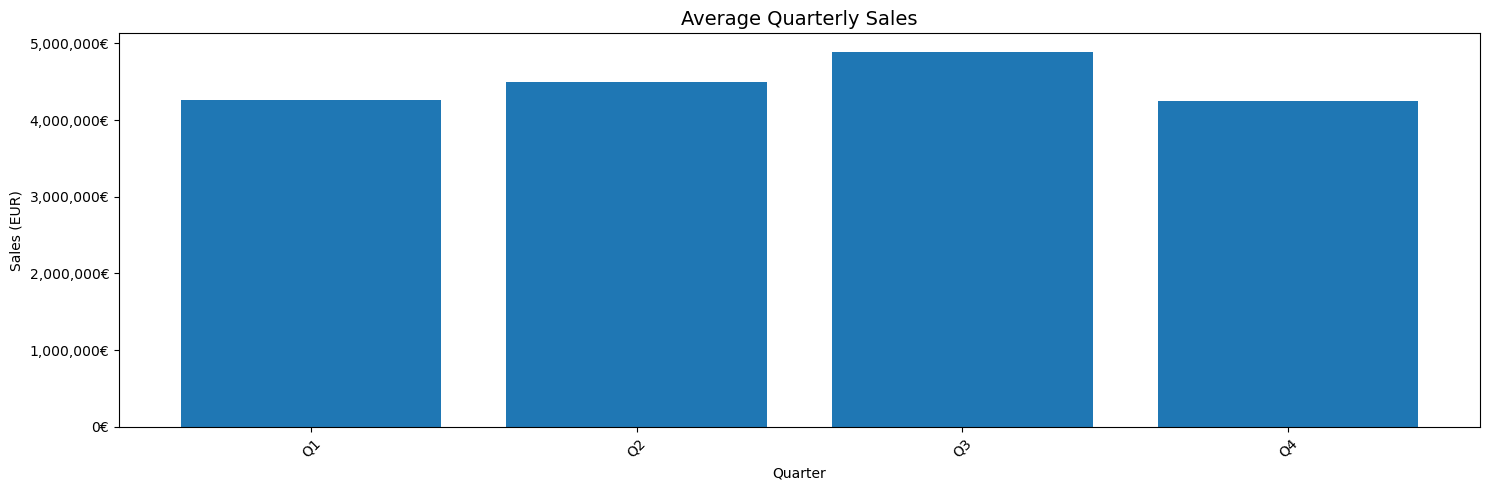

In [23]:
trimester_labels = {
    1: 'Q1', 2: 'Q1', 3: 'Q1', 
    4: 'Q2', 5: 'Q2', 6: 'Q2',
    7: 'Q3', 8: 'Q3', 9: 'Q3',
    10: 'Q4', 11: 'Q4', 12: 'Q4'
}

quarterly_sales = df_sales.groupby(df_sales['DATE'].dt.month.map(trimester_labels))['Sales_EUR'].mean().reset_index()

plt.figure(figsize=(15, 5))

plt.bar(quarterly_sales['DATE'], quarterly_sales['Sales_EUR'])
plt.title('Average Quarterly Sales', fontsize=plots_Title_fontSize, color=plots_Title_textColour)
plt.xlabel('Quarter', fontsize=subPlots_label_fontSize)
plt.ylabel('Sales (EUR)', fontsize=subPlots_label_fontSize)

# Format y-axis to show values in millions
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}€'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


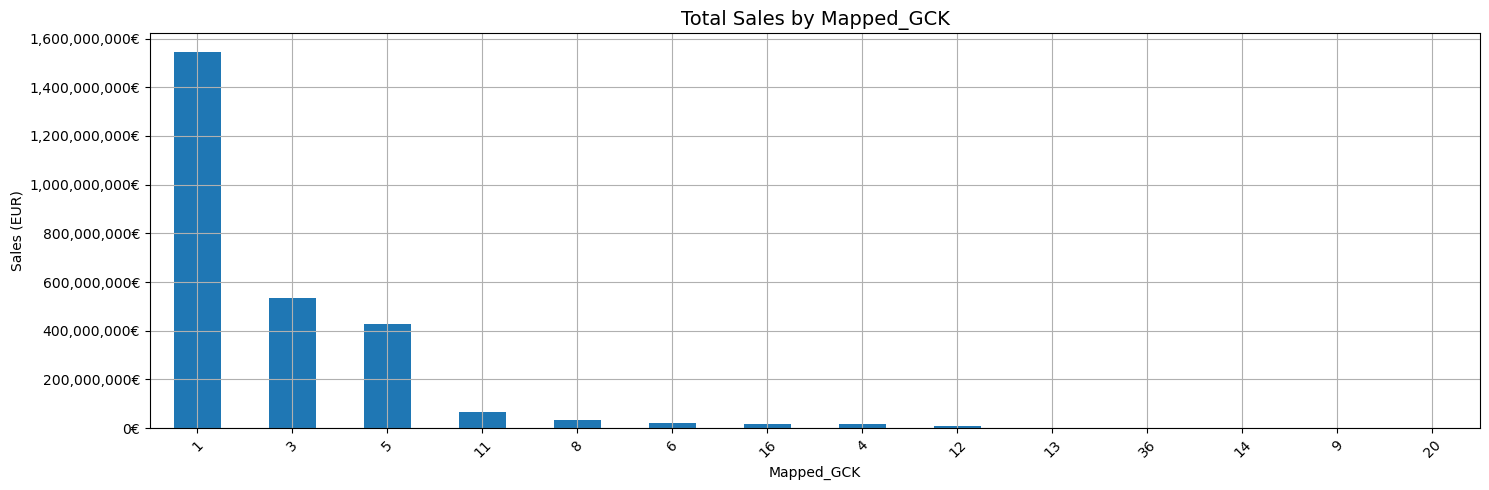

In [24]:
df_sales.groupby('Mapped_GCK')['Sales_EUR'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(15, 5))

plt.title('Total Sales by Mapped_GCK', fontsize=plots_Title_fontSize, color=plots_Title_textColour)
plt.xlabel('Mapped_GCK', fontsize=subPlots_label_fontSize)
plt.ylabel('Sales (EUR)', fontsize=subPlots_label_fontSize)

# Format y-axis to show values in millions
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}€'))

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

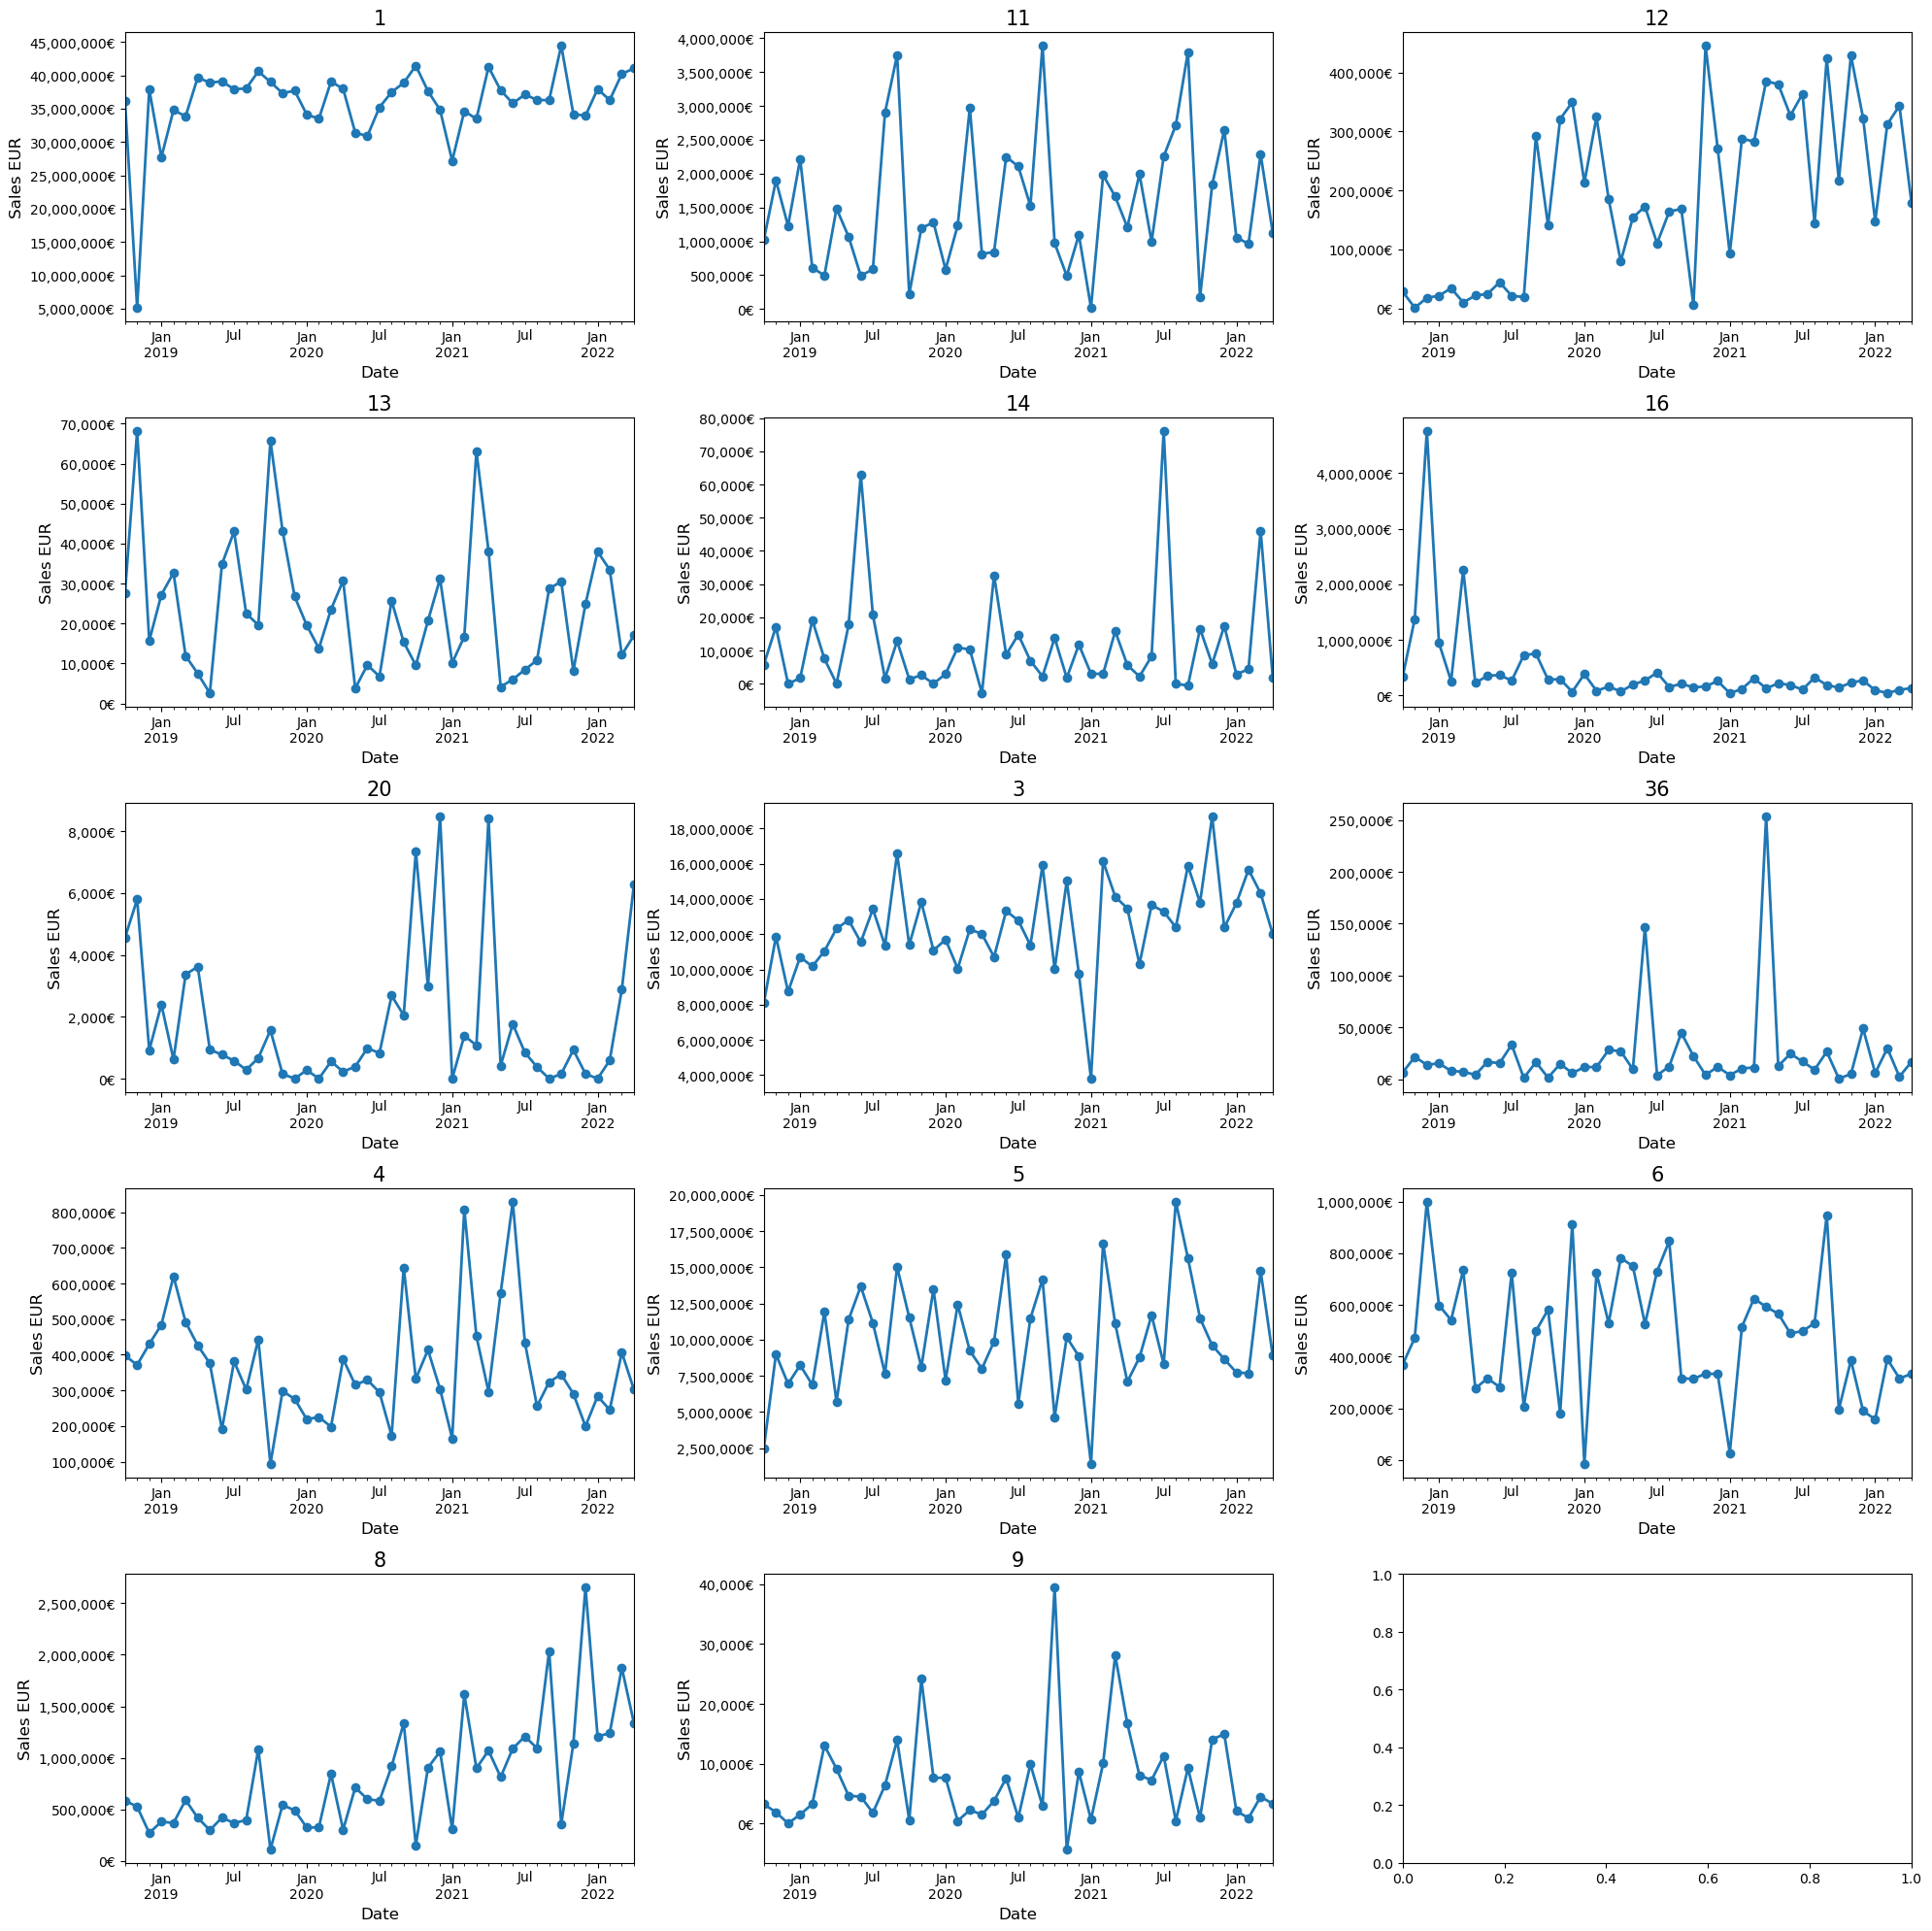

In [25]:
# Create a 5x3 grid of subplots
fig, ax = plt.subplots(5, 3, figsize=(20, 20))

# Flatten the axes array to easily loop through
ax = ax.flatten()

# Loop over the unique values of 'Mapped_GCK' and plot the corresponding data
for i, gck in enumerate(df_sales['Mapped_GCK'].unique()):
    # Filter the data for the current 'Mapped_GCK'
    subset = df_sales[df_sales['Mapped_GCK'] == gck]
    
    # Group by 'DATE' and sum the 'Sales_EUR'
    subset.groupby('DATE')['Sales_EUR'].sum().plot(kind='line', ax=ax[i], marker='o', linewidth=2)
    
    # Set the title and labels for each subplot
    ax[i].set_title(f'{gck}', fontsize=15)  
    ax[i].set_xlabel('Date', fontsize=12) 
    ax[i].set_ylabel('Sales EUR', fontsize=12)

    # Format y-axis to show values in millions
    ax[i].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}€'))

# Adjust layout to prevent overlap of labels and titles
plt.tight_layout()

# Display the plot
plt.show()

### 3.2. Market Data

In [26]:
df_market.head()

Unnamed: 0  \
0  Index 2010=100 (if not otherwise noted)   
1                                     date   
2                                   2004m2   
3                                   2004m3   
4                                   2004m4   

                                      China  \
0  Production Index Machinery & Electricals   
1                            MAB_ELE_PRO156   
2                                 16.940704   
3                                 23.711852   
4                                 24.435235   

                                   China.1  \
0  Shipments Index Machinery & Electricals   
1                           MAB_ELE_SHP156   
2                                16.940704   
3                                23.711852   
4                                24.435235   

                                     France  \
0  Production Index Machinery & Electricals   
1                            MAB_ELE_PRO250   
2                                112.091273   
3                                136.327976   
4                                117.791806   

                                  France.1  \
0  Shipments Index Machinery & Electricals   
1                           MAB_ELE_SHP250   
2                                83.458866   
3                               106.168192   
4                                92.007646   

                                    Germany  \
0  Production Index Machinery & Electricals   
1                            MAB_ELE_PRO276   
2                                 82.623037   
3                                100.556582   
4                                 89.653203   

                                 Germany.1  \
0  Shipments Index Machinery & Electricals   
1                           MAB_ELE_SHP276   
2                                79.452532   
3                                97.012918   
4                                84.932358   

                                      Italy  \
0  Production Index Machinery & Electricals   
1                            MAB_ELE_PRO380   
2                                124.289603   
3                                143.411662   
4                                129.083828   

                                   Italy.1  \
0  Shipments Index Machinery & Electricals   
1                           MAB_ELE_SHP380   
2                                86.560493   
3                               106.344544   
4                                95.579673   

                                      Japan  \
0  Production Index Machinery & Electricals   
1                            MAB_ELE_PRO392   
2                                 109.33401   
3                                140.884616   
4                                105.853579   

                                   Japan.1  \
0  Shipments Index Machinery & Electricals   
1                           MAB_ELE_SHP392   
2                               110.495272   
3                               144.686166   
4                               102.655769   

                                Switzerland  \
0  Production Index Machinery & Electricals   
1                            MAB_ELE_PRO756   
2                                 91.221862   
3                                 85.866287   
4                                 85.622508   

                             Switzerland.1  \
0  Shipments Index Machinery & Electricals   
1                           MAB_ELE_SHP756   
2                                89.987275   
3                                79.883583   
4                                79.740802   

                             United Kingdom  \
0  Production Index Machinery & Electricals   
1                            MAB_ELE_PRO826   
2                                111.353812   
3                                127.558608   
4                                108.732297   

                          United Kingdom.1  \
0  Shipments Index Machinery & Electricals   
1                   

In [27]:
df_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 48 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           221 non-null    object
 1   China                221 non-null    object
 2   China.1              221 non-null    object
 3   France               221 non-null    object
 4   France.1             221 non-null    object
 5   Germany              221 non-null    object
 6   Germany.1            221 non-null    object
 7   Italy                221 non-null    object
 8   Italy.1              221 non-null    object
 9   Japan                221 non-null    object
 10  Japan.1              221 non-null    object
 11  Switzerland          220 non-null    object
 12  Switzerland.1        220 non-null    object
 13  United Kingdom       221 non-null    object
 14  United Kingdom.1     203 non-null    object
 15  United States        221 non-null    object
 16  United S

In [28]:
info_market = df_market.iloc[0:2]
df_market = df_market.iloc[2:]

In [29]:
info_market

Unnamed: 0  \
0  Index 2010=100 (if not otherwise noted)   
1                                     date   

                                      China  \
0  Production Index Machinery & Electricals   
1                            MAB_ELE_PRO156   

                                   China.1  \
0  Shipments Index Machinery & Electricals   
1                           MAB_ELE_SHP156   

                                     France  \
0  Production Index Machinery & Electricals   
1                            MAB_ELE_PRO250   

                                  France.1  \
0  Shipments Index Machinery & Electricals   
1                           MAB_ELE_SHP250   

                                    Germany  \
0  Production Index Machinery & Electricals   
1                            MAB_ELE_PRO276   

                                 Germany.1  \
0  Shipments Index Machinery & Electricals   
1                           MAB_ELE_SHP276   

                                      Italy  \
0  Production Index Machinery & Electricals   
1                            MAB_ELE_PRO380   

                                   Italy.1  \
0  Shipments Index Machinery & Electricals   
1                           MAB_ELE_SHP380   

                                      Japan  \
0  Production Index Machinery & Electricals   
1                            MAB_ELE_PRO392   

                                   Japan.1  \
0  Shipments Index Machinery & Electricals   
1                           MAB_ELE_SHP392   

                                Switzerland  \
0  Production Index Machinery & Electricals   
1                            MAB_ELE_PRO756   

                             Switzerland.1  \
0  Shipments Index Machinery & Electricals   
1                           MAB_ELE_SHP756   

                             United Kingdom  \
0  Production Index Machinery & Electricals   
1                            MAB_ELE_PRO826   

                          United Kingdom.1  \
0  Shipments Index Machinery & Electricals   
1                           MAB_ELE_SHP826   

                              United States  \
0  Production Index Machinery & Electricals   
1                            MAB_ELE_PRO840   

                           United States.1  \
0  Shipments Index Machinery & Electricals   
1                           MAB_ELE_SHP840   

                                     Europe  \
0  Production Index Machinery & Electricals   
1                           MAB_ELE_PRO1100   

                                  Europe.1                  Unnamed: 19  \
0  Shipments Index Machinery & Electricals  World: Price of Base Metals   
1                          MAB_ELE_SHP1100          RohiBASEMET1000_org   

              Unnamed: 20                         Unnamed: 21  \
0  World: Price of Energy  World: Price of Metals  & Minerals   
1      RohiENERGY1000_org                  RohiMETMIN1000_org   

                         Unnamed: 22                         Unnamed: 23  \
0  World: Price of Natural gas index  World: Price of Crude oil, average   
1                 RohiNATGAS1000_org              RohCRUDE_PETRO1000_org   

              Unnamed: 24                Unnamed: 25  \
0  World: Price of Copper  United States: EUR in LCU   
1       RohCOPPER1000_org             WKLWEUR840_org   

                       Producer Prices                     Producer Prices.1  \
0  United States: Electrical equipment  United Kingdom: Electrical equipment   
1                         PRI27840_org                          PRI27826_org   

             Producer Prices.2             Producer Prices.3  \
0  Italy: Electrical equipment  France: Electrical equipment   
1                 PRI27380_org                  PRI27250_org   

               Producer Prices.4            Producer Prices.5  \
0  Germany: Electrical equipment  China: Electrical equipment   
1                   PRI27276_org                 PRI27156_org   

                                production index  \
0

In [30]:
info_market = info_market.transpose().reset_index()
info_market.columns = info_market.iloc[0]
info_market = info_market[1:]  # Drop the old header row
info_market = info_market.rename(columns={info_market.columns[0]: 'Region', info_market.columns[1]: 'Index Name', info_market.columns[2]: 'Index Code'})
info_market.reset_index(drop=True, inplace=True)

In [31]:
info_market

0                Region                                      Index Name  \
0                 China        Production Index Machinery & Electricals   
1               China.1         Shipments Index Machinery & Electricals   
2                France        Production Index Machinery & Electricals   
3              France.1         Shipments Index Machinery & Electricals   
4               Germany        Production Index Machinery & Electricals   
5             Germany.1         Shipments Index Machinery & Electricals   
6                 Italy        Production Index Machinery & Electricals   
7               Italy.1         Shipments Index Machinery & Electricals   
8                 Japan        Production Index Machinery & Electricals   
9               Japan.1         Shipments Index Machinery & Electricals   
10          Switzerland        Production Index Machinery & Electricals   
11        Switzerland.1         Shipments Index Machinery & Electricals   
12       United Kingdom        Production Index Machinery & Electricals   
13     United Kingdom.1         Shipments Index Machinery & Electricals   
14        United States        Production Index Machinery & Electricals   
15      United States.1         Shipments Index Machinery & Electricals   
16               Europe        Production Index Machinery & Electricals   
17             Europe.1         Shipments Index Machinery & Electricals   
18          Unnamed: 19                     World: Price of Base Metals   
19          Unnamed: 20                          World: Price of Energy   
20          Unnamed: 21              World: Price of Metals  & Minerals   
21          Unnamed: 22               World: Price of Natural gas index   
22          Unnamed: 23              World: Price of Crude oil, average   
23          Unnamed: 24                          World: Price of Copper   
24          Unnamed: 25                       United States: EUR in LCU   
25      Producer Prices             United States: Electrical equipment   
26    Producer Prices.1            United Kingdom: Electrical equipment   
27    Producer Prices.2                     Italy: Electrical equipment   
28    Producer Prices.3                    France: Electrical equipment   
29    Producer Prices.4                   Germany: Electrical equipment   
30    Producer Prices.5                     China: Electrical equipment   
31     production index   United States: Machinery and equipment n.e.c.   
32   production index.1           World: Machinery and equipment n.e.c.   
33   production index.2     Switzerland: Machinery and equipment n.e.c.   
34   production index.3  United Kingdom: Machinery and equipment n.e.c.   
35   production index.4           Italy: Machinery and equipment n.e.c.   
36   production index.5           Japan: Machinery and equipment n.e.c.   
37   production index.6          France: Machinery and equipment n.e.c.   
38   production index.7         Germany: Machinery and equipment n.e.c.   
39   production index.8             United States: Electrical equipment   
40   production index.9                     World: Electrical equipment   
41  production index.10               Switzerland: Electrical equipment   
42  production index.11            United Kingdom: Electrical equipment   
43  production index.12                     Italy: Electrical equipment   
44  production index.13                     Japan: Electrical equipment   
45  production index.14                    France: Electrical equipment   
46  production index.15                   Germany: Electrical equipment   

0               Index Code  
0           MAB_ELE_PRO156  
1           MAB_ELE_SHP156  
2           MAB_ELE_PRO250  
3           MAB_ELE_SHP250  
4           MAB_ELE_PRO276  
5           MAB_ELE_SHP276  
6           MAB_ELE_PRO380  
7           MAB_ELE_SHP380  
8           MAB_ELE_PRO392  
9           MAB_ELE_SHP392  
10          MAB_ELE_PRO756  
11          MAB_ELE_SHP756  
12          MAB_ELE_PR

In [32]:
# Lets give a more consistent formating to the info_market dataframe
for idx, row in  info_market.iterrows():
    region = row['Region']
    index_name = row['Index Name']
    
 # Extract Region from Index Name if needed
    if ':' in index_name:
        info_market.at[idx, 'Region'] = index_name.split(':')[0].strip()
        info_market.at[idx, 'Index Name'] = index_name.split(':')[1].strip()
    
    # Remove decimal suffixes from Region
    if '.' in region:
        info_market.at[idx, 'Region'] = row['Region'].split('.')[0].strip()
    
info_market.sort_values('Region').reset_index(drop=True) 

0           Region                                Index Name  \
0            China  Production Index Machinery & Electricals   
1            China   Shipments Index Machinery & Electricals   
2            China                      Electrical equipment   
3           Europe   Shipments Index Machinery & Electricals   
4           Europe  Production Index Machinery & Electricals   
5           France  Production Index Machinery & Electricals   
6           France   Shipments Index Machinery & Electricals   
7           France            Machinery and equipment n.e.c.   
8           France                      Electrical equipment   
9           France                      Electrical equipment   
10         Germany            Machinery and equipment n.e.c.   
11         Germany                      Electrical equipment   
12         Germany                      Electrical equipment   
13         Germany   Shipments Index Machinery & Electricals   
14         Germany  Production Index Machinery & Electricals   
15           Italy                      Electrical equipment   
16           Italy            Machinery and equipment n.e.c.   
17           Italy   Shipments Index Machinery & Electricals   
18           Italy                      Electrical equipment   
19           Italy  Production Index Machinery & Electricals   
20           Japan  Production Index Machinery & Electricals   
21           Japan            Machinery and equipment n.e.c.   
22           Japan   Shipments Index Machinery & Electricals   
23           Japan                      Electrical equipment   
24     Switzerland                      Electrical equipment   
25     Switzerland   Shipments Index Machinery & Electricals   
26     Switzerland            Machinery and equipment n.e.c.   
27     Switzerland  Production Index Machinery & Electricals   
28  United Kingdom                      Electrical equipment   
29  United Kingdom            Machinery and equipment n.e.c.   
30  United Kingdom   Shipments Index Machinery & Electricals   
31  United Kingdom                      Electrical equipment   
32  United Kingdom  Production Index Machinery & Electricals   
33   United States            Machinery and equipment n.e.c.   
34   United States                      Electrical equipment   
35   United States                                EUR in LCU   
36   United States                      Electrical equipment   
37   United States   Shipments Index Machinery & Electricals   
38   United States  Production Index Machinery & Electricals   
39           World            Machinery and equipment n.e.c.   
40           World               Price of Crude oil, average   
41           World                Price of Natural gas index   
42           World               Price of Metals  & Minerals   
43           World                      Electrical equipment   
44           World                           Price of Energy   
45           World                      Price of Base Metals   
46           World                           Price of Copper   

0               Index Code  
0           MAB_ELE_PRO156  
1           MAB_ELE_SHP156  
2             PRI27156_org  
3          MAB_ELE_SHP1100  
4          MAB_ELE_PRO1100  
5           MAB_ELE_PRO250  
6           MAB_ELE_SHP250  
7             PRO28250_org  
8             PRI27250_org  
9             PRO27250_org  
10            PRO28276_org  
11            PRI27276_org  
12            PRO27276_org  
13          MAB_ELE_SHP276  
14          MAB_ELE_PRO276  
15            PRI27380_org  
16            PRO28380_org  
17          MAB_ELE_SHP380  
18            PRO27380_org  
19          MAB_ELE_PRO380  
20          MAB_ELE_PRO392  
21            PRO28392_org  
22          MAB_ELE_SHP392  
23            PRO27392_org  
24            PRO27756_org  
25          MAB_ELE_SHP756  
26            PRO28756_org  
27          MAB_ELE_PRO756  
28            PRO27826_org  
29            PRO28826_org  
30          MAB_ELE_SHP826  

In [33]:
info_market.describe()

0      Region            Index Name      Index Code
count      47                    47              47
unique     10                    11              47
top     World  Electrical equipment  MAB_ELE_PRO156
freq        8                    14               1

Within Index Code, there is a Region Code and a Name Code.

In [34]:
df_market.columns = market_data.iloc[1] 

In [35]:
df_market.shape

(219, 48)

In [36]:
df_market.head()

1     date MAB_ELE_PRO156 MAB_ELE_SHP156 MAB_ELE_PRO250 MAB_ELE_SHP250  \
2   2004m2      16.940704      16.940704     112.091273      83.458866   
3   2004m3      23.711852      23.711852     136.327976     106.168192   
4   2004m4      24.435235      24.435235     117.791806      92.007646   
5   2004m5      23.708115      23.708115     109.002541      85.696486   
6   2004m6      27.009138      27.009138     133.785737     106.641482   

1 MAB_ELE_PRO276 MAB_ELE_SHP276 MAB_ELE_PRO380 MAB_ELE_SHP380 MAB_ELE_PRO392  \
2      82.623037      79.452532     124.289603      86.560493      109.33401   
3     100.556582      97.012918     143.411662     106.344544     140.884616   
4      89.653203      84.932358     129.083828      95.579673     105.853579   
5      86.880571      82.372794     135.590391     100.087039     101.864777   
6      99.010814       95.10874     136.424935     110.889719      120.33292   

1 MAB_ELE_SHP392 MAB_ELE_PRO756 MAB_ELE_SHP756 MAB_ELE_PRO826 MAB_ELE_SHP826  \
2     110.495272      91.221862      89.987275     111.353812      73.601265   
3     144.686166      85.866287      79.883583     127.558608      84.047595   
4     102.655769      85.622508      79.740802     108.732297      73.026027   
5     100.305285      85.378729      79.598021       110.6452      74.591883   
6      119.61638       85.13495      79.455239      122.02096      82.343346   

1 MAB_ELE_PRO840 MAB_ELE_SHP840 MAB_ELE_PRO1100 MAB_ELE_SHP1100  \
2       107.6014       79.24023       97.122911        80.09853   
3     110.187364      98.619024      113.783904       96.015929   
4     108.166564      89.774031      101.715199       85.167236   
5     108.425887      87.463813      101.275727       84.485767   
6     110.569933      97.364496      112.057197       96.963294   

1 RohiBASEMET1000_org RohiENERGY1000_org RohiMETMIN1000_org  \
2           54.039811          44.123338          48.747945   
3           54.666162          47.588957          49.256157   
4           54.872715          47.779013          49.423751   
5           51.230356          53.590898          46.468392   
6           52.876331          50.799575          47.803913   

1 RohiNATGAS1000_org RohCRUDE_PETRO1000_org RohCOPPER1000_org WKLWEUR840_org  \
2          87.076974              39.639458         36.623832         1.2646   
3          87.192705              42.592034         39.931055         1.2262   
4          91.379923              42.650637         39.134854         1.1985   
5           99.04452              47.517121         36.278433         1.2007   
6          98.636267              44.967605          35.65738         1.2138   

1 PRI27840_org PRI27826_org PRI27380_org PRI27250_org PRI27276_org  \
2    78.969864    80.757423    93.020027          NaN    93.230453   
3    79.673569    80.962135    93.540268          NaN    93.335678   
4    80.337639    80.757423    93.852425          NaN    93.440903   
5    80.798828    80.757423    93.852425          NaN    93.546127   
6     80.91349    80.552711    93.956467          NaN    93.440903   

1 PRI27156_org PRO28840_org PRO281000_org PRO28756_org PRO28826_org  \
2          NaN   102.491722     97.597374         97.1   106.191977   
3          NaN    105.62748    113.224892    91.195116   121.625075   
4          NaN   103.484955     100.16909    93.793535   104.965505   
5          NaN   103.643944     99.581436    96.391954   105.885359   
6          NaN   106.062668     109.27771    98.990373   118.252278   

1 PRO28380_org PRO28392_org PRO28250_org PRO28276_org PRO27840_org  \
2   116.790276   110.890034   118.274109     80.82901   117.723991   
3   139.288391   141.176853   148.121841   102.130104   119.220779   
4   125.289566   105.648765   125.482231    90.961426   117.441124   
5   131.988998   101.990361    116.64975    88.082901   117.899216   
6   132.988922   122.136575   143.248734   100.978699   119.499107   

1 PRO271000_org PRO27756_org PRO27826_org PRO27380_org PRO273

In [37]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602 entries, 0 to 601
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        602 non-null    datetime64[ns]
 1   Mapped_GCK  602 non-null    int64         
 2   Sales_EUR   602 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 14.2 KB


In [38]:
# Remove unwanted spaces from the date column
df_market.iloc[:, 0] = df_market.iloc[:, 0].str.strip()

# Replace 'm' with '-' to ensure a correct date format
df_market.iloc[:, 0] = df_market.iloc[:, 0].str.replace('m', '-')

# Convert to datetime format, and match the format to the one in the sales data
df_market[df_market.columns[0]] = pd.to_datetime(df_market[df_market.columns[0]], format="%Y-%m")
df_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 2 to 220
Data columns (total 48 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    219 non-null    datetime64[ns]
 1   MAB_ELE_PRO156          219 non-null    object        
 2   MAB_ELE_SHP156          219 non-null    object        
 3   MAB_ELE_PRO250          219 non-null    object        
 4   MAB_ELE_SHP250          219 non-null    object        
 5   MAB_ELE_PRO276          219 non-null    object        
 6   MAB_ELE_SHP276          219 non-null    object        
 7   MAB_ELE_PRO380          219 non-null    object        
 8   MAB_ELE_SHP380          219 non-null    object        
 9   MAB_ELE_PRO392          219 non-null    object        
 10  MAB_ELE_SHP392          219 non-null    object        
 11  MAB_ELE_PRO756          218 non-null    object        
 12  MAB_ELE_SHP756          218 non-null    object    

In [39]:
df_market.head()

1       date MAB_ELE_PRO156 MAB_ELE_SHP156 MAB_ELE_PRO250 MAB_ELE_SHP250  \
2 2004-02-01      16.940704      16.940704     112.091273      83.458866   
3 2004-03-01      23.711852      23.711852     136.327976     106.168192   
4 2004-04-01      24.435235      24.435235     117.791806      92.007646   
5 2004-05-01      23.708115      23.708115     109.002541      85.696486   
6 2004-06-01      27.009138      27.009138     133.785737     106.641482   

1 MAB_ELE_PRO276 MAB_ELE_SHP276 MAB_ELE_PRO380 MAB_ELE_SHP380 MAB_ELE_PRO392  \
2      82.623037      79.452532     124.289603      86.560493      109.33401   
3     100.556582      97.012918     143.411662     106.344544     140.884616   
4      89.653203      84.932358     129.083828      95.579673     105.853579   
5      86.880571      82.372794     135.590391     100.087039     101.864777   
6      99.010814       95.10874     136.424935     110.889719      120.33292   

1 MAB_ELE_SHP392 MAB_ELE_PRO756 MAB_ELE_SHP756 MAB_ELE_PRO826 MAB_ELE_SHP826  \
2     110.495272      91.221862      89.987275     111.353812      73.601265   
3     144.686166      85.866287      79.883583     127.558608      84.047595   
4     102.655769      85.622508      79.740802     108.732297      73.026027   
5     100.305285      85.378729      79.598021       110.6452      74.591883   
6      119.61638       85.13495      79.455239      122.02096      82.343346   

1 MAB_ELE_PRO840 MAB_ELE_SHP840 MAB_ELE_PRO1100 MAB_ELE_SHP1100  \
2       107.6014       79.24023       97.122911        80.09853   
3     110.187364      98.619024      113.783904       96.015929   
4     108.166564      89.774031      101.715199       85.167236   
5     108.425887      87.463813      101.275727       84.485767   
6     110.569933      97.364496      112.057197       96.963294   

1 RohiBASEMET1000_org RohiENERGY1000_org RohiMETMIN1000_org  \
2           54.039811          44.123338          48.747945   
3           54.666162          47.588957          49.256157   
4           54.872715          47.779013          49.423751   
5           51.230356          53.590898          46.468392   
6           52.876331          50.799575          47.803913   

1 RohiNATGAS1000_org RohCRUDE_PETRO1000_org RohCOPPER1000_org WKLWEUR840_org  \
2          87.076974              39.639458         36.623832         1.2646   
3          87.192705              42.592034         39.931055         1.2262   
4          91.379923              42.650637         39.134854         1.1985   
5           99.04452              47.517121         36.278433         1.2007   
6          98.636267              44.967605          35.65738         1.2138   

1 PRI27840_org PRI27826_org PRI27380_org PRI27250_org PRI27276_org  \
2    78.969864    80.757423    93.020027          NaN    93.230453   
3    79.673569    80.962135    93.540268          NaN    93.335678   
4    80.337639    80.757423    93.852425          NaN    93.440903   
5    80.798828    80.757423    93.852425          NaN    93.546127   
6     80.91349    80.552711    93.956467          NaN    93.440903   

1 PRI27156_org PRO28840_org PRO281000_org PRO28756_org PRO28826_org  \
2          NaN   102.491722     97.597374         97.1   106.191977   
3          NaN    105.62748    113.224892    91.195116   121.625075   
4          NaN   103.484955     100.16909    93.793535   104.965505   
5          NaN   103.643944     99.581436    96.391954   105.885359   
6          NaN   106.062668     109.27771    98.990373   118.252278   

1 PRO28380_org PRO28392_org PRO28250_org PRO28276_org PRO27840_org  \
2   116.790276   110.890034   118.274109     80.82901   117.723991   
3   139.288391   141.176853   148.121841   102.130104   119.220779   
4   125.289566   105.648765   125.482231    90.961426   117.441124   
5   131.988998   101.990361    116.64975    88.082901   117.899216   
6   132.988922   122.136575   143.248734   100.978699   119.499107   

1 PRO271000_org PRO27756_org PRO27826_org PRO2738

In [40]:
# Identify numeric columns (excluding the date column)
numeric_cols = df_market.columns[1:]

# Replace commas with dots and convert to float
df_market[numeric_cols] = df_market[numeric_cols].replace(',', '.').astype(float)


In [41]:
df_market.head()

1       date  MAB_ELE_PRO156  MAB_ELE_SHP156  MAB_ELE_PRO250  MAB_ELE_SHP250  \
2 2004-02-01       16.940704       16.940704      112.091273       83.458866   
3 2004-03-01       23.711852       23.711852      136.327976      106.168192   
4 2004-04-01       24.435235       24.435235      117.791806       92.007646   
5 2004-05-01       23.708115       23.708115      109.002541       85.696486   
6 2004-06-01       27.009138       27.009138      133.785737      106.641482   

1  MAB_ELE_PRO276  MAB_ELE_SHP276  MAB_ELE_PRO380  MAB_ELE_SHP380  \
2       82.623037       79.452532      124.289603       86.560493   
3      100.556582       97.012918      143.411662      106.344544   
4       89.653203       84.932358      129.083828       95.579673   
5       86.880571       82.372794      135.590391      100.087039   
6       99.010814       95.108740      136.424935      110.889719   

1  MAB_ELE_PRO392  MAB_ELE_SHP392  MAB_ELE_PRO756  MAB_ELE_SHP756  \
2      109.334010      110.495272       91.221862       89.987275   
3      140.884616      144.686166       85.866287       79.883583   
4      105.853579      102.655769       85.622508       79.740802   
5      101.864777      100.305285       85.378729       79.598021   
6      120.332920      119.616380       85.134950       79.455239   

1  MAB_ELE_PRO826  MAB_ELE_SHP826  MAB_ELE_PRO840  MAB_ELE_SHP840  \
2      111.353812       73.601265      107.601400       79.240230   
3      127.558608       84.047595      110.187364       98.619024   
4      108.732297       73.026027      108.166564       89.774031   
5      110.645200       74.591883      108.425887       87.463813   
6      122.020960       82.343346      110.569933       97.364496   

1  MAB_ELE_PRO1100  MAB_ELE_SHP1100  RohiBASEMET1000_org  RohiENERGY1000_org  \
2        97.122911        80.098530            54.039811           44.123338   
3       113.783904        96.015929            54.666162           47.588957   
4       101.715199        85.167236            54.872715           47.779013   
5       101.275727        84.485767            51.230356           53.590898   
6       112.057197        96.963294            52.876331           50.799575   

1  RohiMETMIN1000_org  RohiNATGAS1000_org  RohCRUDE_PETRO1000_org  \
2           48.747945           87.076974               39.639458   
3           49.256157           87.192705               42.592034   
4           49.423751           91.379923               42.650637   
5           46.468392           99.044520               47.517121   
6           47.803913           98.636267               44.967605   

1  RohCOPPER1000_org  WKLWEUR840_org  PRI27840_org  PRI27826_org  \
2          36.623832          1.2646     78.969864     80.757423   
3          39.931055          1.2262     79.673569     80.962135   
4          39.134854          1.1985     80.337639     80.757423   
5          36.278433          1.2007     80.798828     80.757423   
6          35.657380          1.2138     80.913490     80.552711   

1  PRI27380_org  PRI27250_org  PRI27276_org  PRI27156_org  PRO28840_org  \
2     93.020027           NaN     93.230453           NaN    102.491722   
3     93.540268           NaN     93.335678           NaN    105.627480   
4     93.852425           NaN     93.440903           NaN    103.484955   
5     93.852425           NaN     93.546127           NaN    103.643944   
6     93.956467           NaN     93.440903           NaN    106.062668   

1  PRO281000_org  PRO28756_org  PRO28826_org  PRO28380_org  PRO28392_org  \
2      97.597374     97.100000    106.191977    116.790276    110.890034   
3     113.224892     91.195116    121.625075    139.288391    141.176853   
4     100.169090     93.793535    104.965505    125.289566    105.648765   
5      99.581436     96.391954    105.885359    131.988998    101.990361   
6     109.277710     98.990373    118.252278    132.988922    122.136575   

1  PRO28250_org  PRO28276_org  PRO27840_org  PRO271000_org  P

In [42]:
df_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 2 to 220
Data columns (total 48 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    219 non-null    datetime64[ns]
 1   MAB_ELE_PRO156          219 non-null    float64       
 2   MAB_ELE_SHP156          219 non-null    float64       
 3   MAB_ELE_PRO250          219 non-null    float64       
 4   MAB_ELE_SHP250          219 non-null    float64       
 5   MAB_ELE_PRO276          219 non-null    float64       
 6   MAB_ELE_SHP276          219 non-null    float64       
 7   MAB_ELE_PRO380          219 non-null    float64       
 8   MAB_ELE_SHP380          219 non-null    float64       
 9   MAB_ELE_PRO392          219 non-null    float64       
 10  MAB_ELE_SHP392          219 non-null    float64       
 11  MAB_ELE_PRO756          218 non-null    float64       
 12  MAB_ELE_SHP756          218 non-null    float64   

In [43]:
df_market.describe().T

count                           mean  \
1                                                              
date                      219  2013-03-01 19:50:08.219177984   
MAB_ELE_PRO156          219.0                     138.303637   
MAB_ELE_SHP156          219.0                     138.303637   
MAB_ELE_PRO250          219.0                     104.431918   
MAB_ELE_SHP250          219.0                     105.316814   
MAB_ELE_PRO276          219.0                     107.499126   
MAB_ELE_SHP276          219.0                     114.898377   
MAB_ELE_PRO380          219.0                     105.228363   
MAB_ELE_SHP380          219.0                     105.735378   
MAB_ELE_PRO392          219.0                     111.948146   
MAB_ELE_SHP392          219.0                     112.670602   
MAB_ELE_PRO756          218.0                      97.834543   
MAB_ELE_SHP756          218.0                      94.784942   
MAB_ELE_PRO826          219.0                     108.752949   
MAB_ELE_SHP826          201.0                      95.957072   
MAB_ELE_PRO840          219.0                     109.418255   
MAB_ELE_SHP840          218.0                     114.160028   
MAB_ELE_PRO1100         219.0                      108.77999   
MAB_ELE_SHP1100         219.0                     110.551132   
RohiBASEMET1000_org     219.0                      89.733341   
RohiENERGY1000_org      219.0                      92.558006   
RohiMETMIN1000_org      219.0                      86.064857   
RohiNATGAS1000_org      219.0                     103.367773   
RohCRUDE_PETRO1000_org  219.0                       89.44652   
RohCOPPER1000_org       219.0                      86.344288   
WKLWEUR840_org          219.0                       1.253503   
PRI27840_org            219.0                     102.185734   
PRI27826_org            201.0                     100.151243   
PRI27380_org            219.0                     102.164957   
PRI27250_org            184.0                     101.969436   
PRI27276_org            219.0                     103.173606   
PRI27156_org            196.0                      97.681389   
PRO28840_org            219.0                     108.668835   
PRO281000_org           219.0                     112.466417   
PRO28756_org            218.0                      99.717112   
PRO28826_org            219.0                     104.384938   
PRO28380_org            219.0                     109.486312   
PRO28392_org            219.0                     115.083174   
PRO28250_org            219.0                      109.11666   
PRO28276_org            219.0                     110.429205   
PRO27840_org            219.0                     110.902904   
PRO271000_org           208.0                      111.14707   
PRO27756_org            218.0                      94.592852   
PRO27826_org            219.0                     116.667327   
PRO27380_org            219.0                      95.450517   
PRO27392_org            219.0                     105.555794   
PRO27250_org            219.0                      96.844134   
PRO27276_org            219.0                     102.125494   

                                        min                  25%  \
1                                                                  
date                    2004-02-01 00:00:00  2008-08-16 12:00:00   
MAB_ELE_PRO156                    16.940704             68.47774   
MAB_ELE_SHP156                    16.940704             68.47774   
MAB_ELE_PRO250                     50.75668            93.613505   
MAB_ELE_SHP250                    64.420676            97.452819   
MAB_ELE_PRO276                    74.332913           100.560897   
MAB_ELE_SHP276                    71.787161           103.149778   
MAB_ELE_PRO380                    34.213427            94.335162   
MAB_ELE_SHP380                     45.19171            95.985839   
MAB_ELE_PRO392                     67.53194           103.740049   
MAB_ELE

we now have two dataset for the market data, one called "df_market" which contains all the value  of the market data, and another called "info_market" that hols the decription of the code for each columns

# Product Group Analysis

In [44]:
# Existing product groups in the sales data
df_sales['Mapped_GCK'].unique()

array([ 1, 11, 12, 13, 14, 16, 20,  3, 36,  4,  5,  6,  8,  9])

### **Normality - Shapiro-Wilk Test**  

The **Shapiro-Wilk test** checks whether a time series follows a **normal distribution**. Some statistical models assume normally distributed residuals, making this test useful for understanding data characteristics.  

The hypotheses are:  
- **H₀ (Null Hypothesis):** The data is **normally distributed**.  
- **H₁ (Alternative Hypothesis):** The data **is not normally distributed**.  

If **p-value > 0.05**, we fail to reject H₀, indicating normality. If **p-value ≤ 0.05**, the data is non-normal, and transformations may be considered depending on the modeling approach.


### **Stationarity - Augmented Dickey-Fuller (ADF) Test**  

In time series forecasting, **stationarity is important** to ensure because statitical models assume that the statistical properties of a time series **(mean, variance, autocorrelation)** remain constant over time.  

A time series is **stationary** if it lacks trends or seasonal effects that could mislead the model. **Ensuring stationarity improves forecasting accuracy**, as models can focus on the **true underlying relationships** rather than temporary fluctuations.  

The **Augmented Dickey-Fuller (ADF) test** determines if a time series is **stationary or non-stationary**. If the series is **non-stationary (p > 0.05)**, transformations like **differencing** are applied to remove trends or seasonality, ensuring stability for predictive modeling.

We need to check whether the sales data for each product group is stationary, because stationarity affects model selection and forecasting accuracy. In time series forecasting, stationarity is crucial because many statistical models (e.g., ARIMA, SARIMA, etc.) assume that the underlying data-generating process does not change over time.

A time series is stationary if its statistical properties (mean, variance, autocorrelation) do not change over time. By ensuring stationarity, we remove trends or seasonality that might mislead the model. statistical properties (mean, variance, and autocorrelation) of a time series need to remain constant over time because time series models use past patterns to predict the future.

A stationary series removes distractions like trends and seasonality so that models can focus on the true underlying relationships in the data.


We performed the Augmented Dickey-Fuller test to assess the stationarity of the time series. The hypotheses are:

- H0: The time series has a unit root (it is non-stationary)."
- H1: The time series does not have a unit root (it is stationary).


### **Seasonality - Seasonal Decomposition**  

In time series forecasting, sales data often contains **recurring patterns** at fixed intervals, known as **seasonality**. To understand these patterns, we apply **seasonal decomposition**, which breaks a time series into three main components:  

- **Trend** 📈 → Long-term movement (e.g., increasing or decreasing sales over time).  
- **Seasonality** 🔄 → Repeating fluctuations that occur at regular intervals (e.g., monthly, quarterly).  
- **Residuals** 🎲 → Random variations that cannot be explained by trend or seasonality.  

By separating these components, we gain insights into whether seasonality **significantly impacts sales**, helping us determine how to handle it in forecasting models.  

#### **🔹 How Does Seasonal Decomposition Work?**  
- A **moving average** is used to estimate the **trend**.  
- The remaining seasonal effects are extracted as the **seasonal component**.  
- After removing both trend and seasonality, the residual component shows **random fluctuations**.  

#### **🔹 Why Is This Important in Project Siemens?**  
- Helps identify **seasonal demand patterns** across product groups.  
- Confirms whether certain products have **recurring sales peaks or declines**.  
- If seasonality is strong, we might later **adjust forecasting models accordingly** (e.g., SARIMA instead of ARIMA).  

By applying seasonal decomposition, we ensure that our time series analysis accounts for trends and seasonality **before moving to correlation analysis and forecasting**.

### Correlation - Auto-Correlation (ACF & PACF) and Cross-Correlation

2️⃣ Two Types of Correlation We Will Analyze:
✅ Auto-Correlation (ACF & PACF)

Measures the correlation between a time series and its past values at different time lags.
ACF (Auto-Correlation Function) shows direct and indirect correlations.
PACF (Partial Auto-Correlation Function) isolates direct relationships, filtering out indirect effects.
✅ Cross-Correlation

Measures how one time series correlates with another at different time lags.
Useful to analyze whether external factors (e.g., macroeconomic indices) influence sales.

# Product Group 1

In [45]:
sales_agg1 = get_sales_by_product_group(df_sales, product_group=1)
sales_agg1.head()

DATE    Sales_EUR
0 2018-10-01  36098918.79
1 2018-11-01   5140760.00
2 2018-12-01  37889612.12
3 2019-01-01  27728148.35
4 2019-02-01  34793163.53

In [46]:
shapiro_result1 = shapiro_wilk_test(sales_agg1['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.682443
p-value: 0.000000

❌ The p-value (0.000000) is less than 0.05.
   We reject the null hypothesis, meaning the data is not normally distributed.



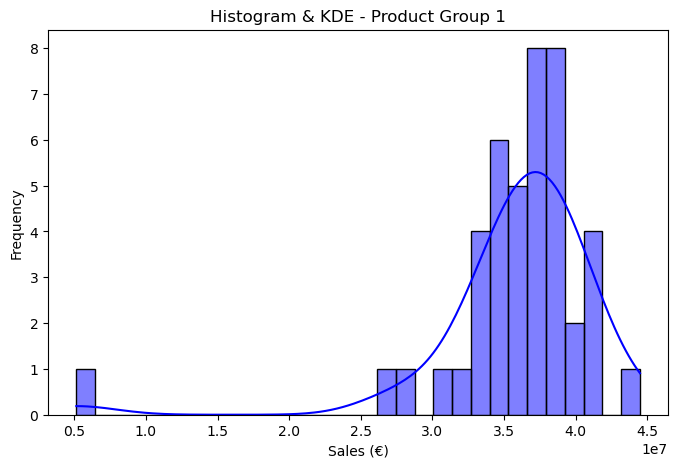

In [47]:
plot_distribution(sales_agg1['Sales_EUR'], product_group=1)

In [48]:
adf_result1 = adf_test(sales_agg1['Sales_EUR'], product_group=1)

Augmented Dickey-Fuller (ADF) Test - Product Group 1


ADF Statistic: -6.002443
p-value: 0.000000
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605

✅ The p-value (0.000000) is ≤ 0.05.
   We reject the null hypothesis, meaning the data is stationary.



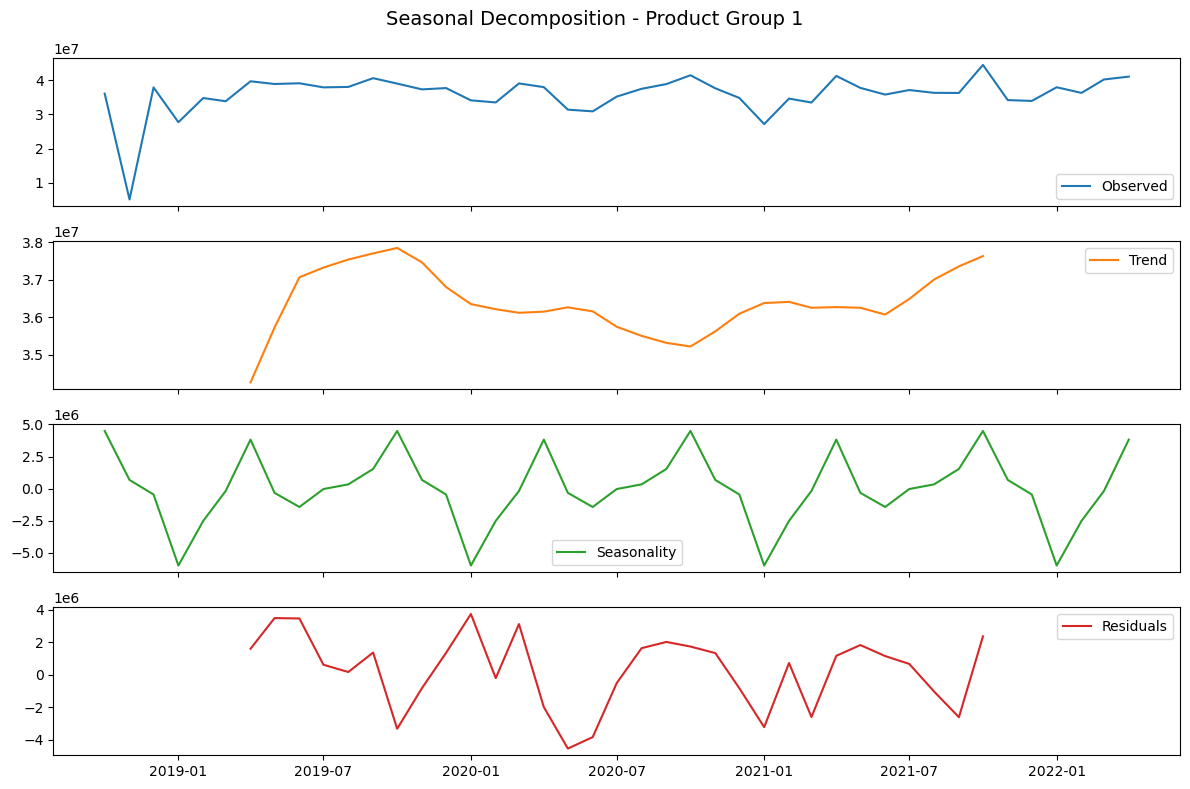

In [49]:
seasonal_decomposition(sales_agg1, product_group=1, date_column='DATE')

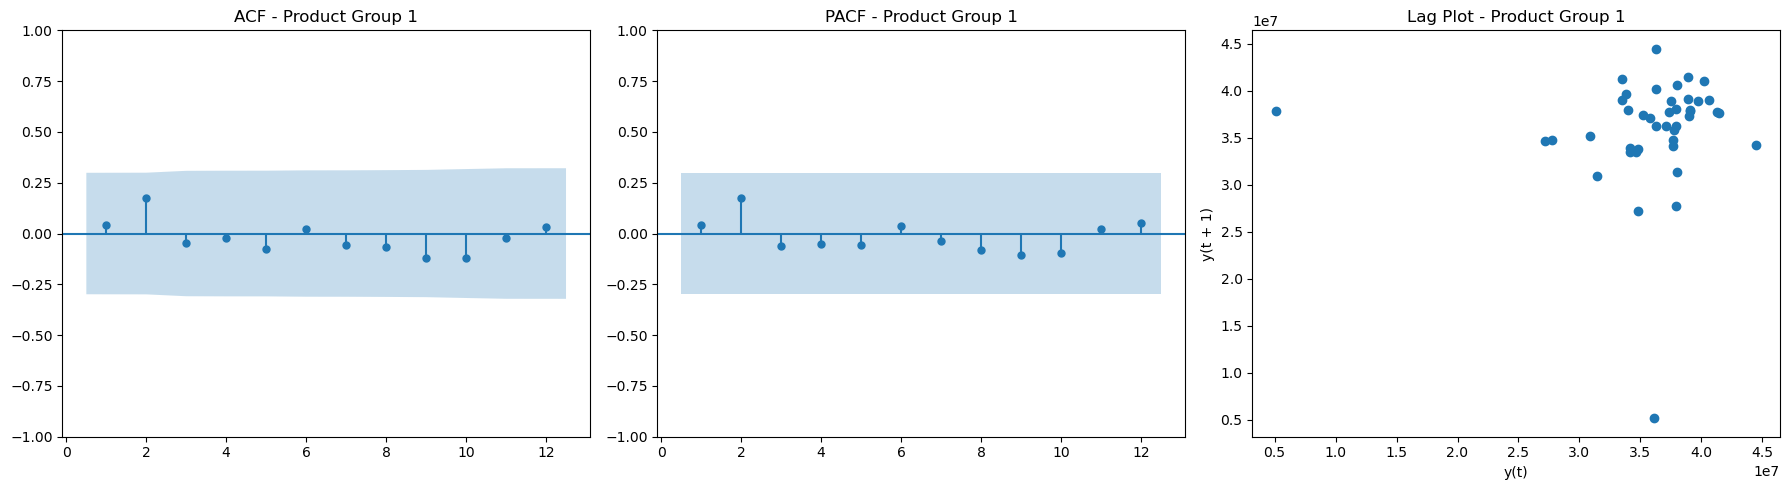

In [50]:
plot_acf_pacf(sales_agg1, product_group=1, max_lag=12)

## feature selection 

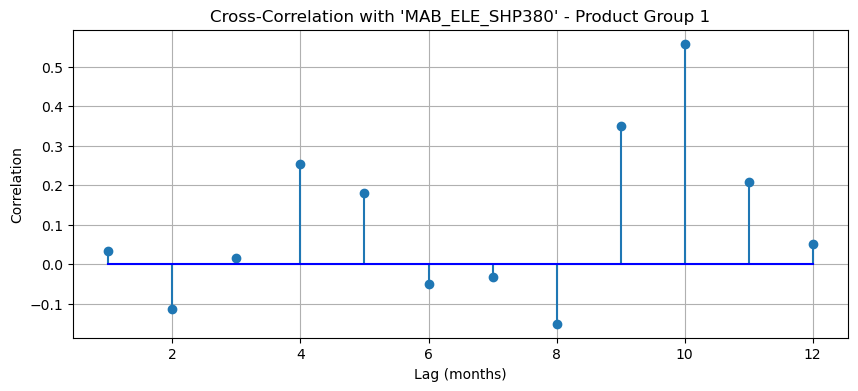

Selected Features for Product Group:
['MAB_ELE_SHP380']


In [51]:
relevant_corr_1, selected_features_1 = plot_cross_correlation(
    sales_df=sales_agg1,
    market_df=df_market,
    product_group=1,
    max_lag=12,
    threshold=0.5
)


In [52]:
filtered_info_market = info_market[info_market['Index Code'].isin(selected_features_1)]

filtered_info_market

0 Region                               Index Name      Index Code
7  Italy  Shipments Index Machinery & Electricals  MAB_ELE_SHP380

# Product Group 3

In [53]:
sales_agg3 = get_sales_by_product_group(df_sales, product_group=3)
sales_agg3.head()

DATE    Sales_EUR
0 2018-10-01   8089465.96
1 2018-11-01  11863001.51
2 2018-12-01   8736859.39
3 2019-01-01  10705300.63
4 2019-02-01  10167796.86

In [54]:
shapiro_result3 = shapiro_wilk_test(sales_agg3['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.963334
p-value: 0.183396

✅ The p-value (0.183396) is greater than 0.05.
   We fail to reject the null hypothesis, meaning the data appears normally distributed.



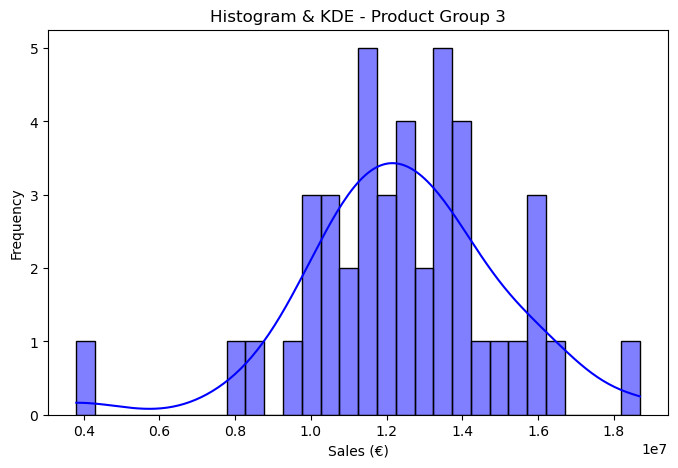

In [55]:
plot_distribution(sales_agg3['Sales_EUR'], product_group=3)

In [56]:
adf_result3 = adf_test(sales_agg3['Sales_EUR'], product_group=3)

Augmented Dickey-Fuller (ADF) Test - Product Group 3
ADF Statistic: -6.590291
p-value: 0.000000
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605

✅ The p-value (0.000000) is ≤ 0.05.
   We reject the null hypothesis, meaning the data is stationary.



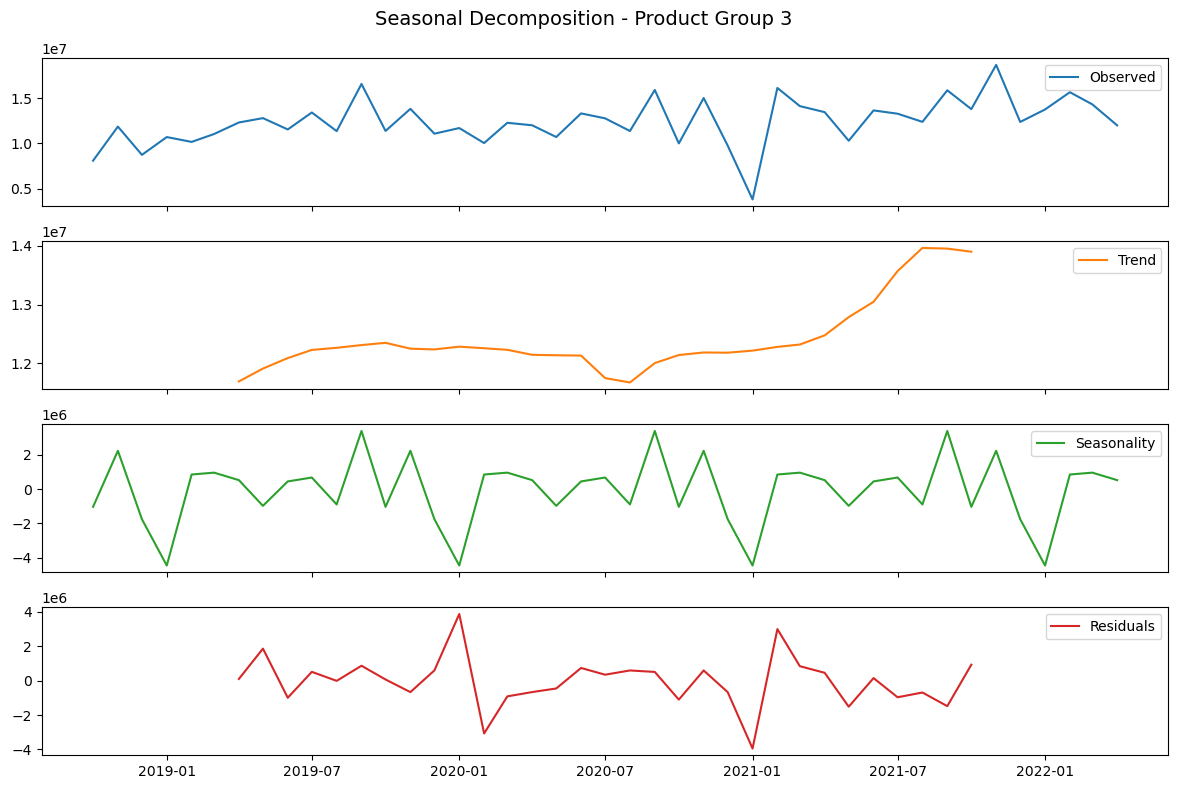

In [57]:
seasonal_decomposition(sales_agg3, product_group=3, date_column='DATE')

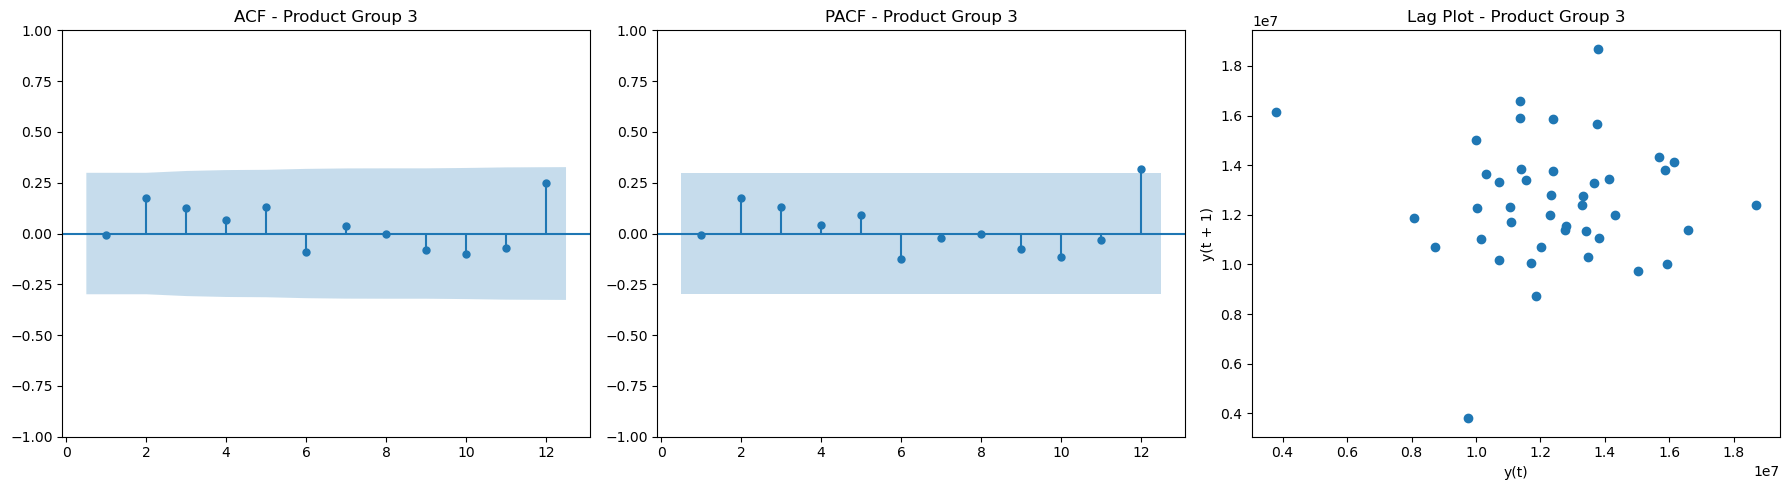

In [58]:
plot_acf_pacf(sales_agg3, product_group=3, max_lag=12)

## Feature selection

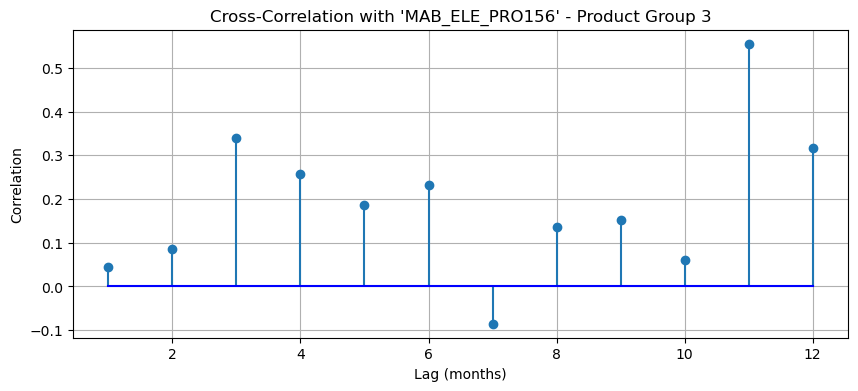

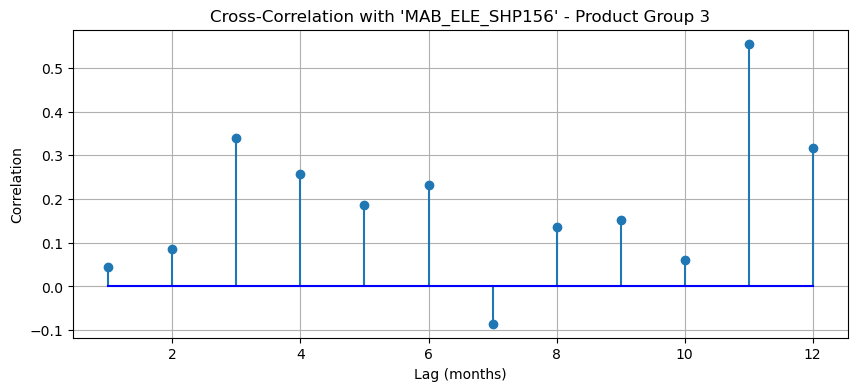

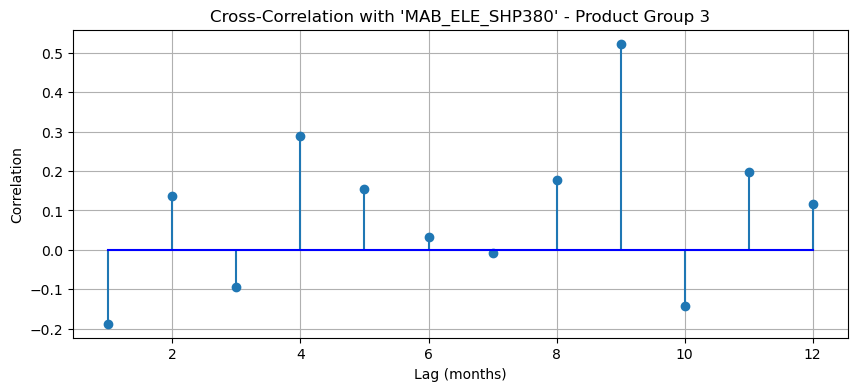

Selected Features for Product Group:
['MAB_ELE_PRO156', 'MAB_ELE_SHP156', 'MAB_ELE_SHP380']


In [59]:
relevant_corr_3, selected_features_3 = plot_cross_correlation(
    sales_df=sales_agg3,
    market_df=df_market,
    product_group=3,
    max_lag=12,
    threshold=0.5
)

### Autocorrelation

In [60]:
filtered_info_market = info_market[info_market['Index Code'].isin(selected_features_3)]

filtered_info_market

0 Region                                Index Name      Index Code
0  China  Production Index Machinery & Electricals  MAB_ELE_PRO156
1  China   Shipments Index Machinery & Electricals  MAB_ELE_SHP156
7  Italy   Shipments Index Machinery & Electricals  MAB_ELE_SHP380

# Product Group 4

In [61]:
sales_agg4 = get_sales_by_product_group(df_sales, product_group=4)
sales_agg4.head()

DATE  Sales_EUR
0 2018-10-01  397760.69
1 2018-11-01  371322.42
2 2018-12-01  430100.96
3 2019-01-01  484173.88
4 2019-02-01  620031.80

In [62]:
shapiro_result4 = shapiro_wilk_test(sales_agg4['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.912683
p-value: 0.003105

❌ The p-value (0.003105) is less than 0.05.
   We reject the null hypothesis, meaning the data is not normally distributed.



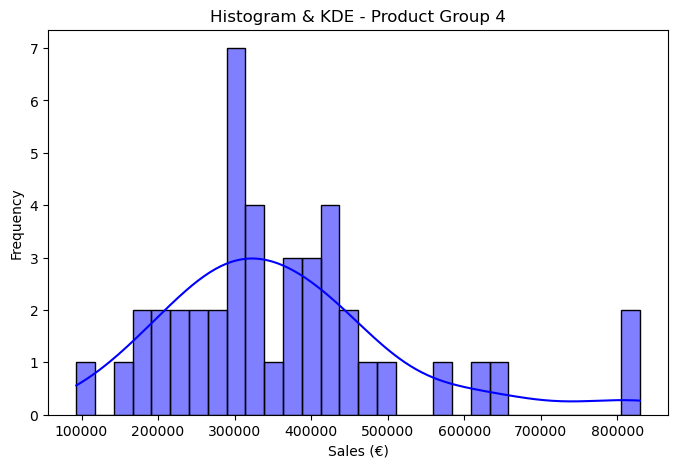

In [63]:
plot_distribution(sales_agg4['Sales_EUR'], product_group=4)

In [64]:
adf_result4 = adf_test(sales_agg4['Sales_EUR'], product_group=4)

Augmented Dickey-Fuller (ADF) Test - Product Group 4
ADF Statistic: -5.319293
p-value: 0.000005
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605

✅ The p-value (0.000005) is ≤ 0.05.
   We reject the null hypothesis, meaning the data is stationary.



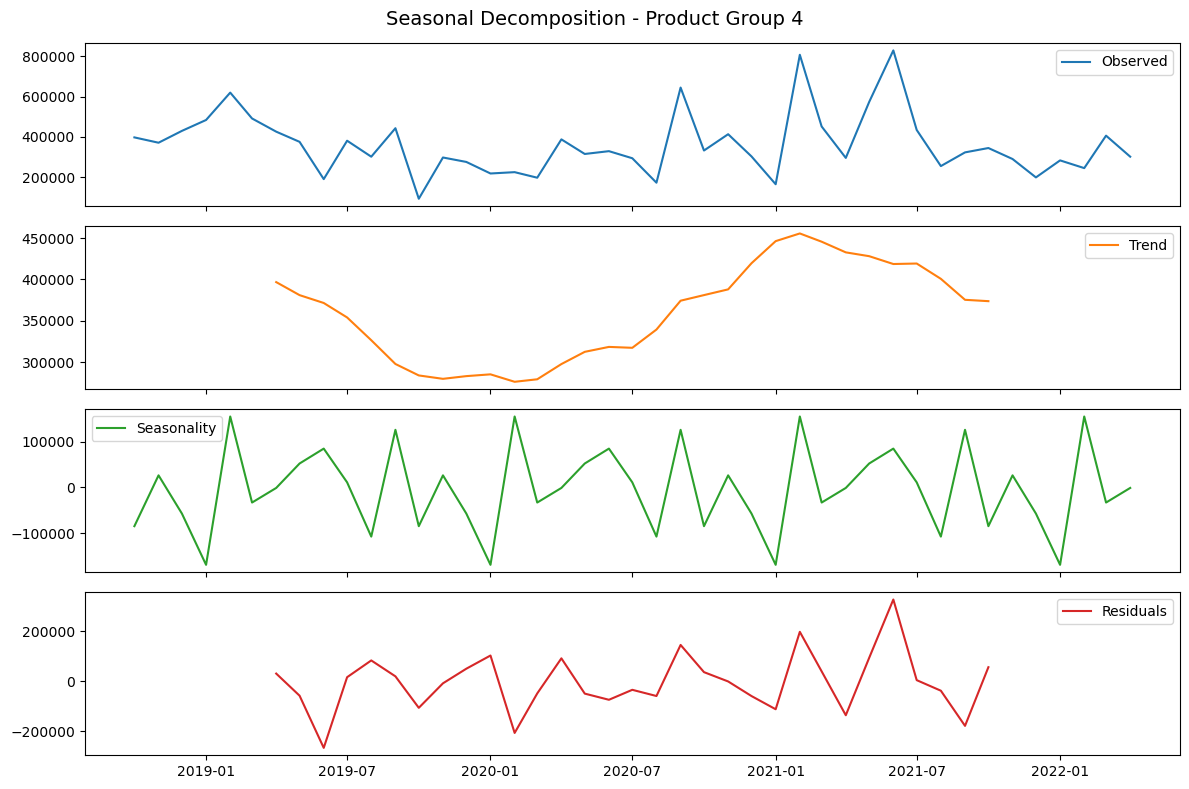

In [65]:
seasonal_decomposition(sales_agg4, product_group=4, date_column='DATE')

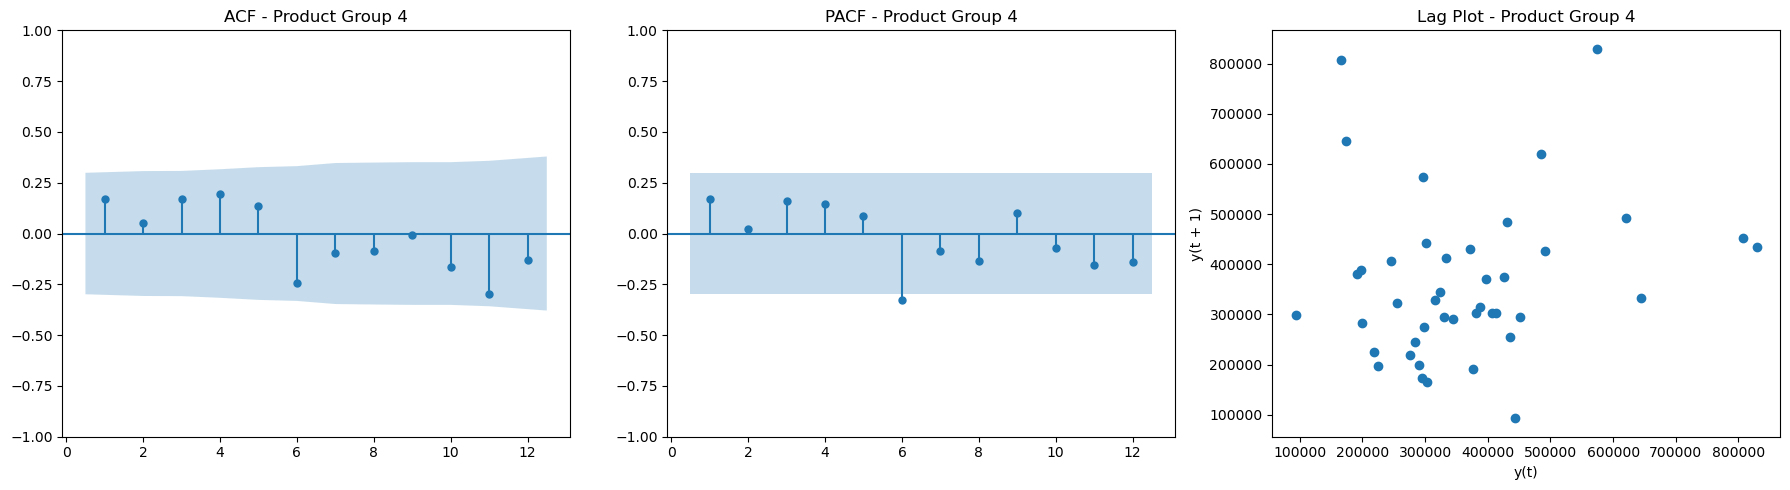

In [66]:
plot_acf_pacf(sales_agg4, product_group=4, max_lag=12)

## Feature selection

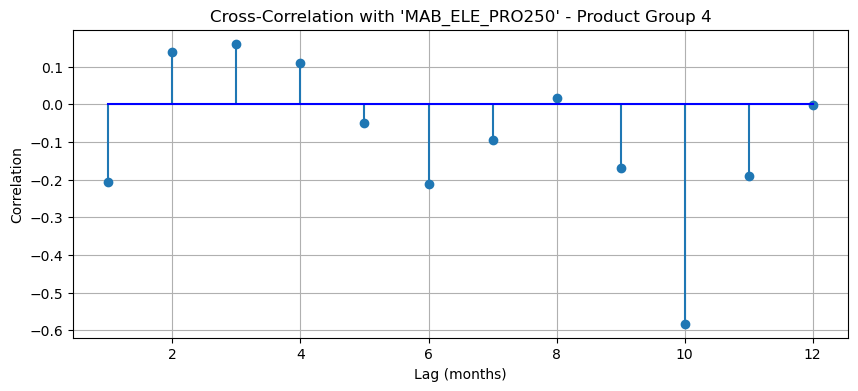

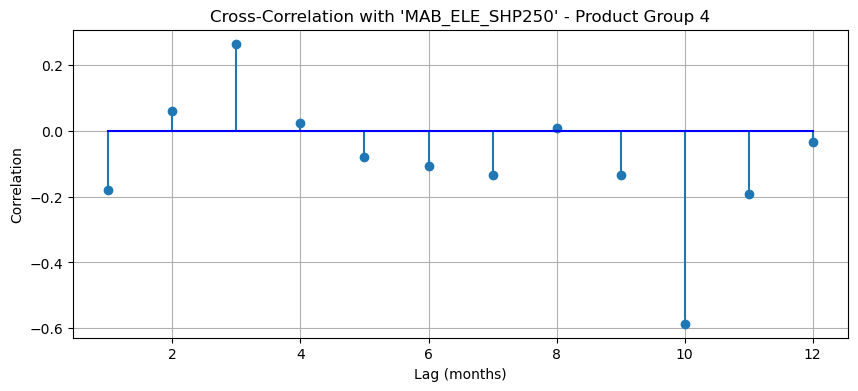

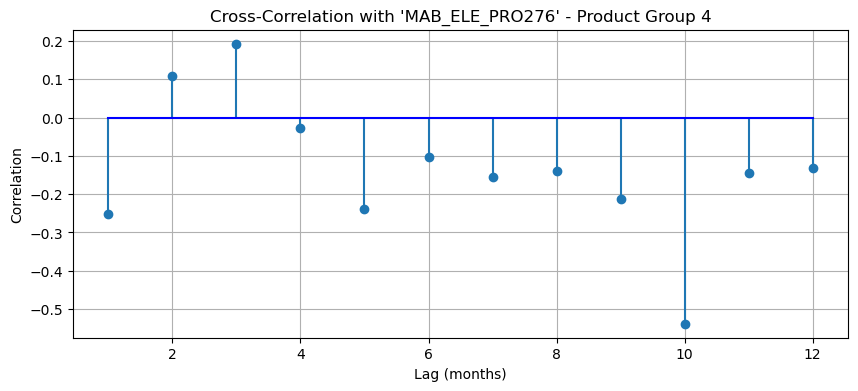

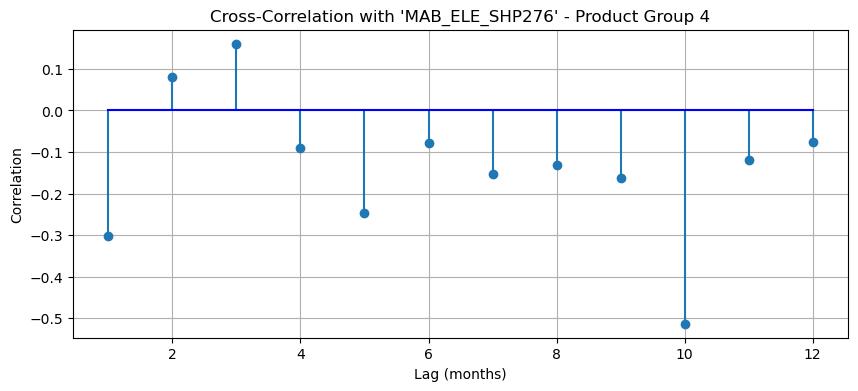

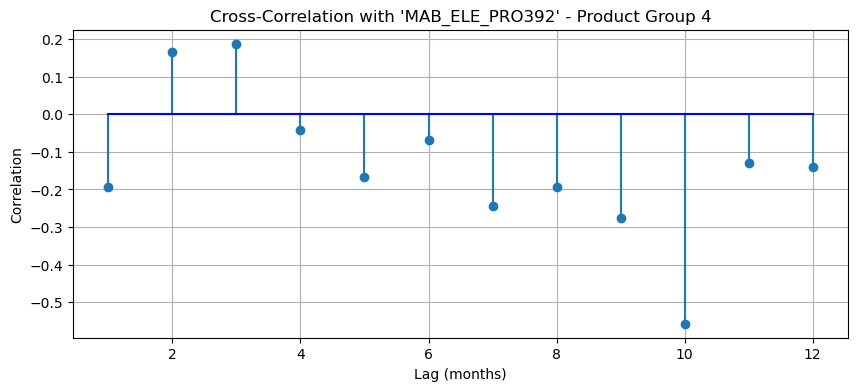

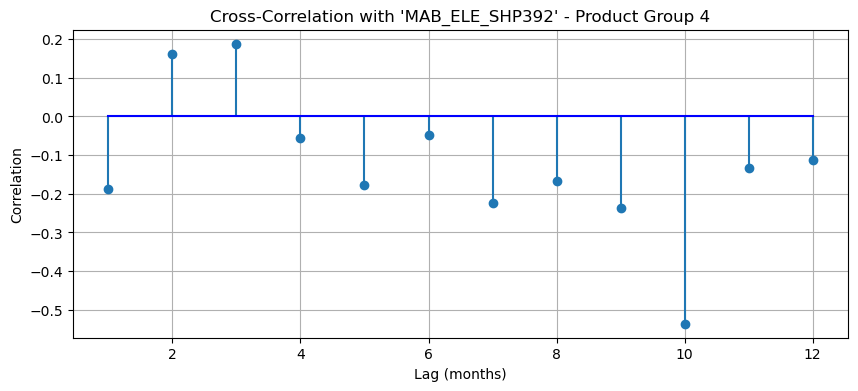

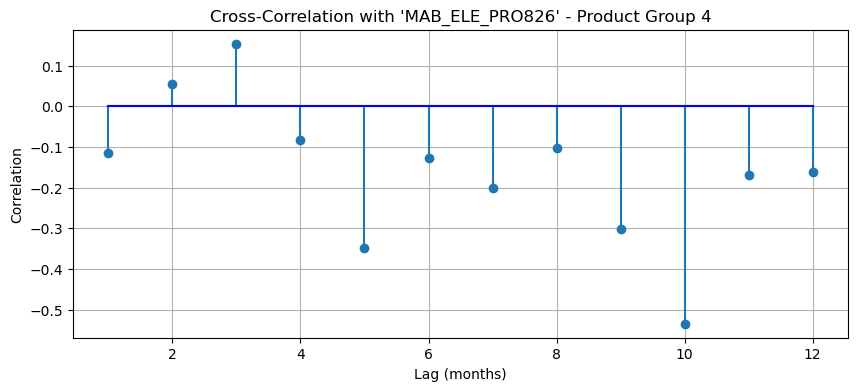

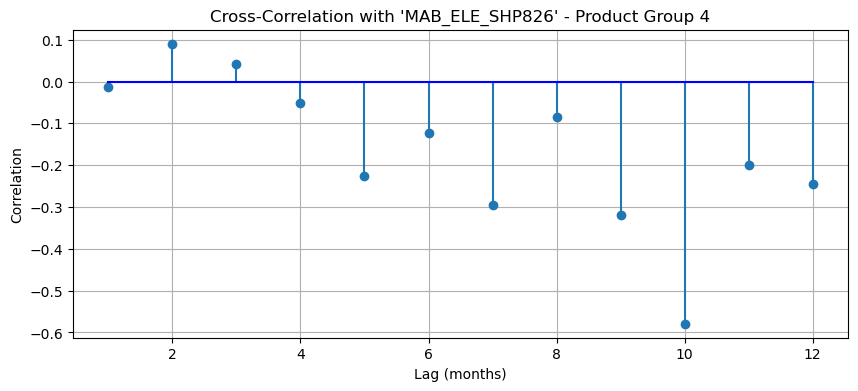

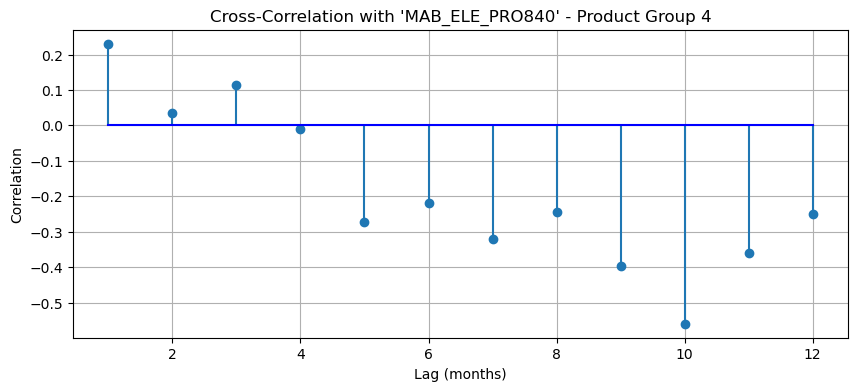

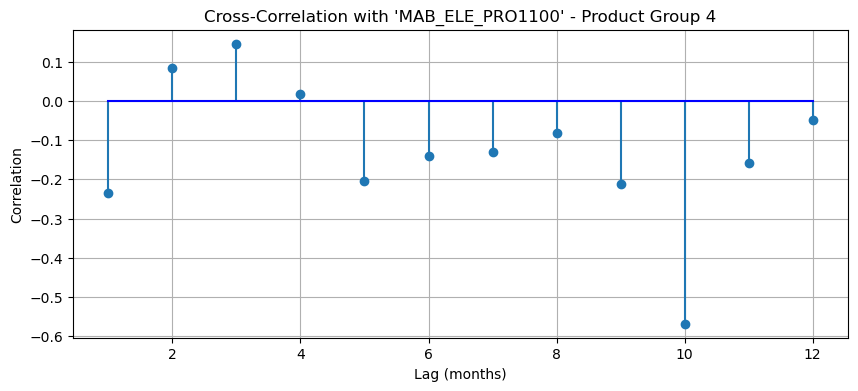

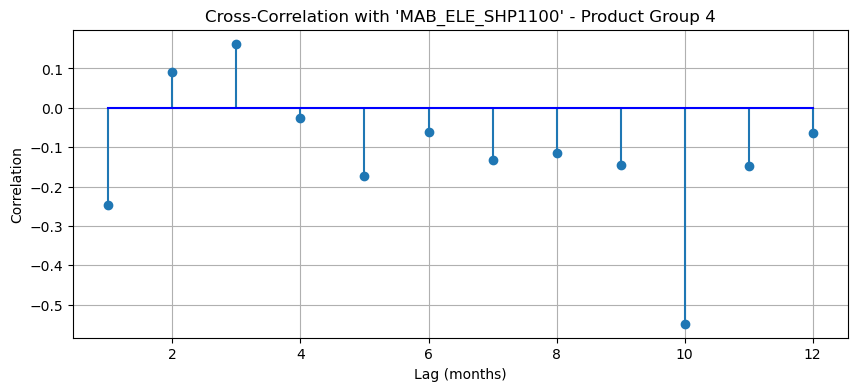

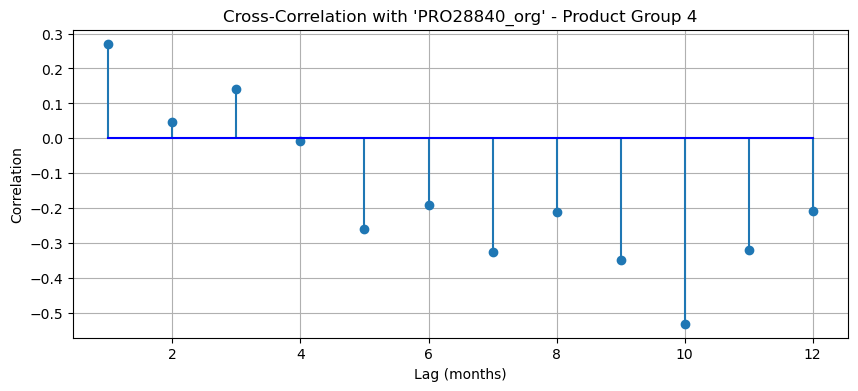

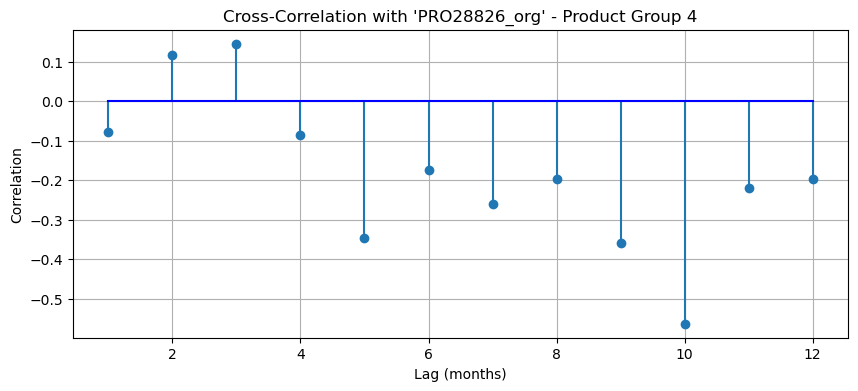

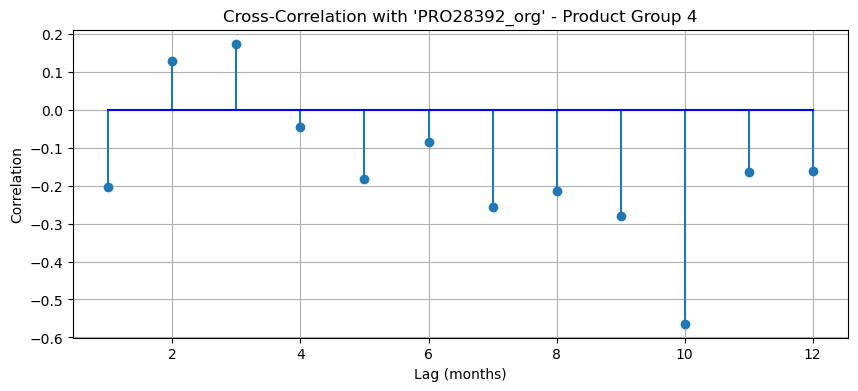

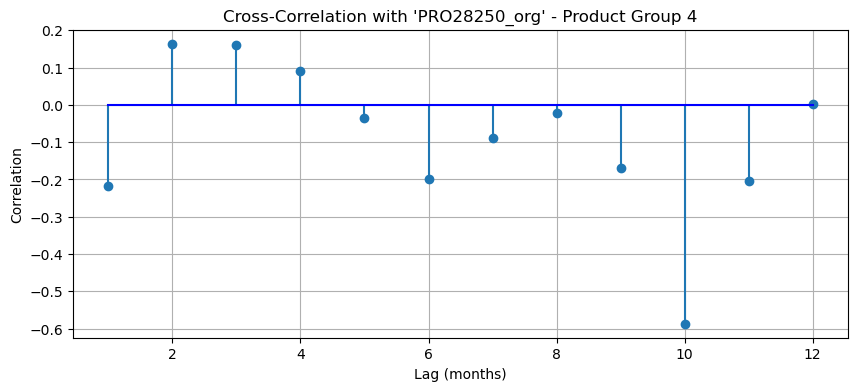

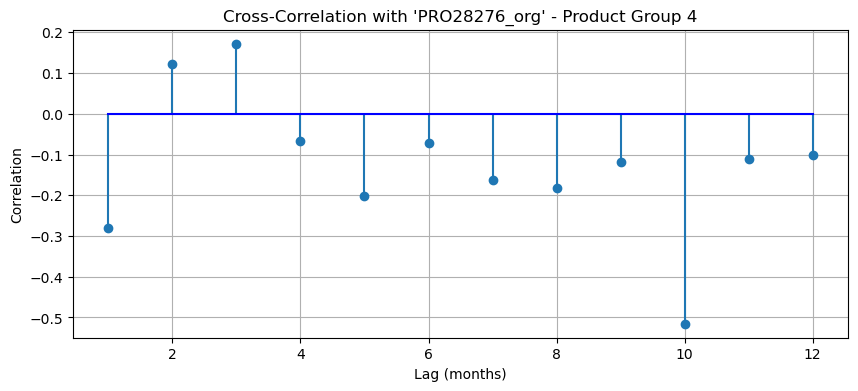

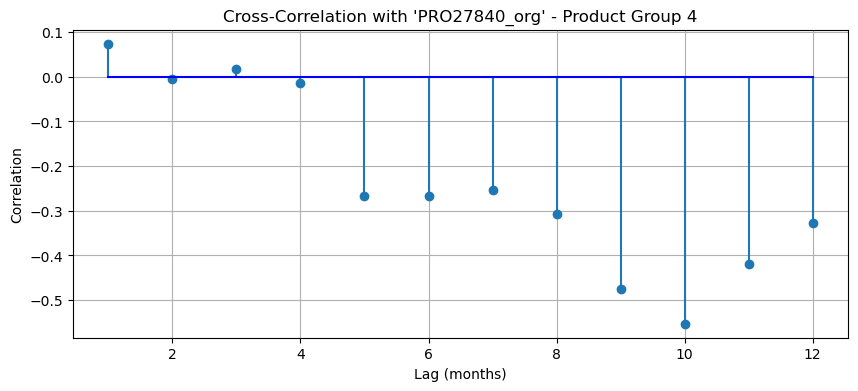

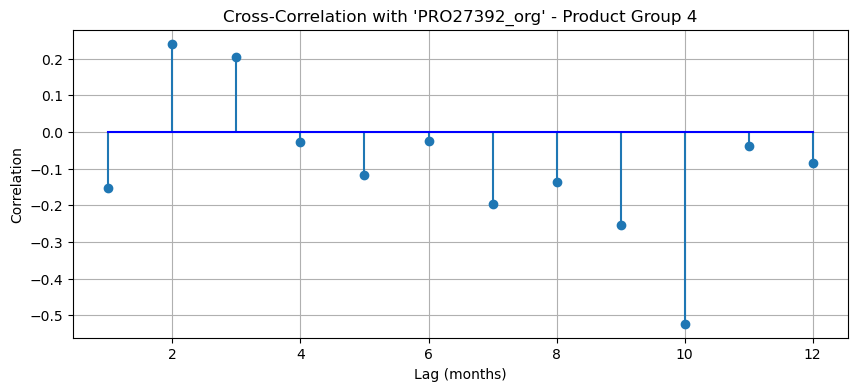

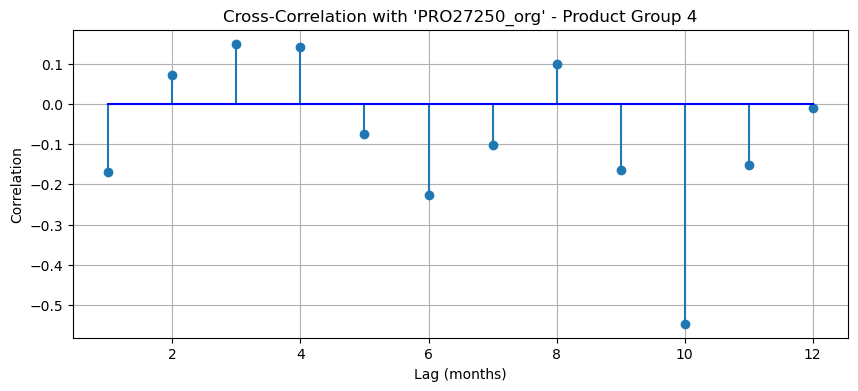

Selected Features for Product Group:
['MAB_ELE_PRO250', 'MAB_ELE_SHP250', 'MAB_ELE_PRO276', 'MAB_ELE_SHP276', 'MAB_ELE_PRO392', 'MAB_ELE_SHP392', 'MAB_ELE_PRO826', 'MAB_ELE_SHP826', 'MAB_ELE_PRO840', 'MAB_ELE_PRO1100', 'MAB_ELE_SHP1100', 'PRO28840_org', 'PRO28826_org', 'PRO28392_org', 'PRO28250_org', 'PRO28276_org', 'PRO27840_org', 'PRO27392_org', 'PRO27250_org']


In [67]:
relevant_corr_4, selected_features_4 = plot_cross_correlation(
    sales_df=sales_agg4,
    market_df=df_market,
    product_group=4,
    max_lag=12,
    threshold=0.5
)

In [68]:
filtered_info_market = info_market[info_market['Index Code'].isin(selected_features_4)]

filtered_info_market

0           Region                                Index Name       Index Code
2           France  Production Index Machinery & Electricals   MAB_ELE_PRO250
3           France   Shipments Index Machinery & Electricals   MAB_ELE_SHP250
4          Germany  Production Index Machinery & Electricals   MAB_ELE_PRO276
5          Germany   Shipments Index Machinery & Electricals   MAB_ELE_SHP276
8            Japan  Production Index Machinery & Electricals   MAB_ELE_PRO392
9            Japan   Shipments Index Machinery & Electricals   MAB_ELE_SHP392
12  United Kingdom  Production Index Machinery & Electricals   MAB_ELE_PRO826
13  United Kingdom   Shipments Index Machinery & Electricals   MAB_ELE_SHP826
14   United States  Production Index Machinery & Electricals   MAB_ELE_PRO840
16          Europe  Production Index Machinery & Electricals  MAB_ELE_PRO1100
17          Europe   Shipments Index Machinery & Electricals  MAB_ELE_SHP1100
31   United States            Machinery and equipment n.e.c.     PRO28840_org
34  United Kingdom            Machinery and equipment n.e.c.     PRO28826_org
36           Japan            Machinery and equipment n.e.c.     PRO28392_org
37          France            Machinery and equipment n.e.c.     PRO28250_org
38         Germany            Machinery and equipment n.e.c.     PRO28276_org
39   United States                      Electrical equipment     PRO27840_org
44           Japan                      Electrical equipment     PRO27392_org
45          France                      Electrical equipment     PRO27250_org

# Product Group 5

In [69]:
sales_agg5 = get_sales_by_product_group(df_sales, product_group=5)
sales_agg5.head()

DATE   Sales_EUR
0 2018-10-01  2499061.19
1 2018-11-01  8993944.04
2 2018-12-01  6947507.31
3 2019-01-01  8233205.07
4 2019-02-01  6879250.99

In [70]:
shapiro_result5 = shapiro_wilk_test(sales_agg5['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.983178
p-value: 0.771690

✅ The p-value (0.771690) is greater than 0.05.
   We fail to reject the null hypothesis, meaning the data appears normally distributed.



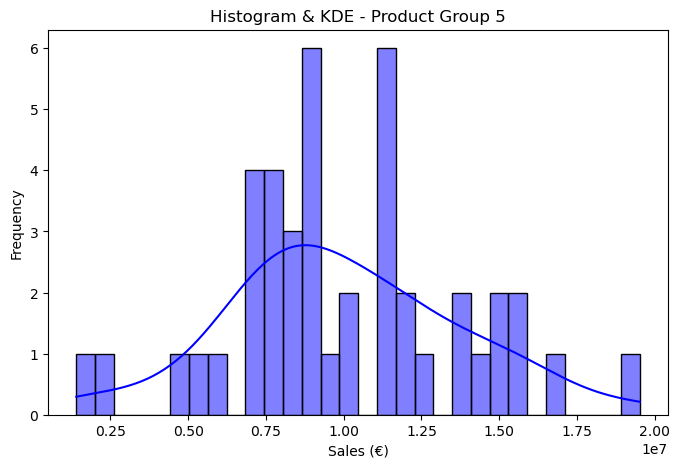

In [71]:
plot_distribution(sales_agg5['Sales_EUR'], product_group=5)

In [72]:
adf_result5 = adf_test(sales_agg5['Sales_EUR'], product_group=5)

Augmented Dickey-Fuller (ADF) Test - Product Group 5
ADF Statistic: -7.636228
p-value: 0.000000
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605

✅ The p-value (0.000000) is ≤ 0.05.
   We reject the null hypothesis, meaning the data is stationary.



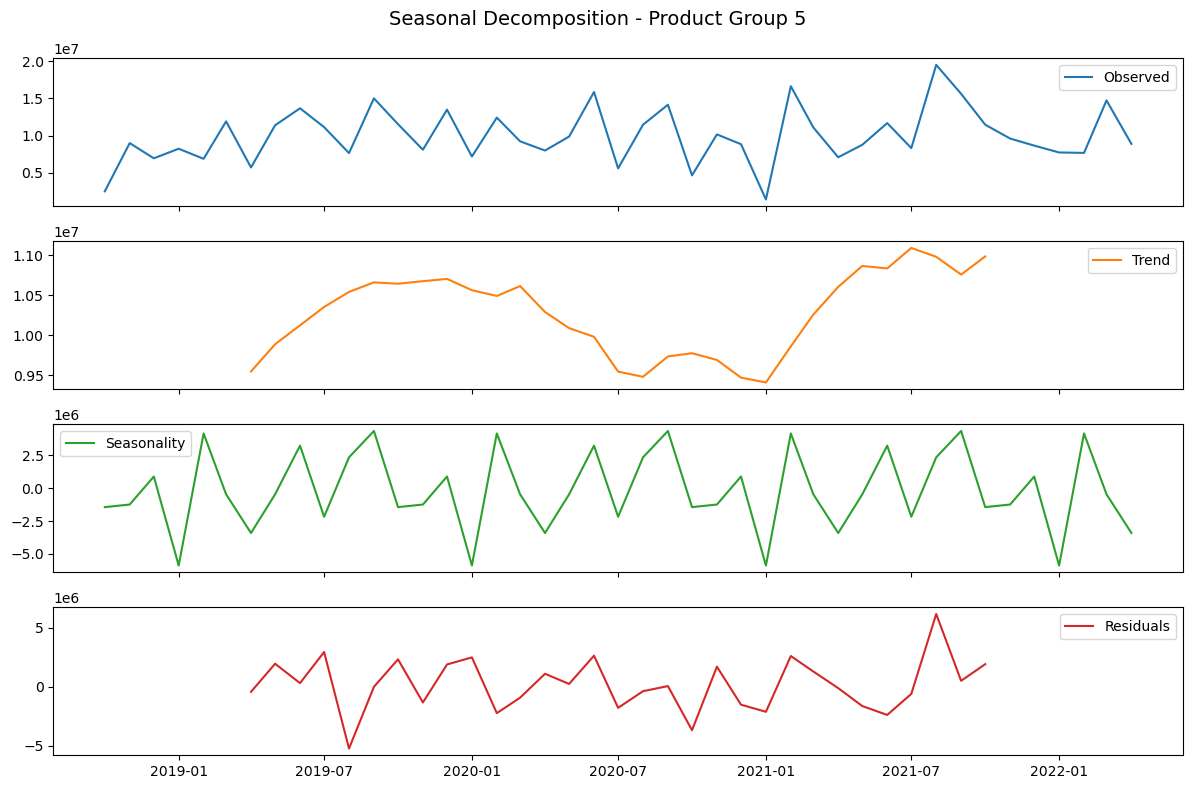

In [73]:
seasonal_decomposition(sales_agg5, product_group=5, date_column='DATE')

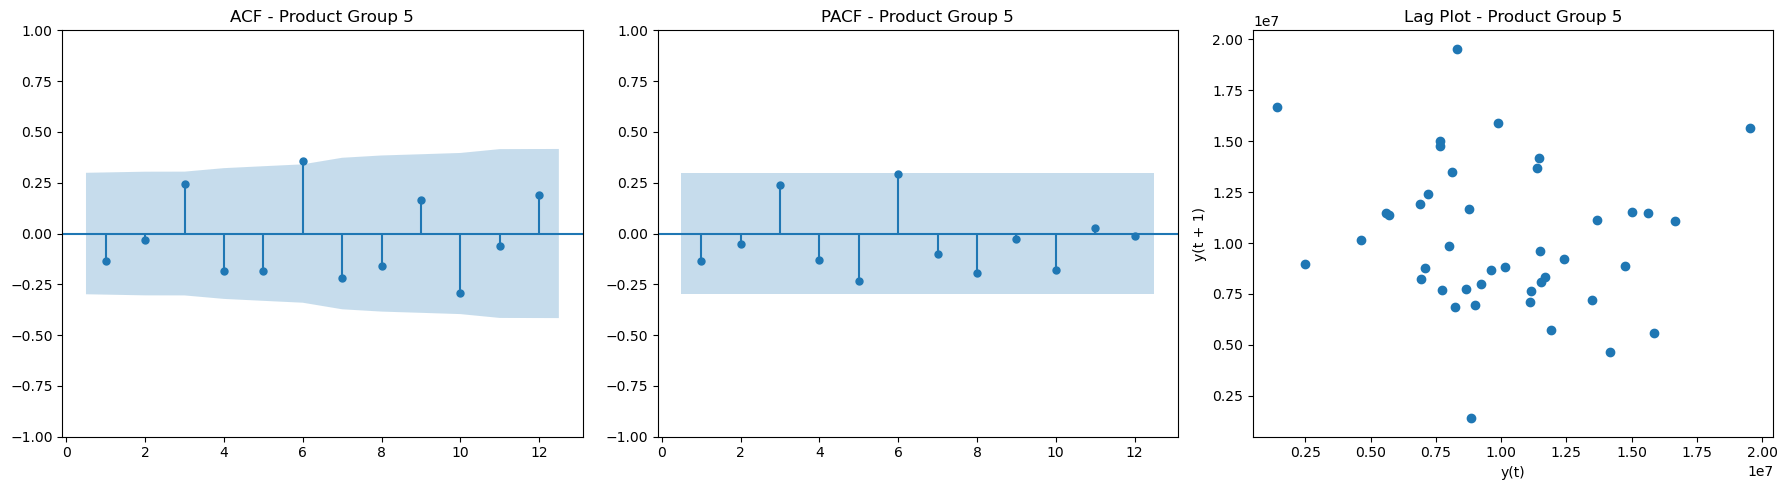

In [74]:
plot_acf_pacf(sales_agg5, product_group=5, max_lag=12)

## Feature selection

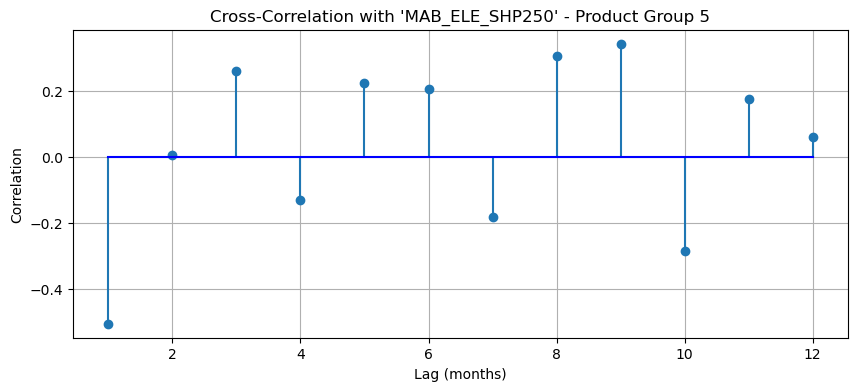

Selected Features for Product Group:
['MAB_ELE_SHP250']


In [75]:
relevant_corr_5, selected_features_5 = plot_cross_correlation(
    sales_df=sales_agg5,
    market_df=df_market,
    product_group=5,
    max_lag=12,
    threshold=0.5
)

### Auto correlation

In [76]:
filtered_info_market = info_market[info_market['Index Code'].isin(selected_features_5)]

filtered_info_market

0  Region                               Index Name      Index Code
3  France  Shipments Index Machinery & Electricals  MAB_ELE_SHP250

# Product Group 6

In [77]:
sales_agg6 = get_sales_by_product_group(df_sales, product_group=6)
sales_agg6.head()

DATE  Sales_EUR
0 2018-10-01  369231.60
1 2018-11-01  473046.96
2 2018-12-01  999472.69
3 2019-01-01  598874.10
4 2019-02-01  542037.52

In [78]:
shapiro_result6 = shapiro_wilk_test(sales_agg6['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.981259
p-value: 0.697078

✅ The p-value (0.697078) is greater than 0.05.
   We fail to reject the null hypothesis, meaning the data appears normally distributed.



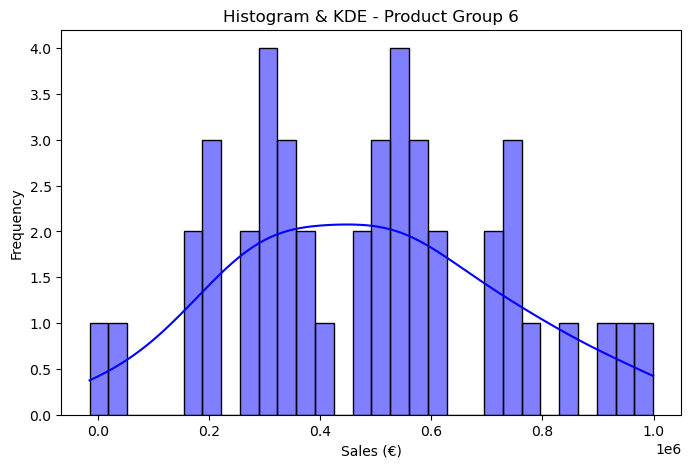

In [79]:
plot_distribution(sales_agg6['Sales_EUR'], product_group=6)

In [80]:
adf_result6 = adf_test(sales_agg6['Sales_EUR'], product_group=6)

Augmented Dickey-Fuller (ADF) Test - Product Group 6
ADF Statistic: -3.477762
p-value: 0.008577
Critical Values:
	1%: -3.601
	5%: -2.935
	10%: -2.606

✅ The p-value (0.008577) is ≤ 0.05.
   We reject the null hypothesis, meaning the data is stationary.



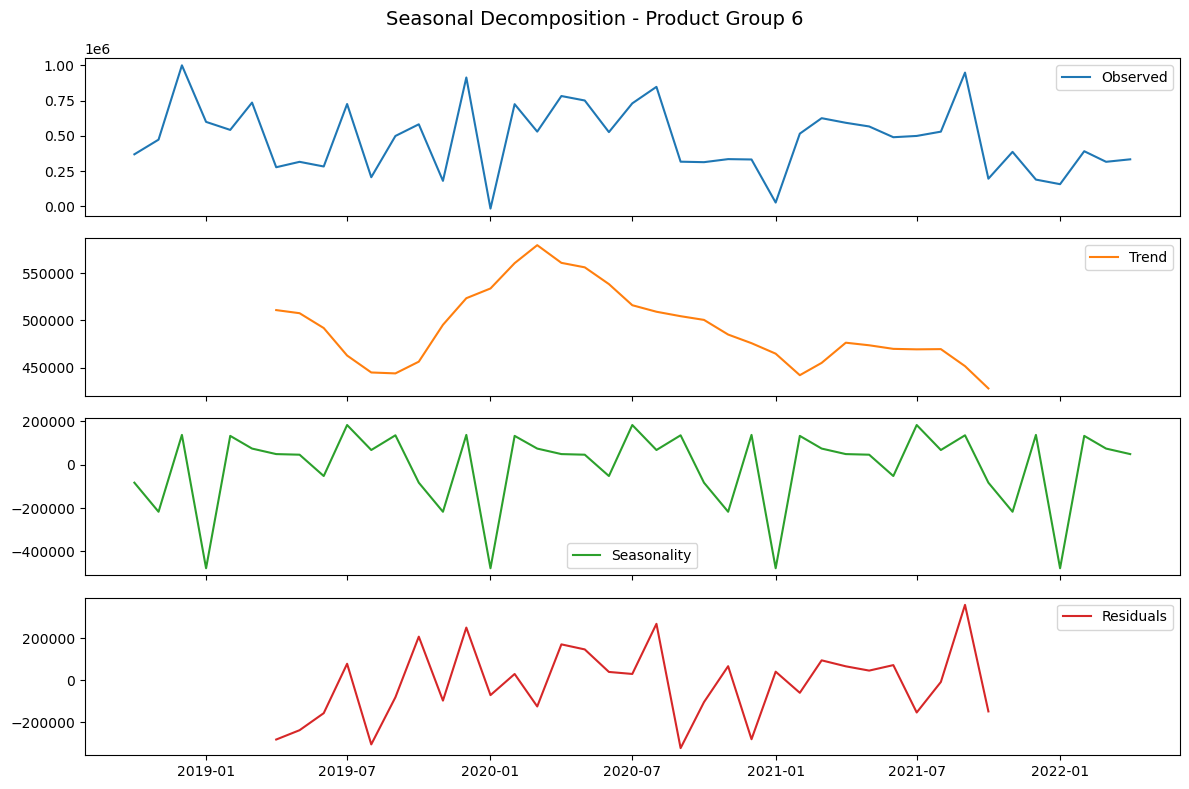

In [81]:
seasonal_decomposition(sales_agg6, product_group=6, date_column='DATE')

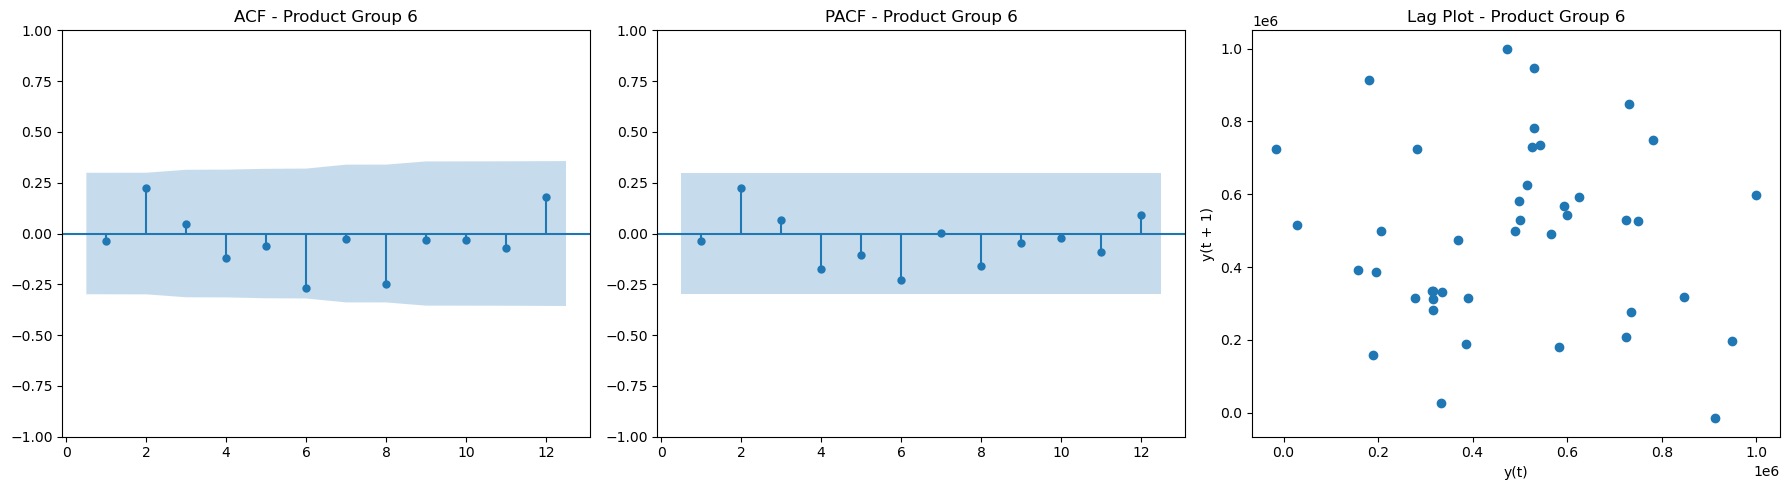

In [82]:
plot_acf_pacf(sales_agg6, product_group=6, max_lag=12)

## Feature selection

### Correlation

In [83]:
relevant_corr_6, selected_features_6 = plot_cross_correlation(
    sales_df=sales_agg6,
    market_df=df_market,
    product_group=6,
    max_lag=12,
    threshold=0.5
)

Selected Features for Product Group:
[]


In [84]:
selected_features_with_lags6, selected_features6 = select_features_via_autocorrelation(sales_agg6, df_market, 'Sales_EUR', target_date_col='DATE', feature_date_col='date', max_lag=10, threshold=0.7)

Selected Features based on ACF: {'MAB_ELE_PRO756': [1], 'MAB_ELE_SHP756': [1, 2], 'MAB_ELE_PRO840': [1], 'RohiBASEMET1000_org': [1, 2, 3], 'RohiENERGY1000_org': [1], 'RohiMETMIN1000_org': [1, 2, 3], 'RohiNATGAS1000_org': [1, 2], 'RohCRUDE_PETRO1000_org': [1], 'RohCOPPER1000_org': [1, 2, 3, 4], 'WKLWEUR840_org': [1, 2], 'PRI27840_org': [1, 2], 'PRI27826_org': [1], 'PRI27380_org': [1, 2], 'PRI27250_org': [1, 2], 'PRI27276_org': [1, 2], 'PRI27156_org': [1, 2, 3], 'PRO28756_org': [1, 2], 'PRO27840_org': [1], 'PRO27756_org': [1]}
number of selected features is 19


In [85]:
selected_feature_goup_6 = list(set(selected_features6 + selected_features_6))

filtered_info_market = info_market[info_market['Index Code'].isin(selected_feature_goup_6)]

filtered_info_market

0           Region                                Index Name  \
10     Switzerland  Production Index Machinery & Electricals   
11     Switzerland   Shipments Index Machinery & Electricals   
14   United States  Production Index Machinery & Electricals   
18           World                      Price of Base Metals   
19           World                           Price of Energy   
20           World               Price of Metals  & Minerals   
21           World                Price of Natural gas index   
22           World               Price of Crude oil, average   
23           World                           Price of Copper   
24   United States                                EUR in LCU   
25   United States                      Electrical equipment   
26  United Kingdom                      Electrical equipment   
27           Italy                      Electrical equipment   
28          France                      Electrical equipment   
29         Germany                      Electrical equipment   
30           China                      Electrical equipment   
33     Switzerland            Machinery and equipment n.e.c.   
39   United States                      Electrical equipment   
41     Switzerland                      Electrical equipment   

0               Index Code  
10          MAB_ELE_PRO756  
11          MAB_ELE_SHP756  
14          MAB_ELE_PRO840  
18     RohiBASEMET1000_org  
19      RohiENERGY1000_org  
20      RohiMETMIN1000_org  
21      RohiNATGAS1000_org  
22  RohCRUDE_PETRO1000_org  
23       RohCOPPER1000_org  
24          WKLWEUR840_org  
25            PRI27840_org  
26            PRI27826_org  
27            PRI27380_org  
28            PRI27250_org  
29            PRI27276_org  
30            PRI27156_org  
33            PRO28756_org  
39            PRO27840_org  
41            PRO27756_org

# Product Group 8

In [86]:
sales_agg8 = get_sales_by_product_group(df_sales, product_group=8)
sales_agg8.head()

DATE  Sales_EUR
0 2018-10-01  586052.74
1 2018-11-01  526292.77
2 2018-12-01  271490.71
3 2019-01-01  381400.15
4 2019-02-01  368475.57

In [87]:
shapiro_result8 = shapiro_wilk_test(sales_agg8['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.888547
p-value: 0.000572

❌ The p-value (0.000572) is less than 0.05.
   We reject the null hypothesis, meaning the data is not normally distributed.



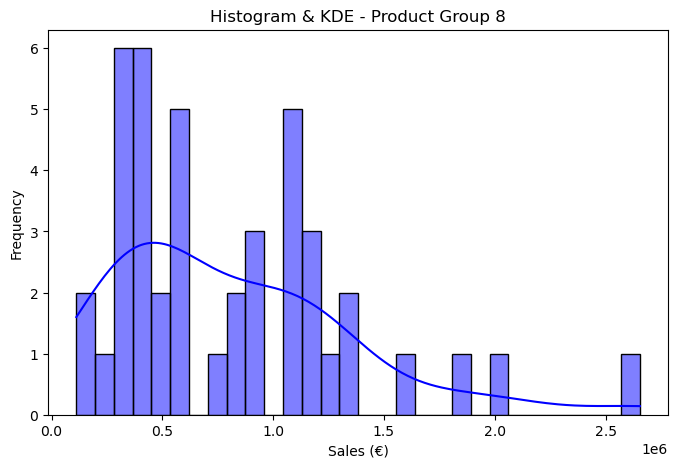

In [88]:
plot_distribution(sales_agg8['Sales_EUR'], product_group=8)

In [89]:
adf_result8 = adf_test(sales_agg8['Sales_EUR'], product_group=8)

Augmented Dickey-Fuller (ADF) Test - Product Group 8
ADF Statistic: 2.340859
p-value: 0.998980
Critical Values:
	1%: -3.627
	5%: -2.946
	10%: -2.612

❌ The p-value (0.998980) is > 0.05.
   We fail to reject the null hypothesis, meaning the data is non-stationary.



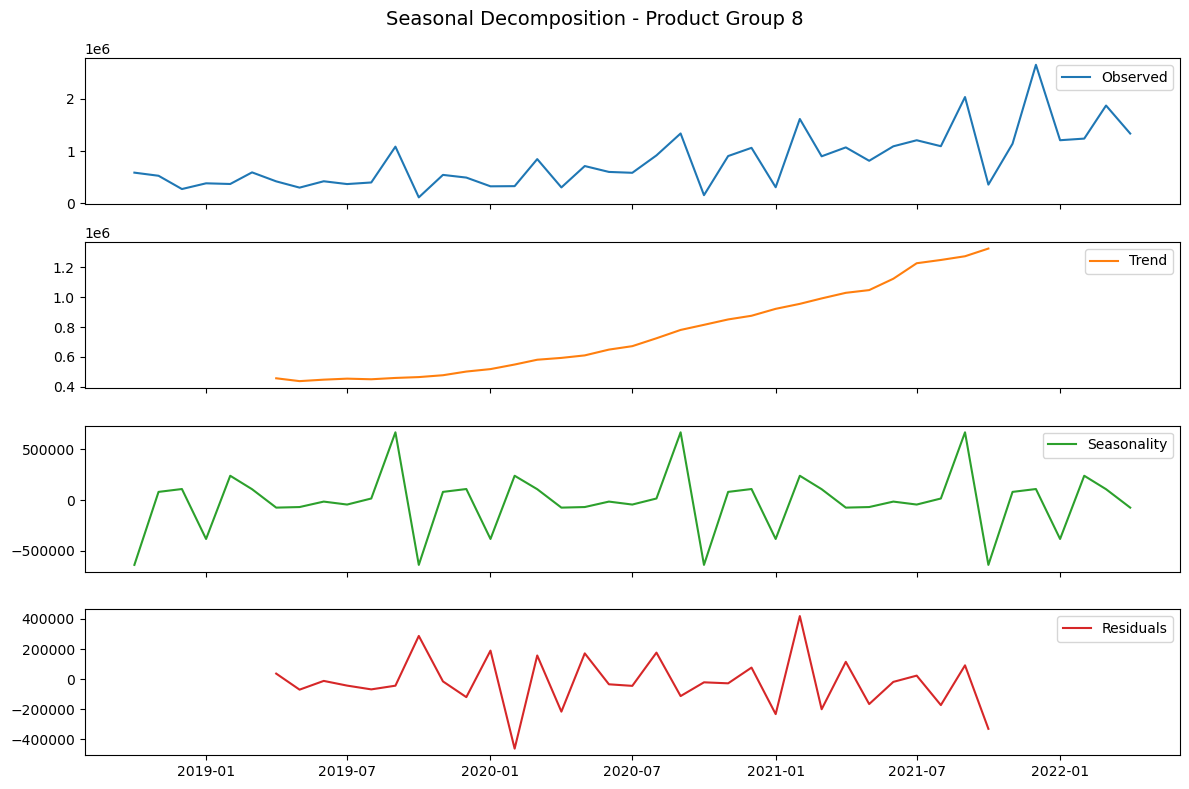

In [90]:
seasonal_decomposition(sales_agg8, product_group=8, date_column='DATE')

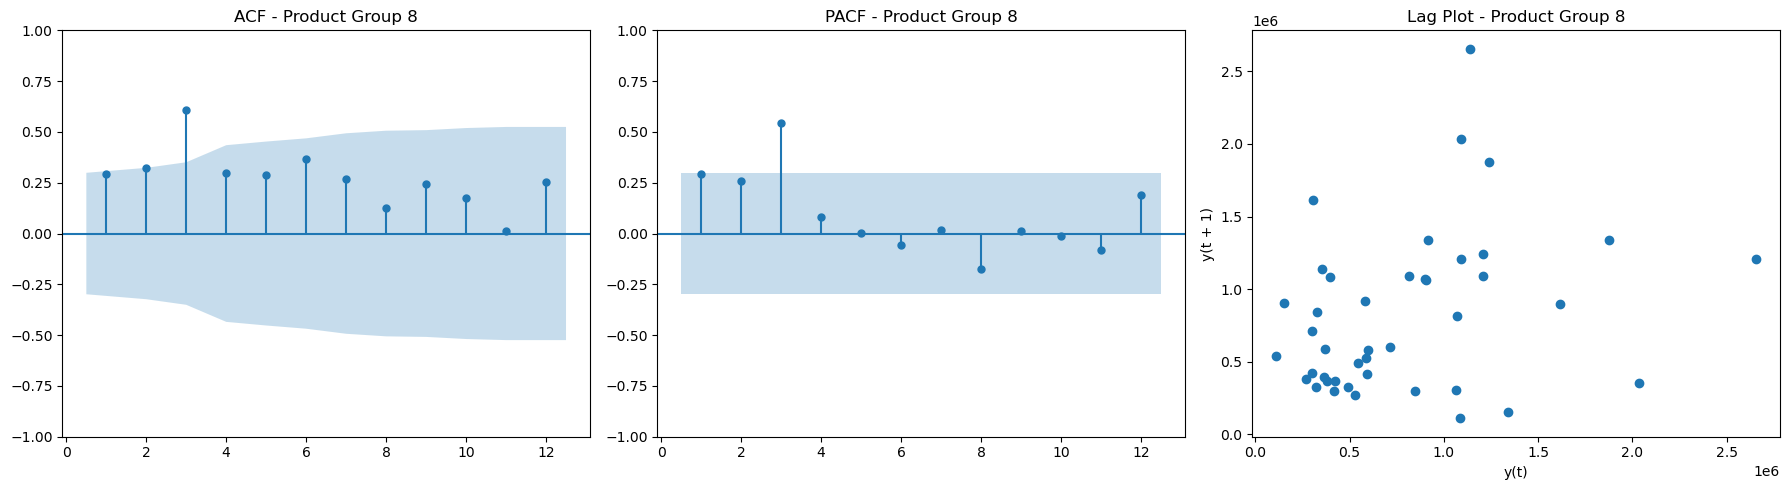

In [91]:
plot_acf_pacf(sales_agg8, product_group=8, max_lag=12)

## Feature seletion

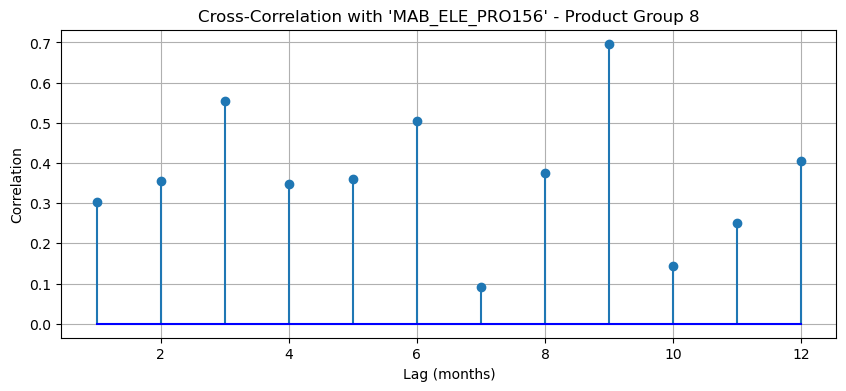

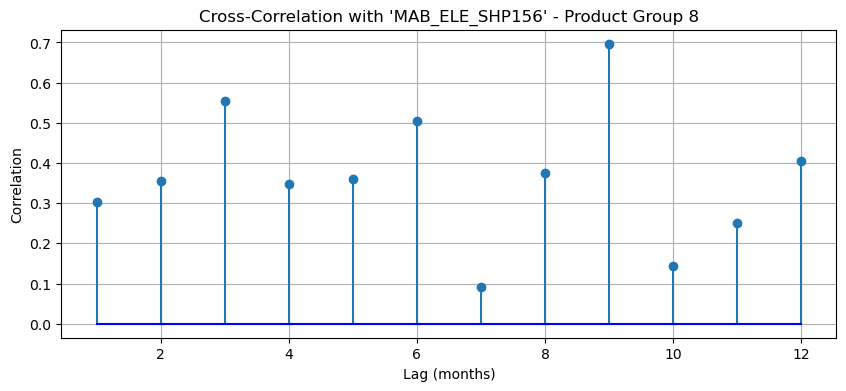

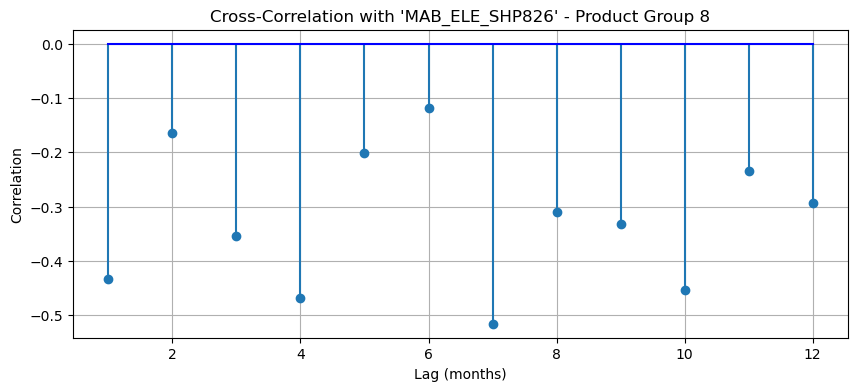

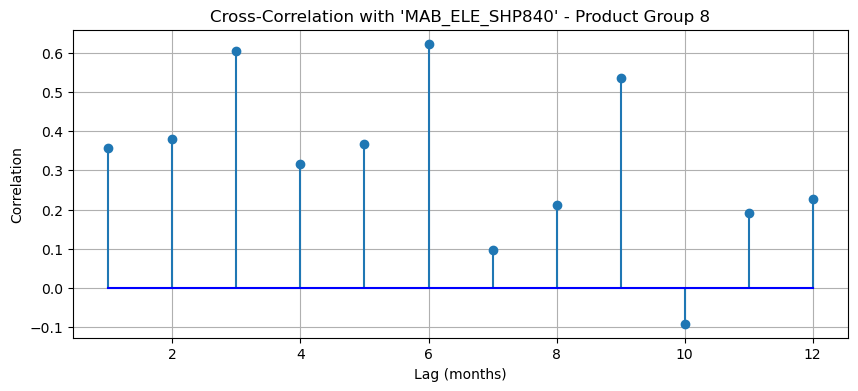

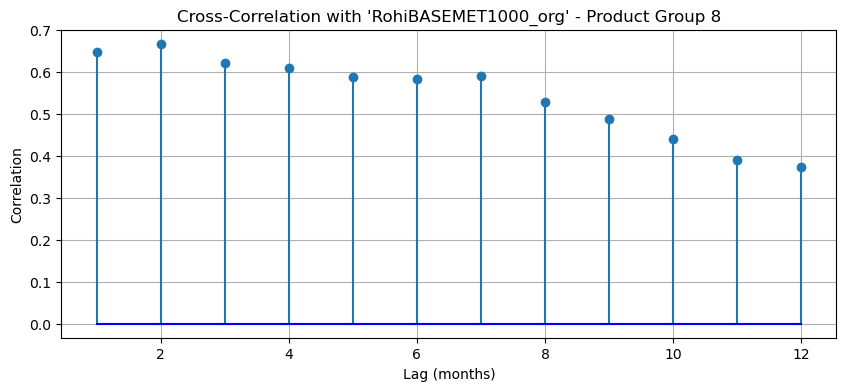

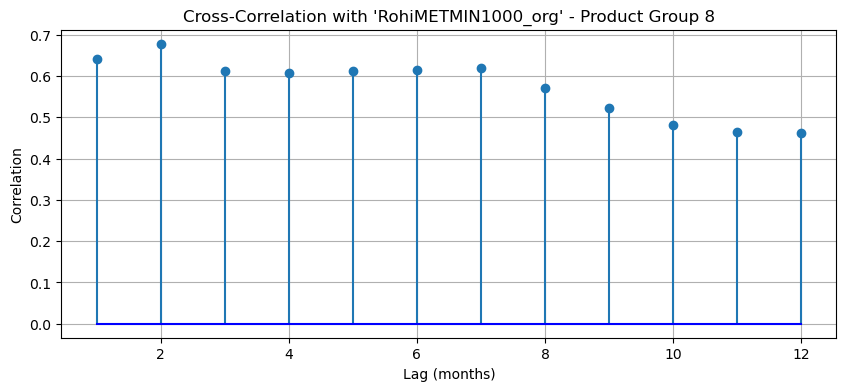

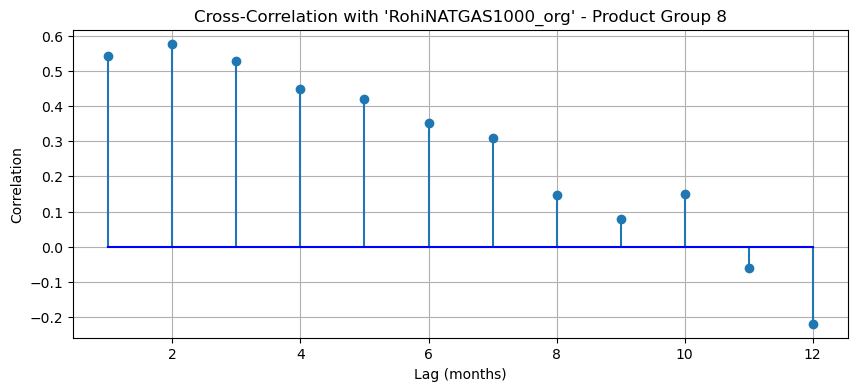

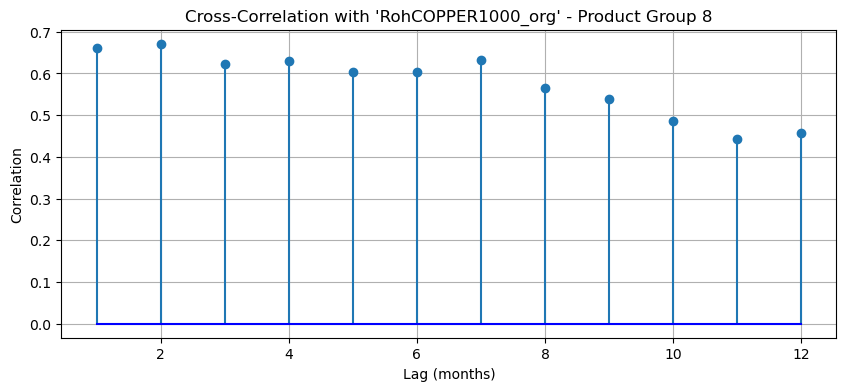

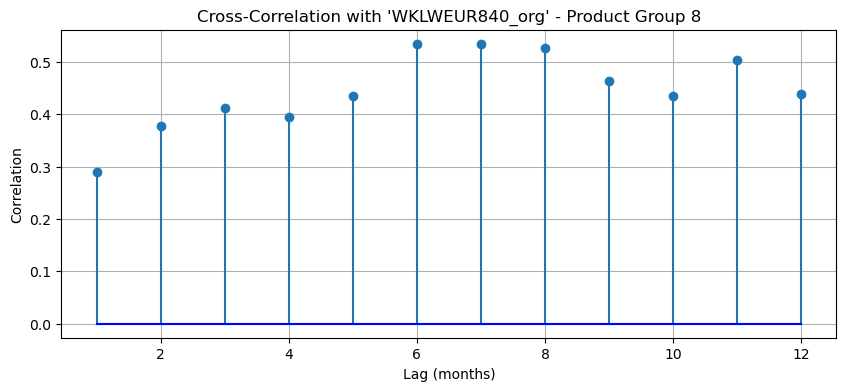

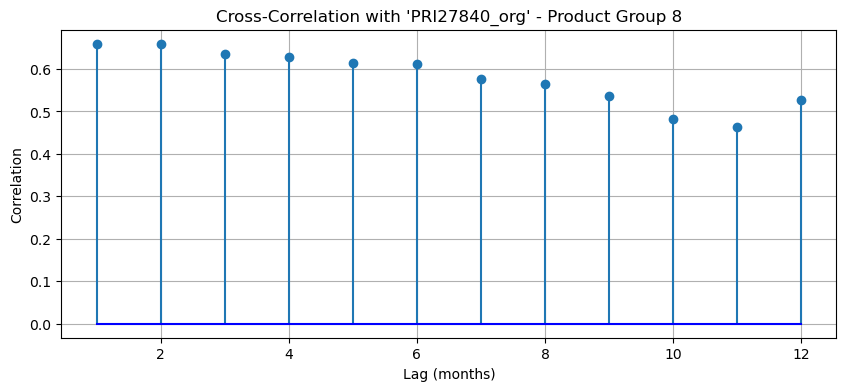

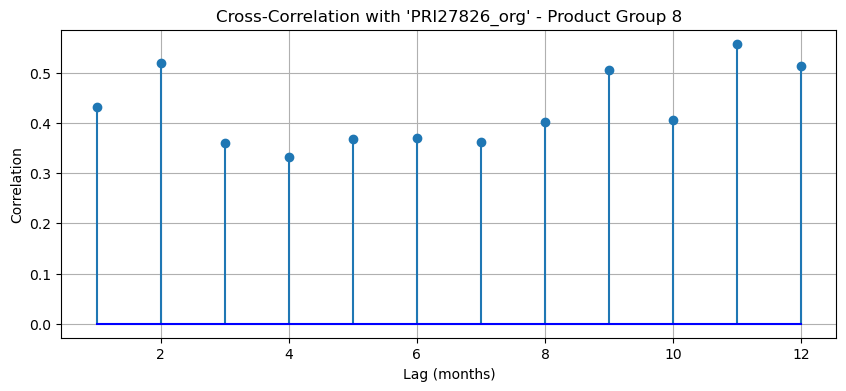

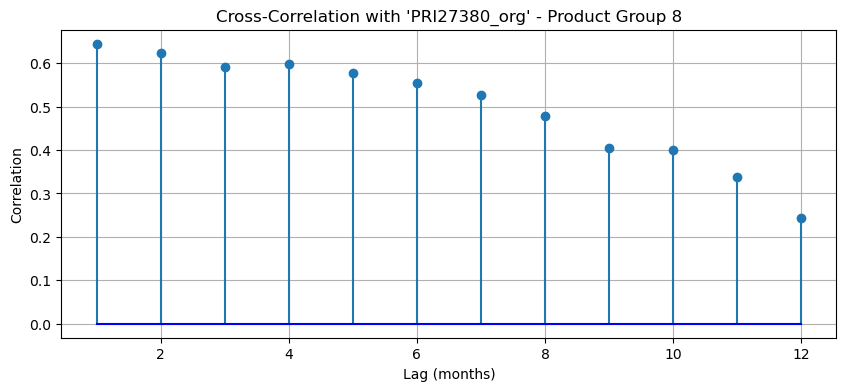

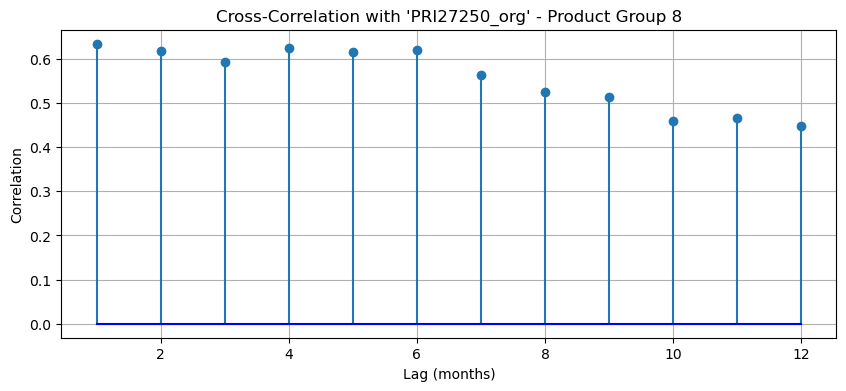

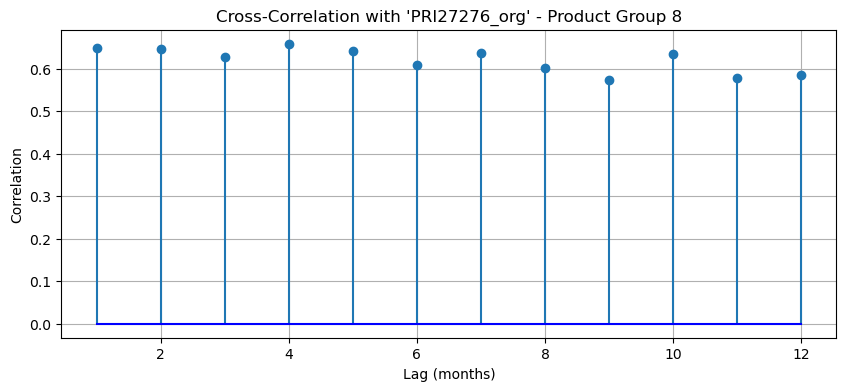

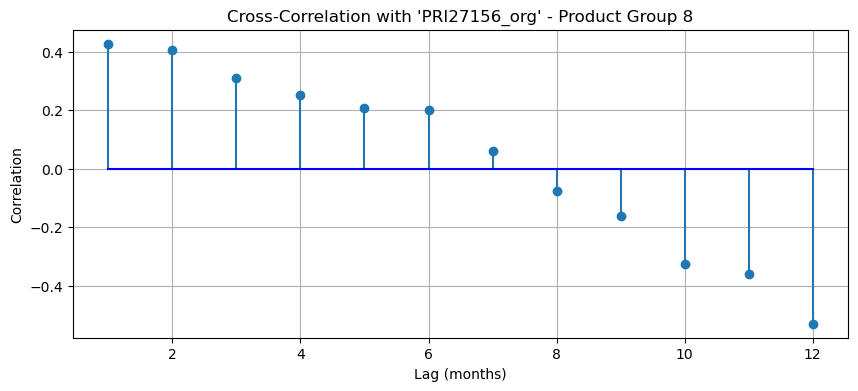

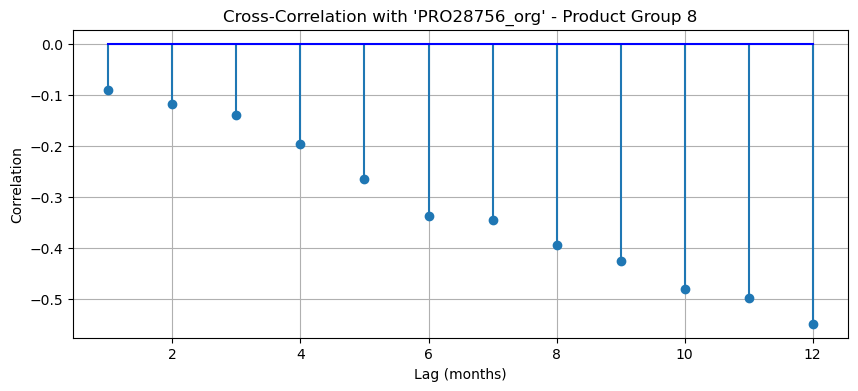

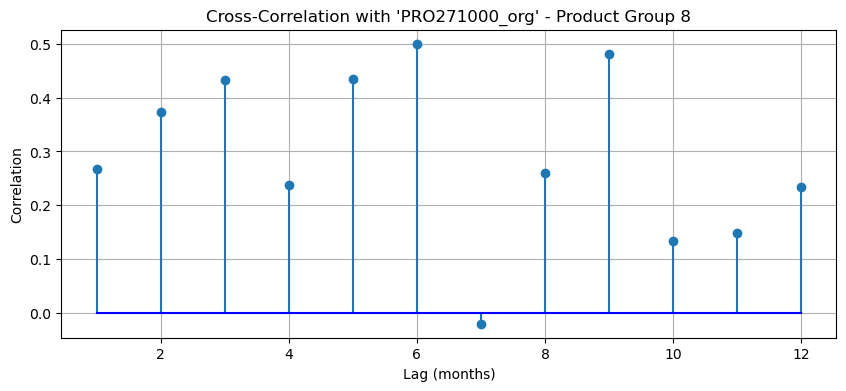

Selected Features for Product Group:
['MAB_ELE_PRO156', 'MAB_ELE_SHP156', 'MAB_ELE_SHP826', 'MAB_ELE_SHP840', 'RohiBASEMET1000_org', 'RohiMETMIN1000_org', 'RohiNATGAS1000_org', 'RohCOPPER1000_org', 'WKLWEUR840_org', 'PRI27840_org', 'PRI27826_org', 'PRI27380_org', 'PRI27250_org', 'PRI27276_org', 'PRI27156_org', 'PRO28756_org', 'PRO271000_org']


In [92]:
relevant_corr_8, selected_features_8 = plot_cross_correlation(
    sales_df=sales_agg8,
    market_df=df_market,
    product_group=8,
    max_lag=12,
    threshold=0.5
)

### Auto correlation

In [93]:
filtered_info_market = info_market[info_market['Index Code'].isin(selected_features_8)]

filtered_info_market

0           Region                                Index Name  \
0            China  Production Index Machinery & Electricals   
1            China   Shipments Index Machinery & Electricals   
13  United Kingdom   Shipments Index Machinery & Electricals   
15   United States   Shipments Index Machinery & Electricals   
18           World                      Price of Base Metals   
20           World               Price of Metals  & Minerals   
21           World                Price of Natural gas index   
23           World                           Price of Copper   
24   United States                                EUR in LCU   
25   United States                      Electrical equipment   
26  United Kingdom                      Electrical equipment   
27           Italy                      Electrical equipment   
28          France                      Electrical equipment   
29         Germany                      Electrical equipment   
30           China                      Electrical equipment   
33     Switzerland            Machinery and equipment n.e.c.   
40           World                      Electrical equipment   

0            Index Code  
0        MAB_ELE_PRO156  
1        MAB_ELE_SHP156  
13       MAB_ELE_SHP826  
15       MAB_ELE_SHP840  
18  RohiBASEMET1000_org  
20   RohiMETMIN1000_org  
21   RohiNATGAS1000_org  
23    RohCOPPER1000_org  
24       WKLWEUR840_org  
25         PRI27840_org  
26         PRI27826_org  
27         PRI27380_org  
28         PRI27250_org  
29         PRI27276_org  
30         PRI27156_org  
33         PRO28756_org  
40        PRO271000_org

### Differencing Necessary

the sales data was **non-stationary**, likely due to a trend. Stationarity is important for forecasting models, which assume constant statistical properties over time.  

To address this, we applied **first-order differencing**, which removes trends by converting absolute sales values into **changes over time**

This transformation **stabilized the mean** and removed trend-based dependencies.


In [94]:
# First-Order Differencing (Removes Trend)
sales_agg8['Sales_EUR_Diff'] = sales_agg8['Sales_EUR'].diff()

In [95]:
# Drop the missing values resulted from differencing (the first row, that did not have a previous value to subtract)
sales_agg8 = sales_agg8.dropna(subset=['Sales_EUR_Diff'])

In [96]:
# Retest ADF after differencing
adf_result8_diff = adf_test(sales_agg8['Sales_EUR_Diff'], product_group=8)

Augmented Dickey-Fuller (ADF) Test - Product Group 8
ADF Statistic: -4.873763
p-value: 0.000039
Critical Values:
	1%: -3.627
	5%: -2.946
	10%: -2.612

✅ The p-value (0.000039) is ≤ 0.05.
   We reject the null hypothesis, meaning the data is stationary.



# Product Group 9

In [97]:
sales_agg9 = get_sales_by_product_group(df_sales, product_group=9)
sales_agg9.head()

DATE  Sales_EUR
0 2018-10-01    3219.32
1 2018-11-01    1875.90
2 2018-12-01       0.00
3 2019-01-01    1487.00
4 2019-02-01    3234.28

In [98]:
shapiro_result9 = shapiro_wilk_test(sales_agg9['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.812044
p-value: 0.000007

❌ The p-value (0.000007) is less than 0.05.
   We reject the null hypothesis, meaning the data is not normally distributed.



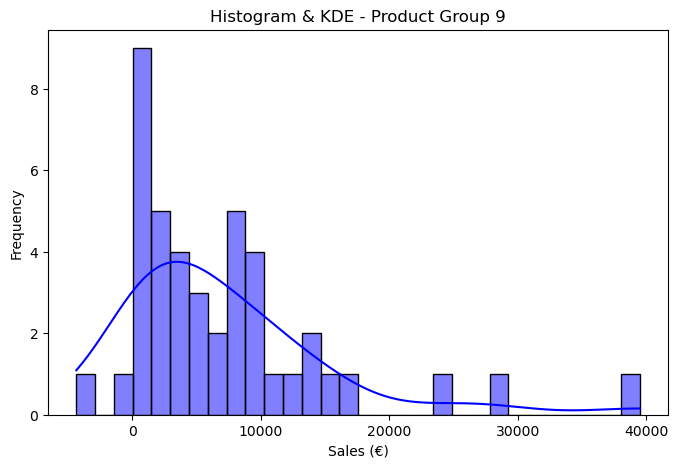

In [99]:
plot_distribution(sales_agg9['Sales_EUR'], product_group=9)

In [100]:
adf_result9 = adf_test(sales_agg9['Sales_EUR'], product_group=9)

Augmented Dickey-Fuller (ADF) Test - Product Group 9
ADF Statistic: -7.013494
p-value: 0.000000
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605

✅ The p-value (0.000000) is ≤ 0.05.
   We reject the null hypothesis, meaning the data is stationary.



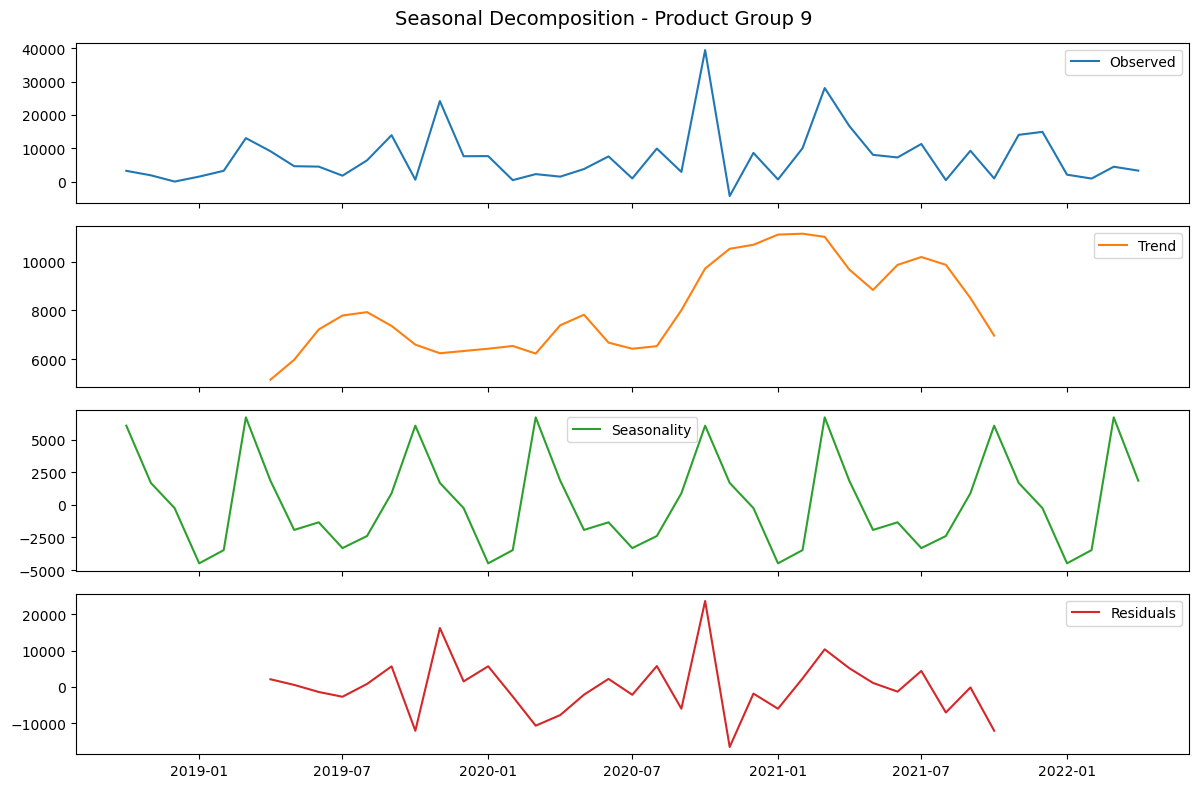

In [101]:
seasonal_decomposition(sales_agg9, product_group=9, date_column='DATE')

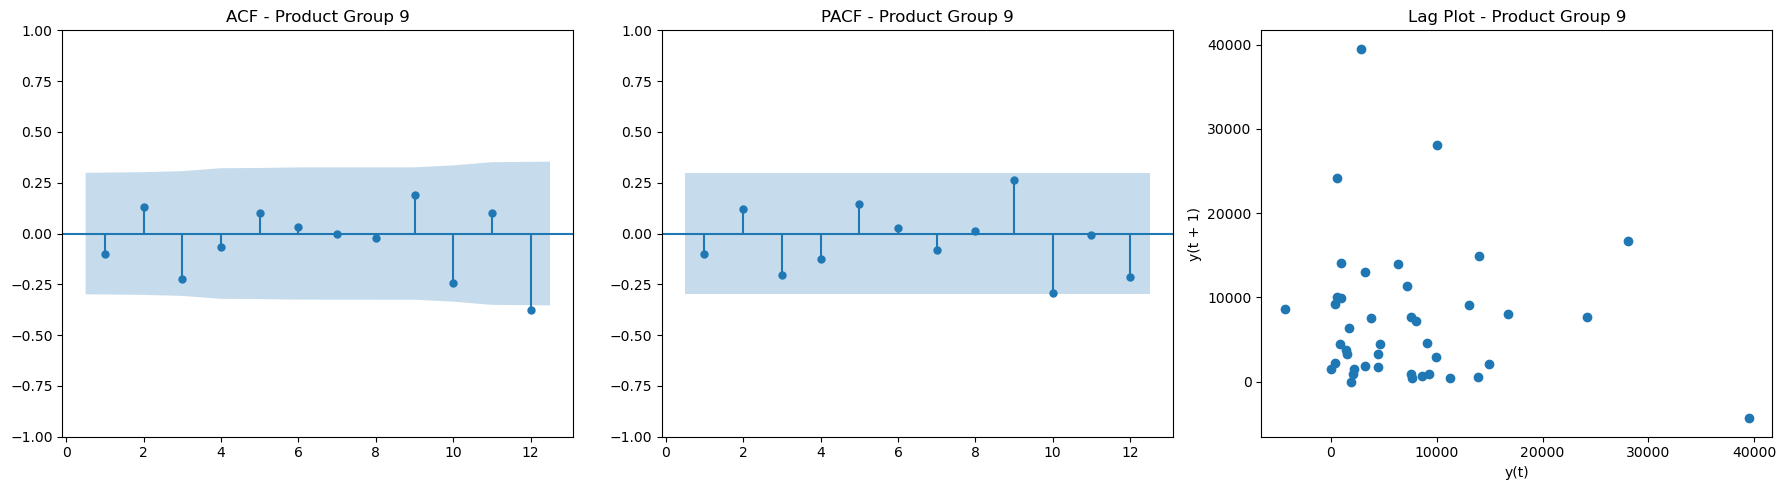

In [102]:
plot_acf_pacf(sales_agg9, product_group=9, max_lag=12)

## Feature selection

In [103]:
relevant_corr_9, selected_features_9 = plot_cross_correlation(
    sales_df=sales_agg9,
    market_df=df_market,
    product_group=9,
    max_lag=12,
    threshold=0.5
)

Selected Features for Product Group:
[]


### Auto correlation

In [104]:
filtered_info_market = info_market[info_market['Index Code'].isin(selected_features_9)]

filtered_info_market

Empty DataFrame
Columns: [Region, Index Name, Index Code]
Index: []

# Product Group 11

In [105]:
sales_agg11 = get_sales_by_product_group(df_sales, product_group=11)
sales_agg11.head()

DATE   Sales_EUR
0 2018-10-01  1021303.50
1 2018-11-01  1898844.80
2 2018-12-01  1226122.00
3 2019-01-01  2216391.74
4 2019-02-01   610456.60

In [106]:
shapiro_result11 = shapiro_wilk_test(sales_agg11['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.935275
p-value: 0.017705

❌ The p-value (0.017705) is less than 0.05.
   We reject the null hypothesis, meaning the data is not normally distributed.



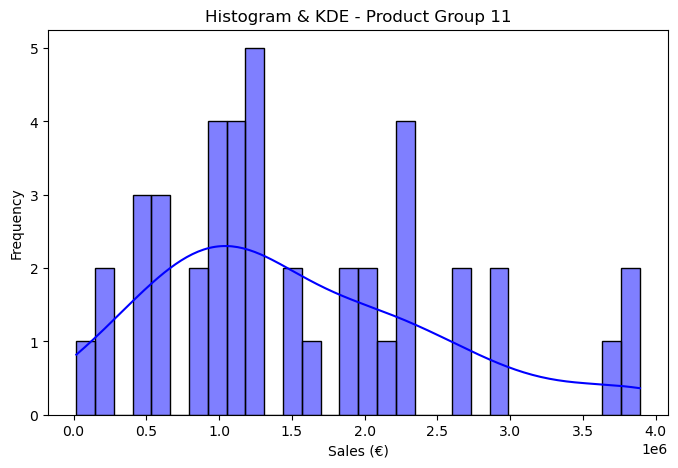

In [107]:
plot_distribution(sales_agg11['Sales_EUR'], product_group=11)

In [108]:
adf_result11 = adf_test(sales_agg11['Sales_EUR'], product_group=11)

Augmented Dickey-Fuller (ADF) Test - Product Group 11
ADF Statistic: -5.577923
p-value: 0.000001
Critical Values:
	1%: -3.601
	5%: -2.935
	10%: -2.606

✅ The p-value (0.000001) is ≤ 0.05.
   We reject the null hypothesis, meaning the data is stationary.



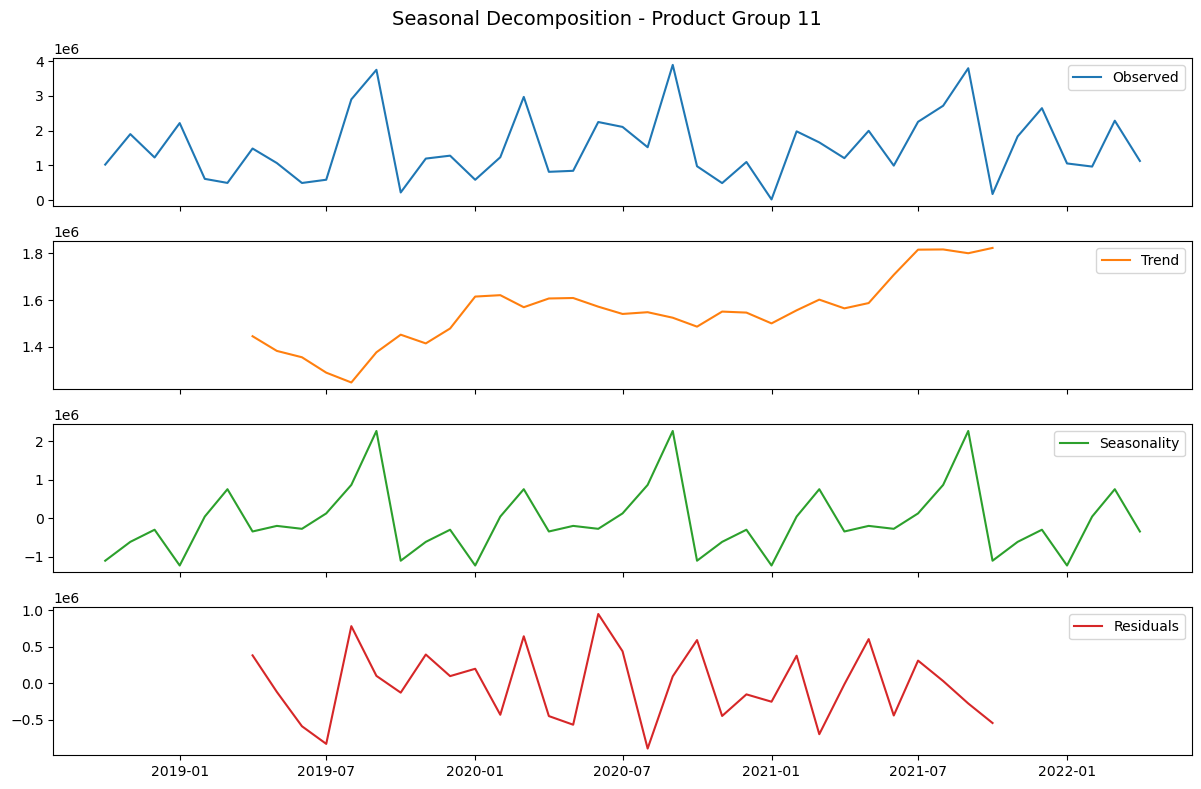

In [109]:
seasonal_decomposition(sales_agg11, product_group=11, date_column='DATE')

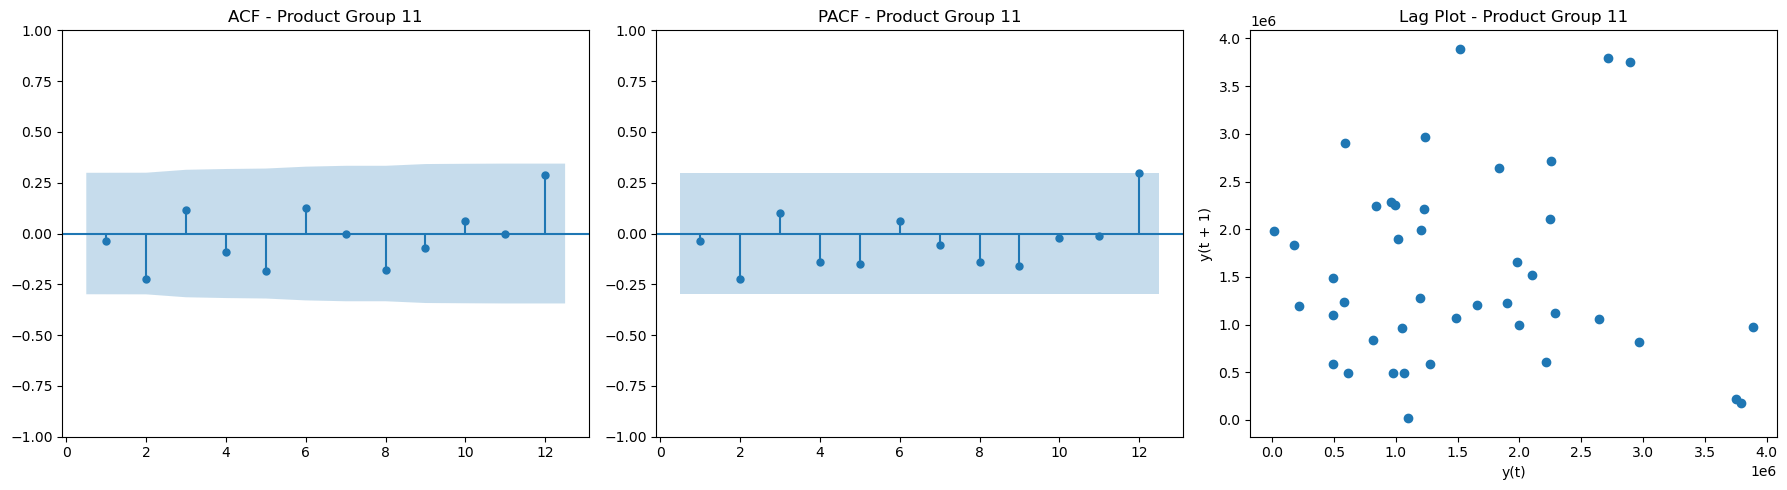

In [110]:
plot_acf_pacf(sales_agg11, product_group=11, max_lag=12)

## Feature selection

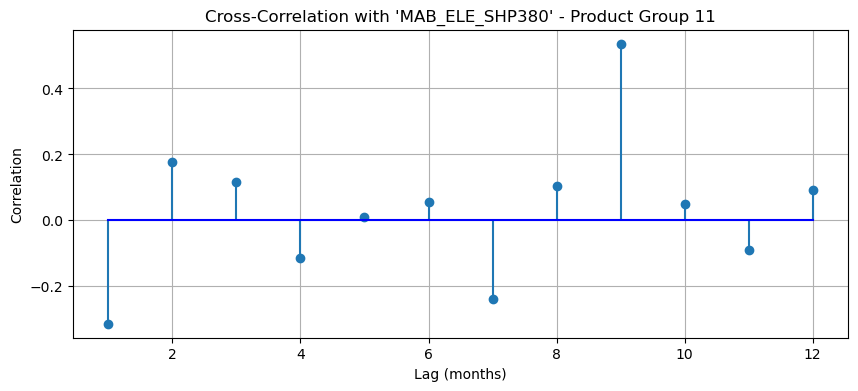

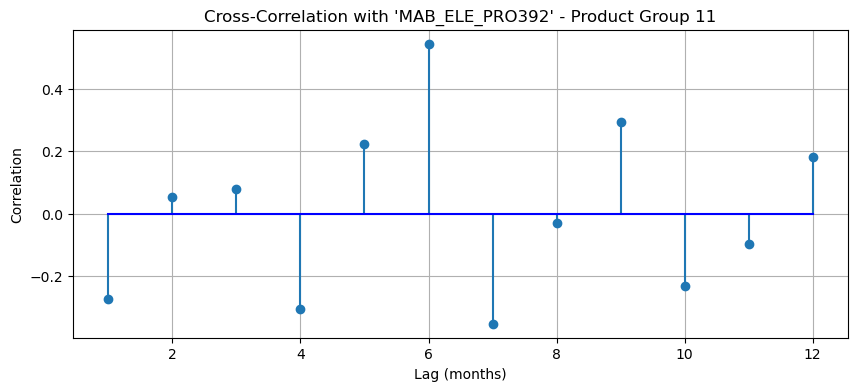

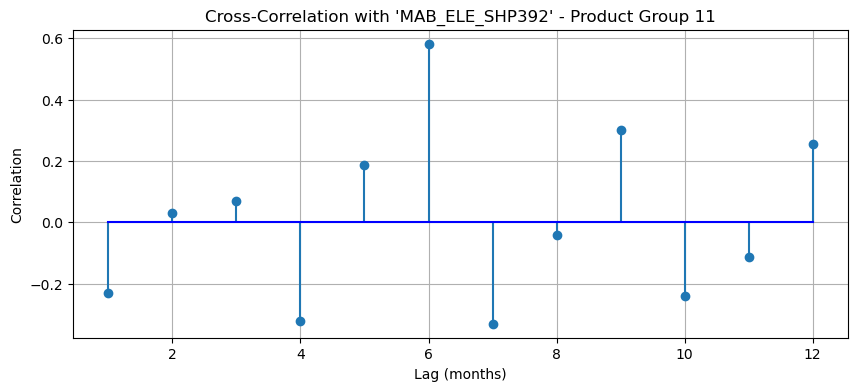

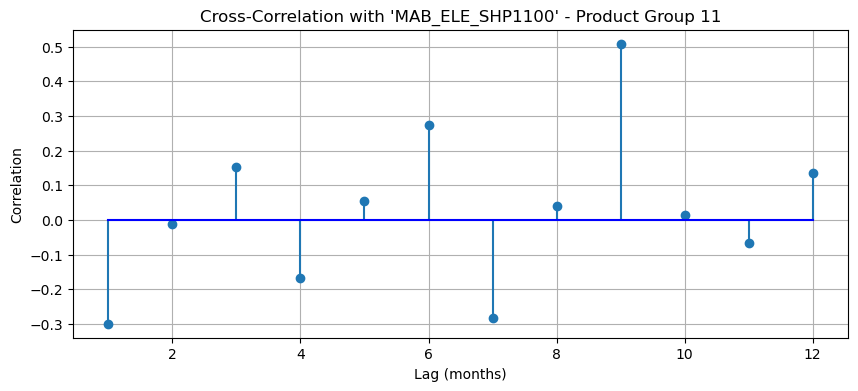

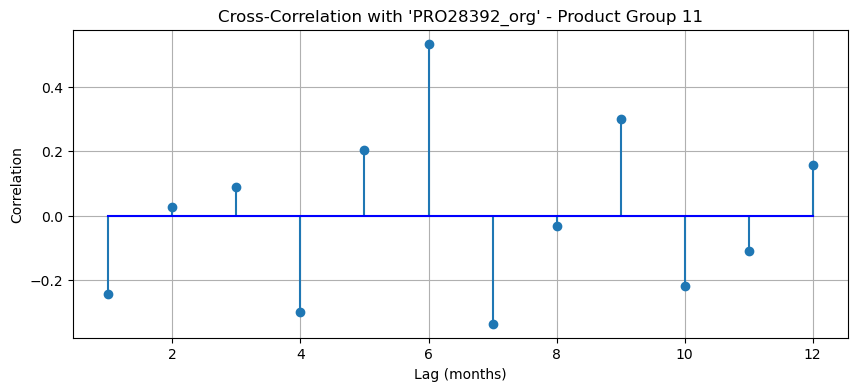

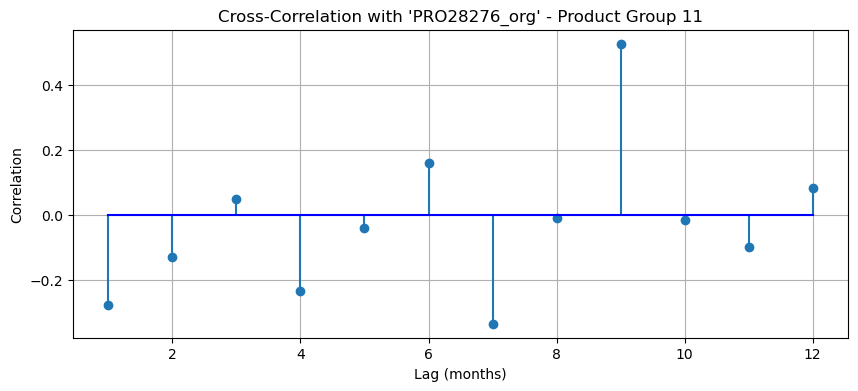

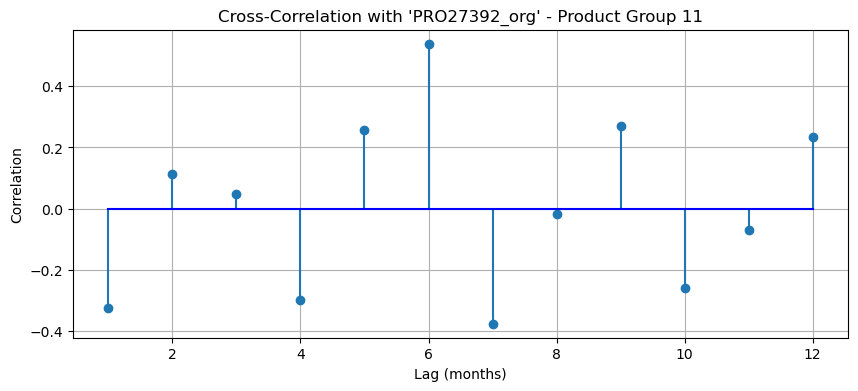

Selected Features for Product Group:
['MAB_ELE_SHP380', 'MAB_ELE_PRO392', 'MAB_ELE_SHP392', 'MAB_ELE_SHP1100', 'PRO28392_org', 'PRO28276_org', 'PRO27392_org']


In [111]:
relevant_corr_11, selected_features_11 = plot_cross_correlation(
    sales_df=sales_agg11,
    market_df=df_market,
    product_group=11,
    max_lag=12,
    threshold=0.5
)

In [112]:
filtered_info_market = info_market[info_market['Index Code'].isin(selected_features_11)]

filtered_info_market

0    Region                                Index Name       Index Code
7     Italy   Shipments Index Machinery & Electricals   MAB_ELE_SHP380
8     Japan  Production Index Machinery & Electricals   MAB_ELE_PRO392
9     Japan   Shipments Index Machinery & Electricals   MAB_ELE_SHP392
17   Europe   Shipments Index Machinery & Electricals  MAB_ELE_SHP1100
36    Japan            Machinery and equipment n.e.c.     PRO28392_org
38  Germany            Machinery and equipment n.e.c.     PRO28276_org
44    Japan                      Electrical equipment     PRO27392_org

# Product Group 12

In [113]:
sales_agg12 = get_sales_by_product_group(df_sales, product_group=12)
sales_agg12.head()

DATE  Sales_EUR
0 2018-10-01   28686.33
1 2018-11-01    1070.00
2 2018-12-01   17880.60
3 2019-01-01   21484.00
4 2019-02-01   34214.74

In [114]:
shapiro_result12 = shapiro_wilk_test(sales_agg12['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.920265
p-value: 0.005472

❌ The p-value (0.005472) is less than 0.05.
   We reject the null hypothesis, meaning the data is not normally distributed.



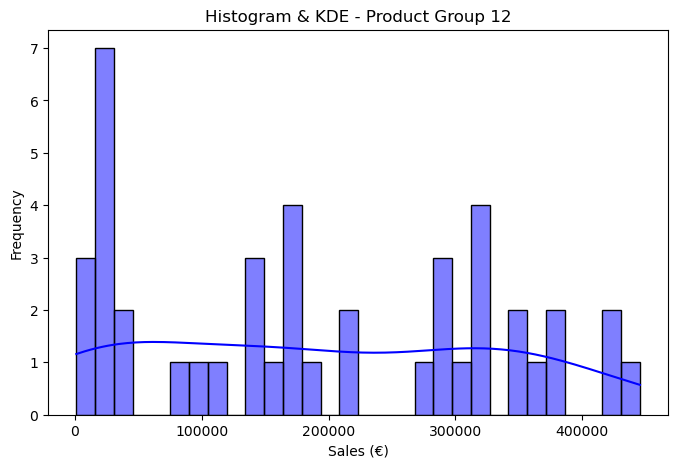

In [115]:
plot_distribution(sales_agg12['Sales_EUR'], product_group=12)

In [116]:
adf_result12 = adf_test(sales_agg12['Sales_EUR'], product_group=12)

Augmented Dickey-Fuller (ADF) Test - Product Group 12
ADF Statistic: -3.869337
p-value: 0.002272
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605

✅ The p-value (0.002272) is ≤ 0.05.
   We reject the null hypothesis, meaning the data is stationary.



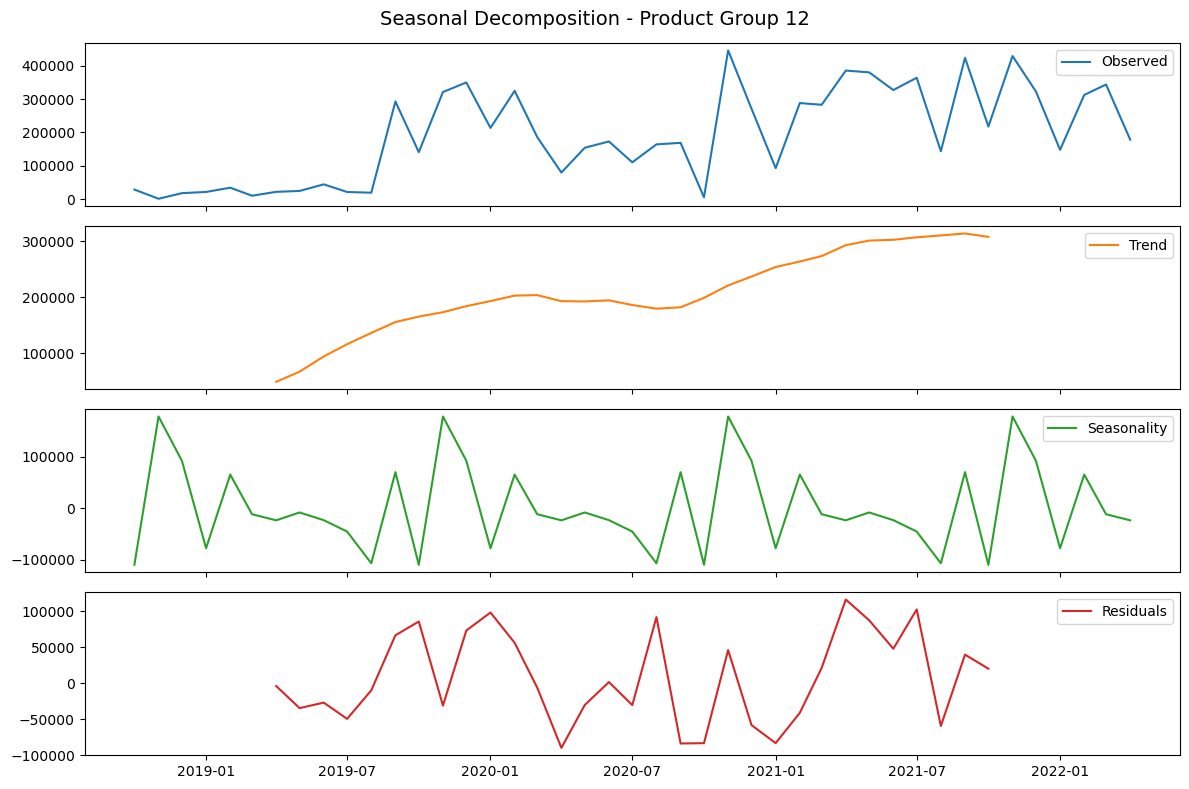

In [117]:
seasonal_decomposition(sales_agg12, product_group=12, date_column='DATE')

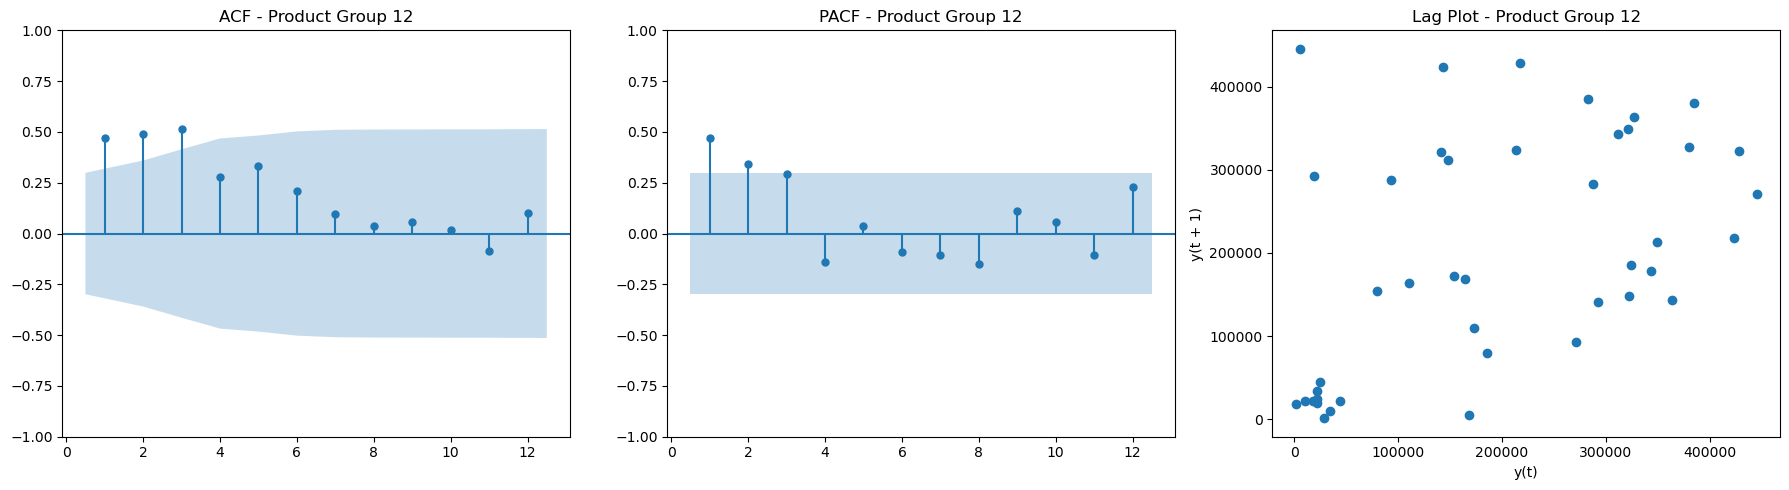

In [118]:
plot_acf_pacf(sales_agg12, product_group=12, max_lag=12)

## Feature selection

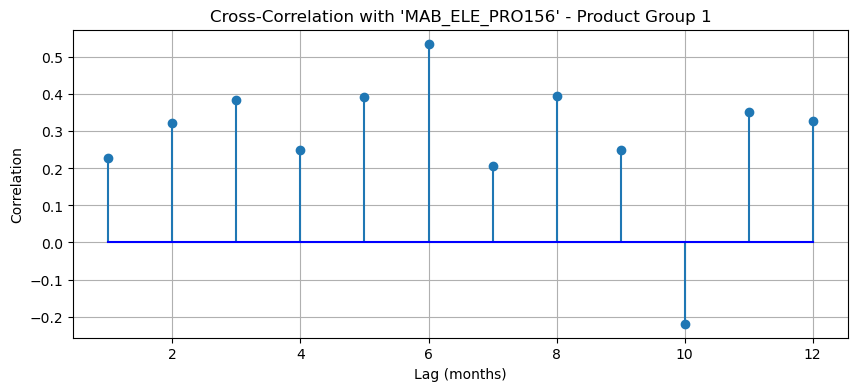

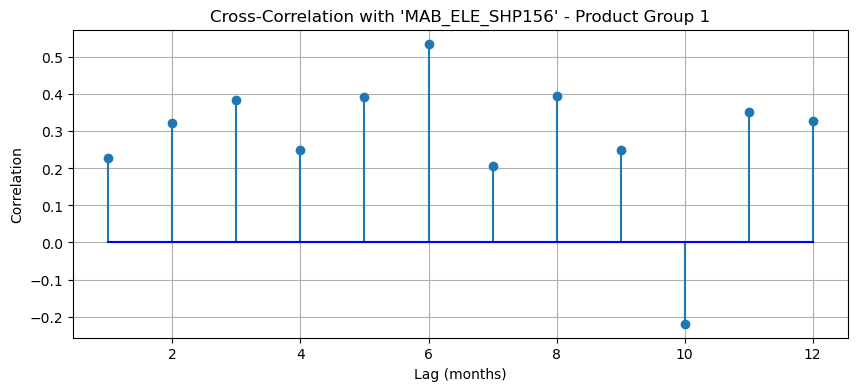

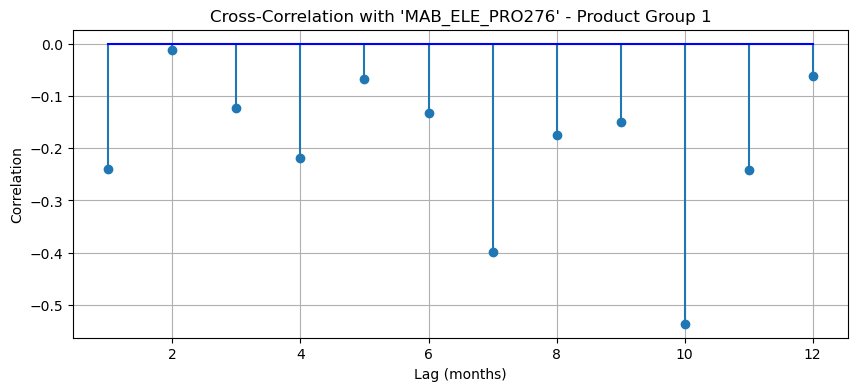

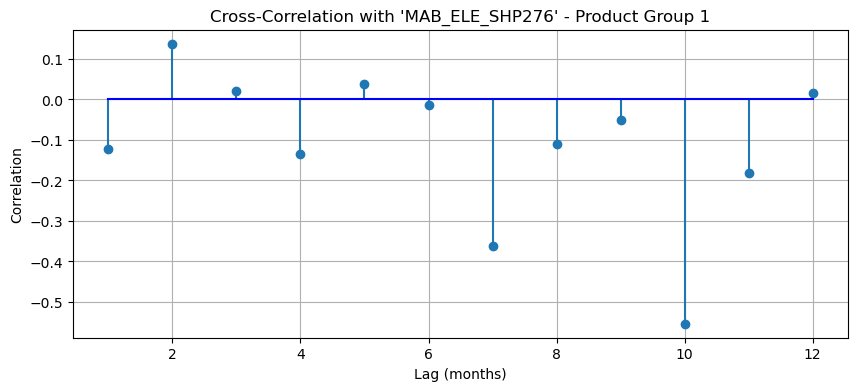

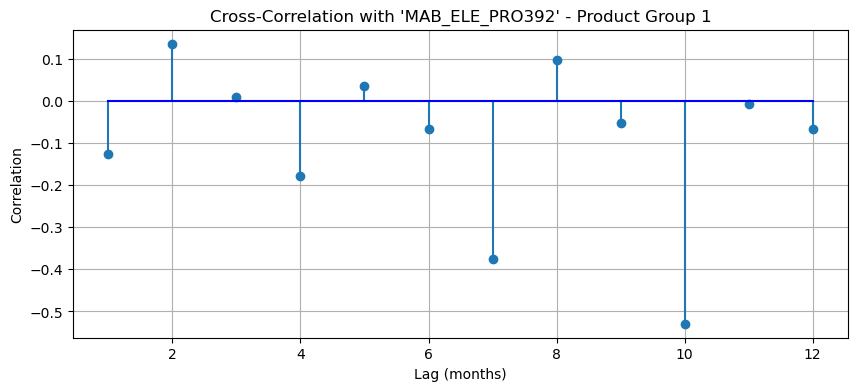

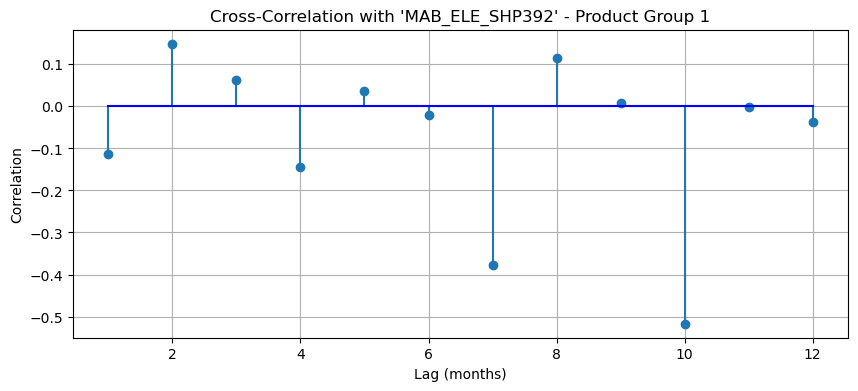

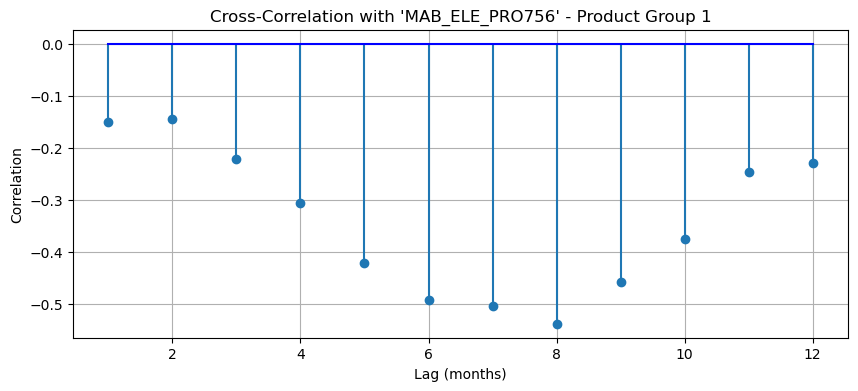

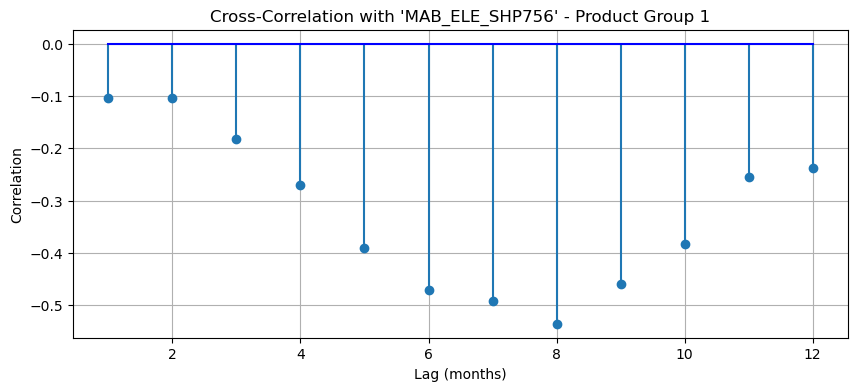

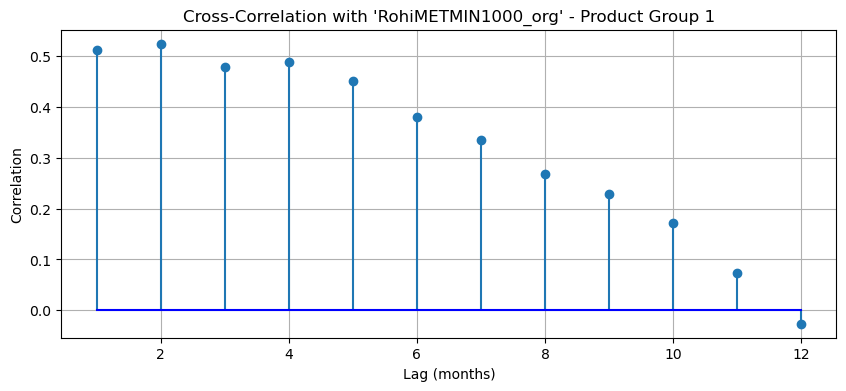

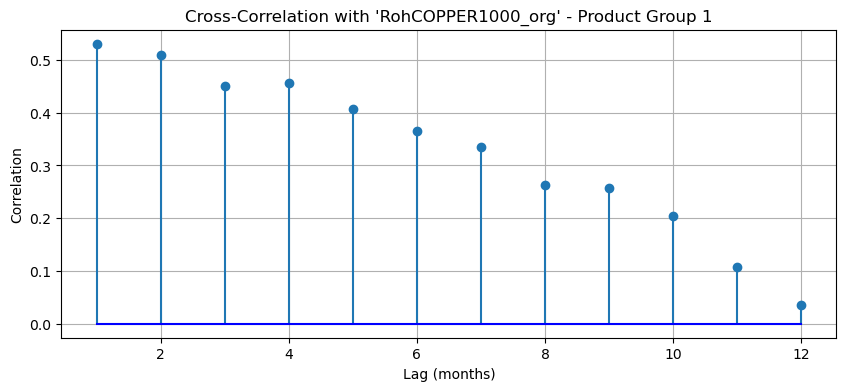

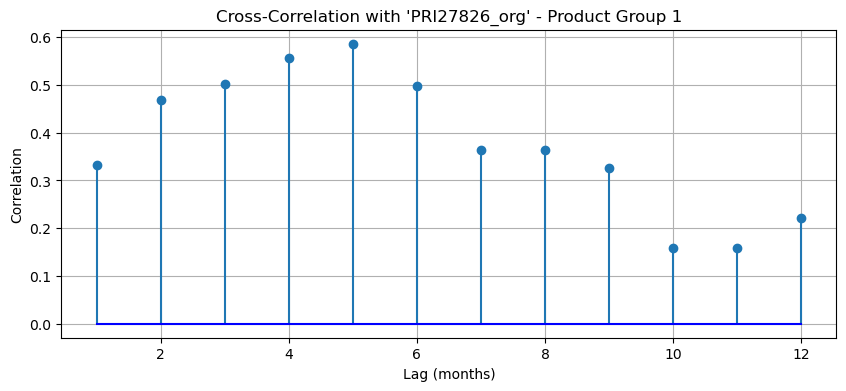

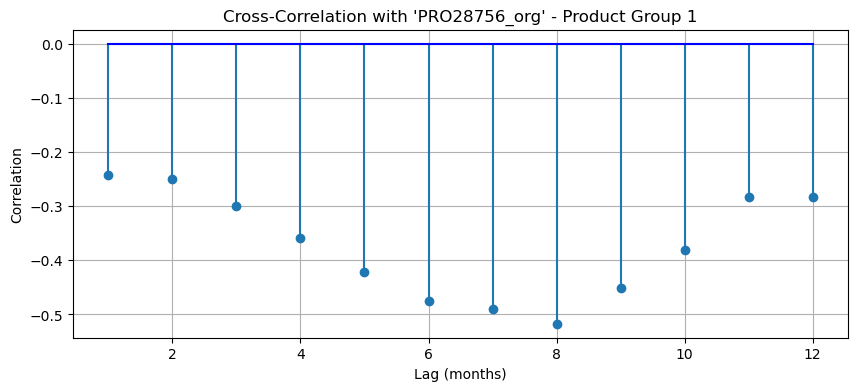

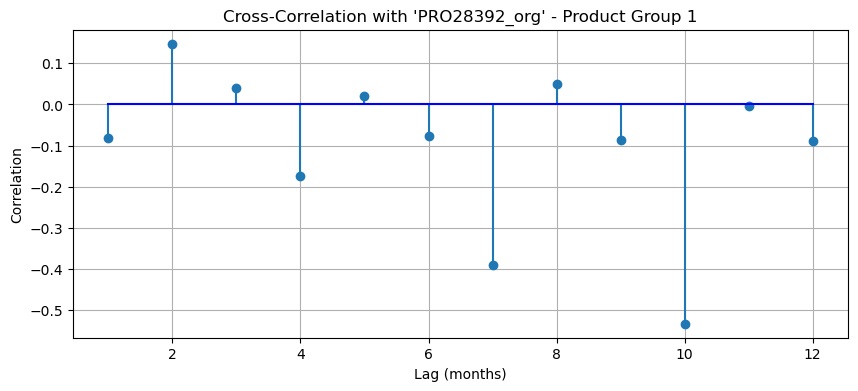

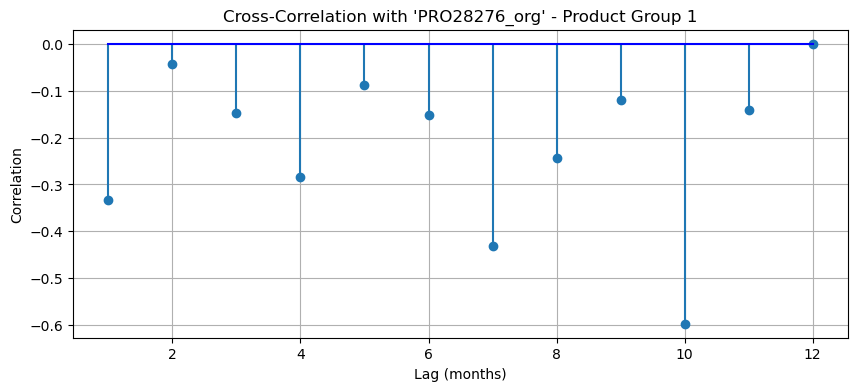

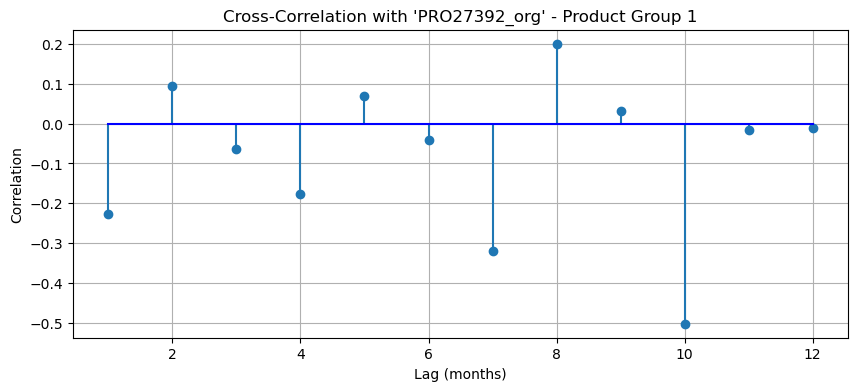

Selected Features for Product Group:
['MAB_ELE_PRO156', 'MAB_ELE_SHP156', 'MAB_ELE_PRO276', 'MAB_ELE_SHP276', 'MAB_ELE_PRO392', 'MAB_ELE_SHP392', 'MAB_ELE_PRO756', 'MAB_ELE_SHP756', 'RohiMETMIN1000_org', 'RohCOPPER1000_org', 'PRI27826_org', 'PRO28756_org', 'PRO28392_org', 'PRO28276_org', 'PRO27392_org']


In [119]:
relevant_corr_12, selected_features_12 = plot_cross_correlation(
    sales_df=sales_agg12,
    market_df=df_market,
    product_group=1,
    max_lag=12,
    threshold=0.5
)

### Auto correlation

In [120]:
filtered_info_market = info_market[info_market['Index Code'].isin(selected_features_12)]

filtered_info_market

0           Region                                Index Name  \
0            China  Production Index Machinery & Electricals   
1            China   Shipments Index Machinery & Electricals   
4          Germany  Production Index Machinery & Electricals   
5          Germany   Shipments Index Machinery & Electricals   
8            Japan  Production Index Machinery & Electricals   
9            Japan   Shipments Index Machinery & Electricals   
10     Switzerland  Production Index Machinery & Electricals   
11     Switzerland   Shipments Index Machinery & Electricals   
20           World               Price of Metals  & Minerals   
23           World                           Price of Copper   
26  United Kingdom                      Electrical equipment   
33     Switzerland            Machinery and equipment n.e.c.   
36           Japan            Machinery and equipment n.e.c.   
38         Germany            Machinery and equipment n.e.c.   
44           Japan                      Electrical equipment   

0           Index Code  
0       MAB_ELE_PRO156  
1       MAB_ELE_SHP156  
4       MAB_ELE_PRO276  
5       MAB_ELE_SHP276  
8       MAB_ELE_PRO392  
9       MAB_ELE_SHP392  
10      MAB_ELE_PRO756  
11      MAB_ELE_SHP756  
20  RohiMETMIN1000_org  
23   RohCOPPER1000_org  
26        PRI27826_org  
33        PRO28756_org  
36        PRO28392_org  
38        PRO28276_org  
44        PRO27392_org

# Product Group 13

In [121]:
sales_agg13 = get_sales_by_product_group(df_sales, product_group=13)
sales_agg13.head()

DATE  Sales_EUR
0 2018-10-01   27666.10
1 2018-11-01   68180.00
2 2018-12-01   15655.18
3 2019-01-01   27198.29
4 2019-02-01   32638.63

In [122]:
shapiro_result13 = shapiro_wilk_test(sales_agg13['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.900989
p-value: 0.001341

❌ The p-value (0.001341) is less than 0.05.
   We reject the null hypothesis, meaning the data is not normally distributed.



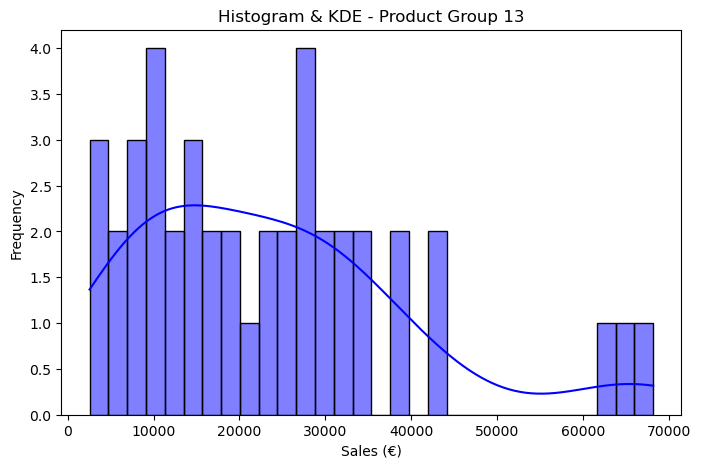

In [123]:
plot_distribution(sales_agg13['Sales_EUR'], product_group=13)

In [124]:
adf_result13 = adf_test(sales_agg13['Sales_EUR'], product_group=13)

Augmented Dickey-Fuller (ADF) Test - Product Group 13
ADF Statistic: -3.254199
p-value: 0.017054
Critical Values:
	1%: -3.606
	5%: -2.937
	10%: -2.607

✅ The p-value (0.017054) is ≤ 0.05.
   We reject the null hypothesis, meaning the data is stationary.



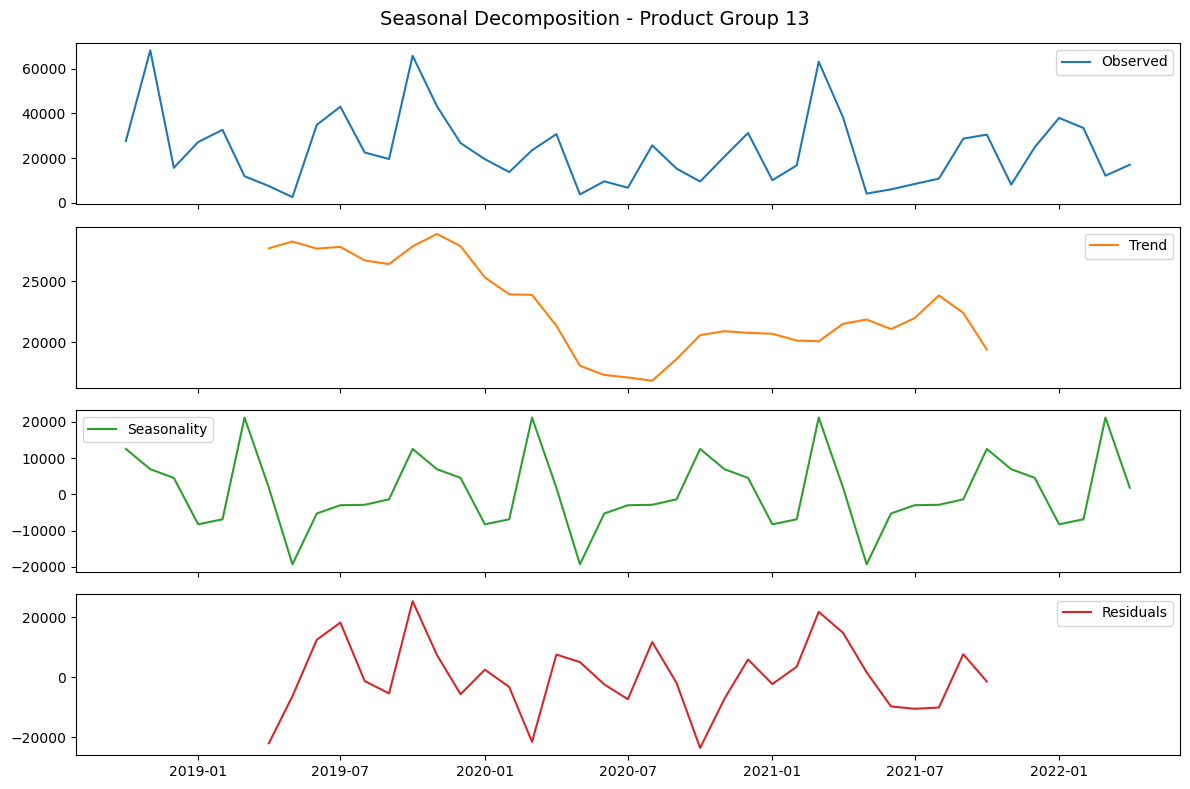

In [125]:
seasonal_decomposition(sales_agg13, product_group=13, date_column='DATE')

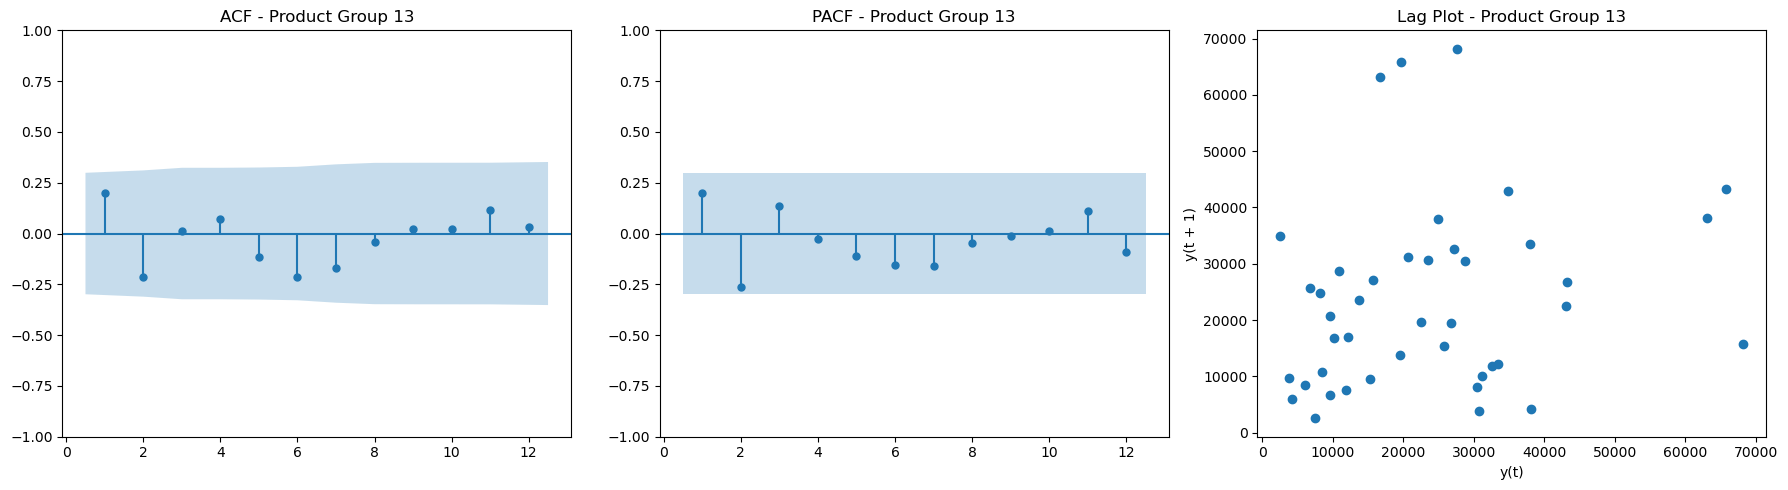

In [126]:
plot_acf_pacf(sales_agg13, product_group=13, max_lag=12)

## Feature selection

In [127]:
relevant_corr_13, selected_features_13 = plot_cross_correlation(
    sales_df=sales_agg13,
    market_df=df_market,
    product_group=1,
    max_lag=13,
    threshold=0.5
)


Selected Features for Product Group:
[]


In [128]:
filtered_info_market = info_market[info_market['Index Code'].isin(selected_features_13)]

filtered_info_market

Empty DataFrame
Columns: [Region, Index Name, Index Code]
Index: []

# Product Group 14

In [129]:
sales_agg14 = get_sales_by_product_group(df_sales, product_group=14)
sales_agg14.head()

DATE  Sales_EUR
0 2018-10-01     5770.0
1 2018-11-01    17130.0
2 2018-12-01        0.0
3 2019-01-01     1686.4
4 2019-02-01    19196.3

In [130]:
shapiro_result14 = shapiro_wilk_test(sales_agg14['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.686922
p-value: 0.000000

❌ The p-value (0.000000) is less than 0.05.
   We reject the null hypothesis, meaning the data is not normally distributed.



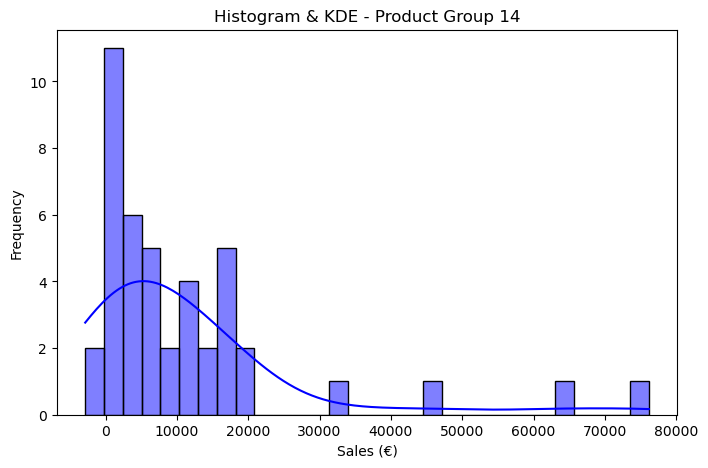

In [131]:
plot_distribution(sales_agg14['Sales_EUR'], product_group=14)

In [132]:
adf_result14 = adf_test(sales_agg14['Sales_EUR'], product_group=14)

Augmented Dickey-Fuller (ADF) Test - Product Group 14
ADF Statistic: -6.871822
p-value: 0.000000
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605

✅ The p-value (0.000000) is ≤ 0.05.
   We reject the null hypothesis, meaning the data is stationary.



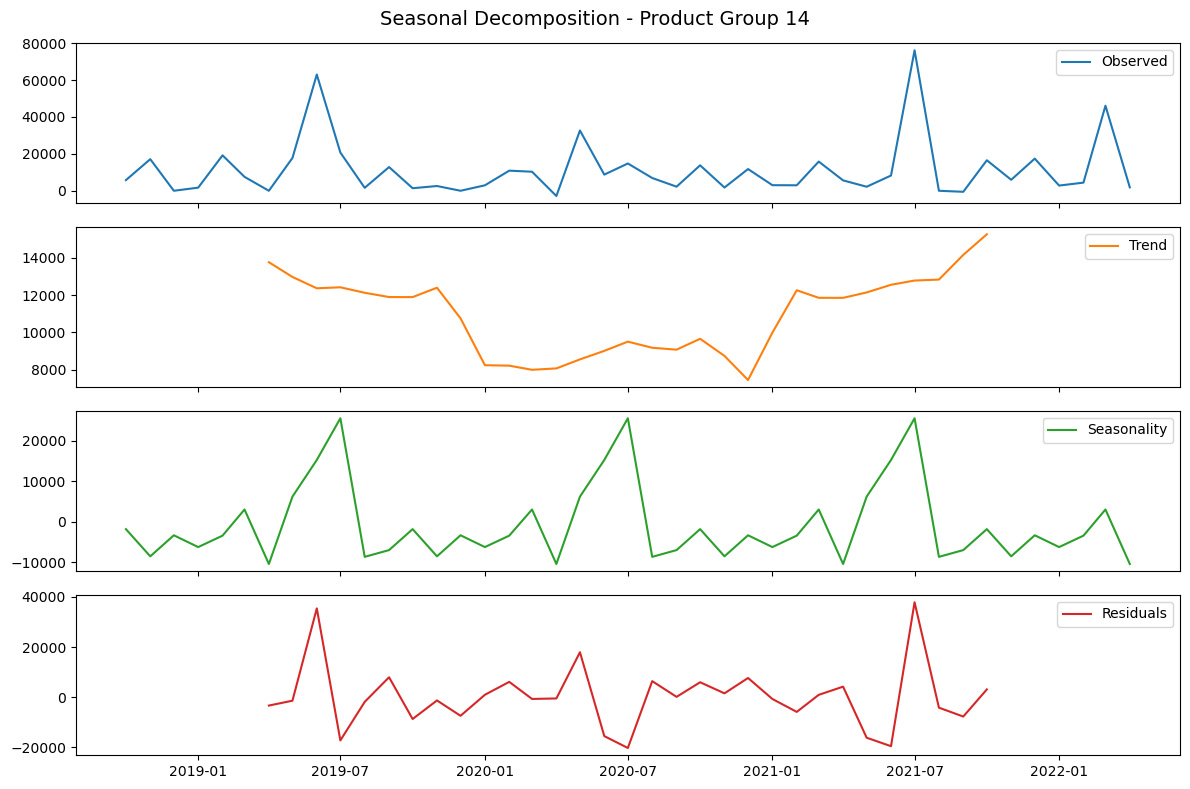

In [133]:
seasonal_decomposition(sales_agg14, product_group=14, date_column='DATE')

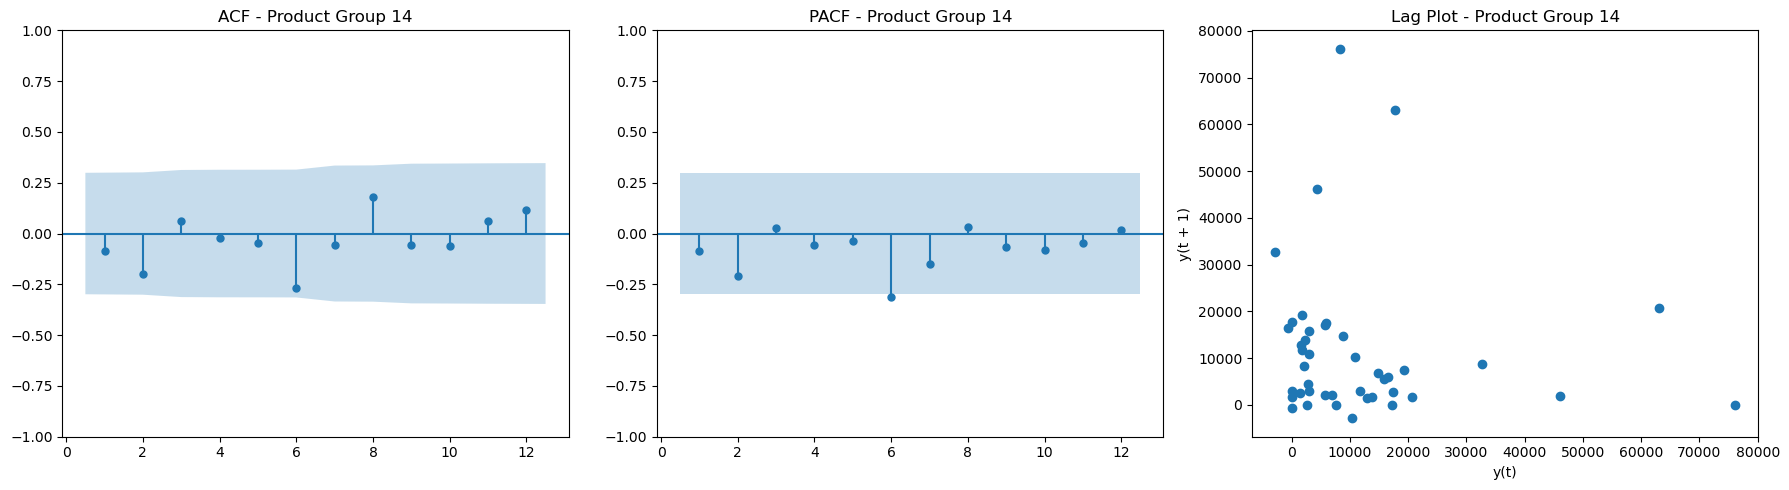

In [134]:
plot_acf_pacf(sales_agg14, product_group=14, max_lag=12)

## Feature selection

In [135]:
relevant_corr_14, selected_features_14 = plot_cross_correlation(
    sales_df=sales_agg14,
    market_df=df_market,
    product_group=14,
    max_lag=12,
    threshold=0.5
)


Selected Features for Product Group:
[]


In [136]:
filtered_info_market = info_market[info_market['Index Code'].isin(selected_features_14)]

filtered_info_market

Empty DataFrame
Columns: [Region, Index Name, Index Code]
Index: []

# Product Group 16

In [137]:
sales_agg16 = get_sales_by_product_group(df_sales, product_group=16)
sales_agg16.head()

DATE   Sales_EUR
0 2018-10-01   333196.87
1 2018-11-01  1377694.32
2 2018-12-01  4762524.66
3 2019-01-01   942957.19
4 2019-02-01   257765.04

In [138]:
shapiro_result16 = shapiro_wilk_test(sales_agg16['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.429564
p-value: 0.000000

❌ The p-value (0.000000) is less than 0.05.
   We reject the null hypothesis, meaning the data is not normally distributed.



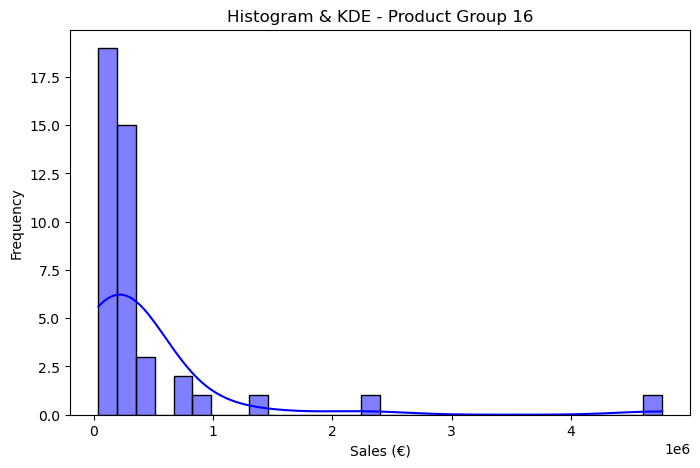

In [139]:
plot_distribution(sales_agg16['Sales_EUR'], product_group=16)

In [140]:
adf_result16 = adf_test(sales_agg16['Sales_EUR'], product_group=16)

Augmented Dickey-Fuller (ADF) Test - Product Group 16
ADF Statistic: -6.367204
p-value: 0.000000
Critical Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616

✅ The p-value (0.000000) is ≤ 0.05.
   We reject the null hypothesis, meaning the data is stationary.



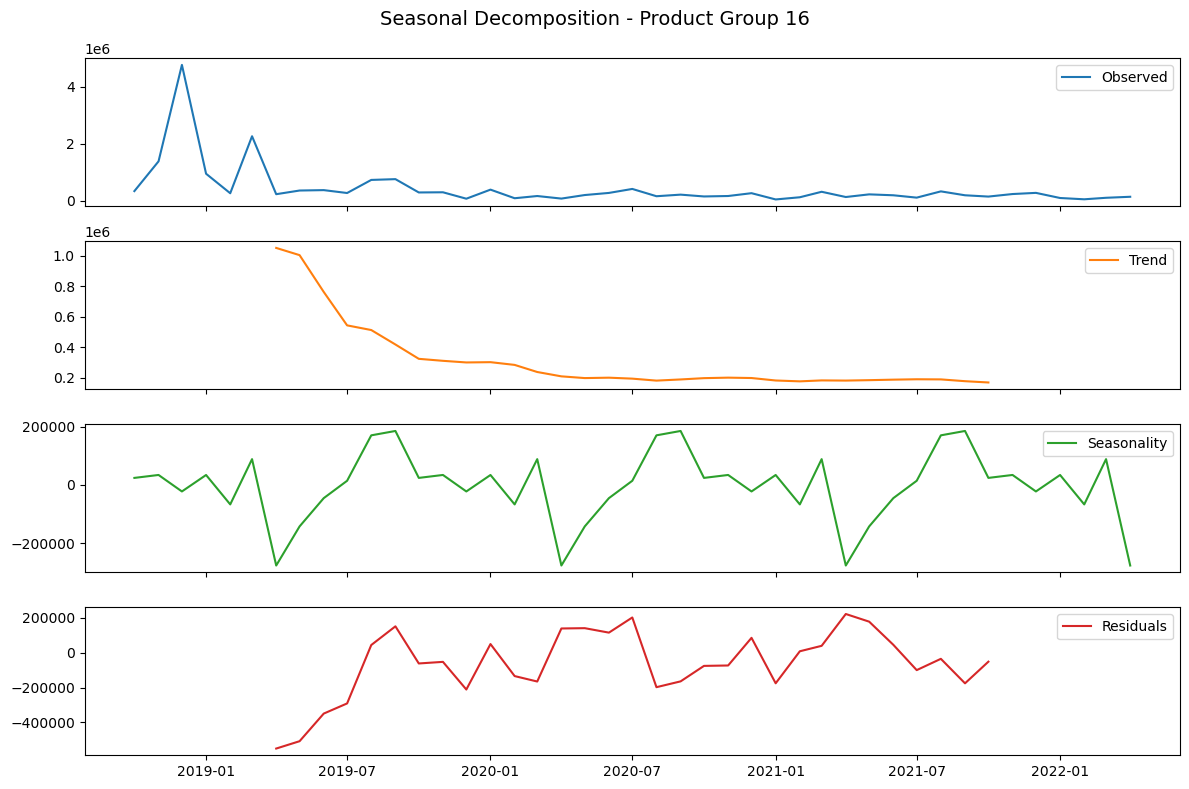

In [141]:
seasonal_decomposition(sales_agg16, product_group=16, date_column='DATE')

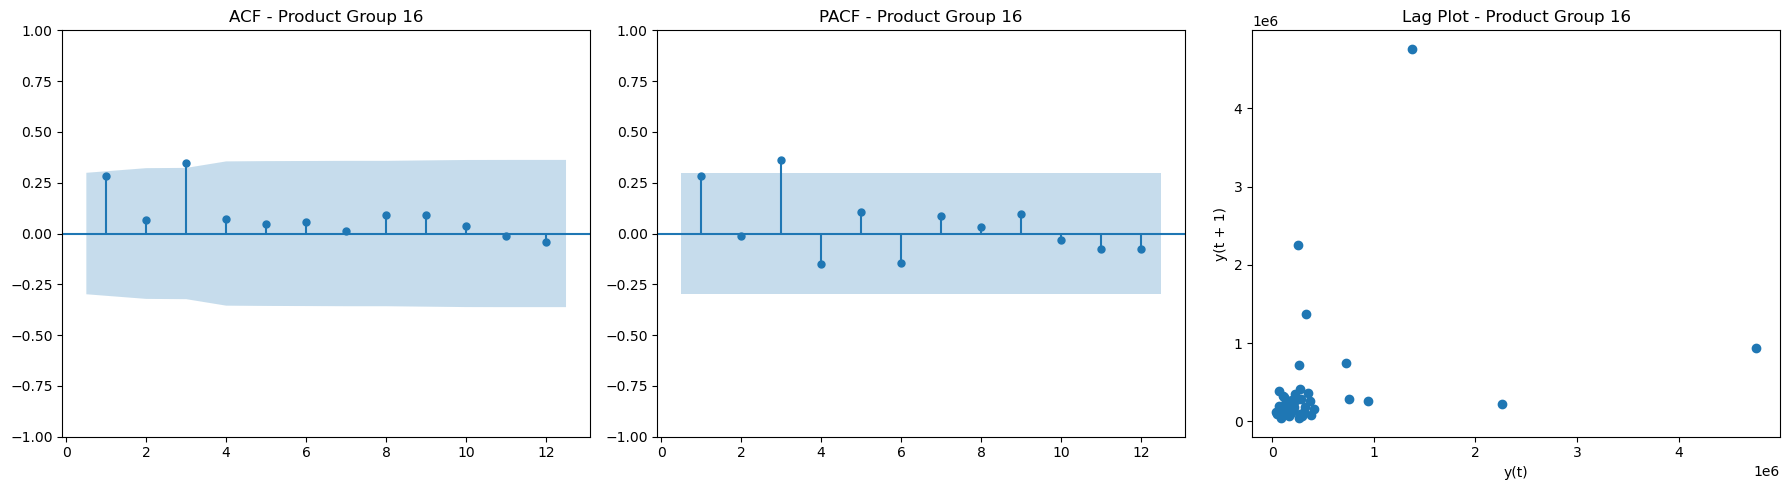

In [142]:
plot_acf_pacf(sales_agg16, product_group=16, max_lag=12)

## Feature selection

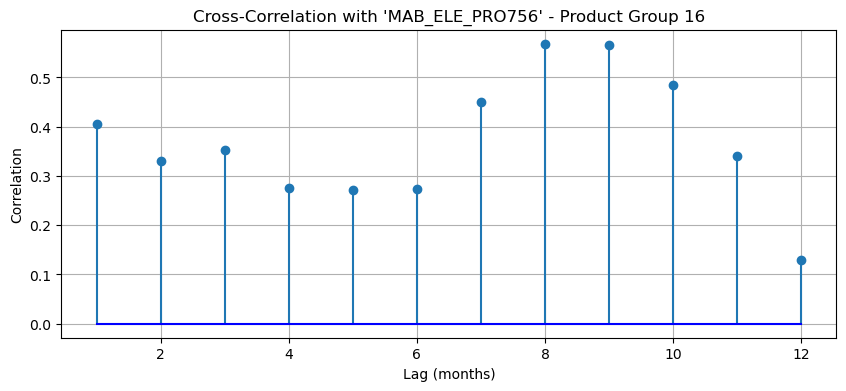

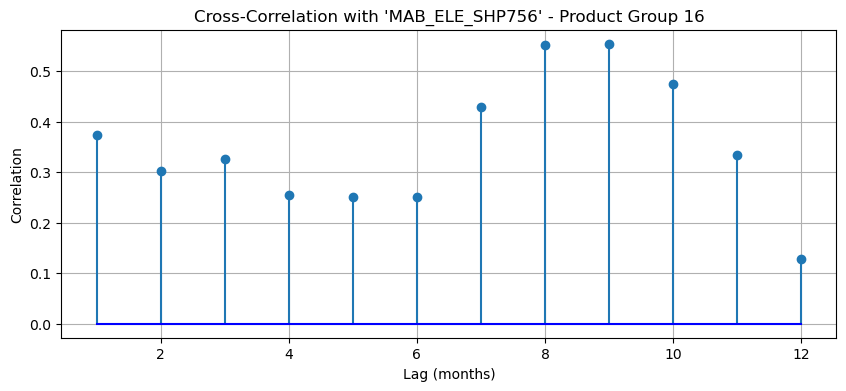

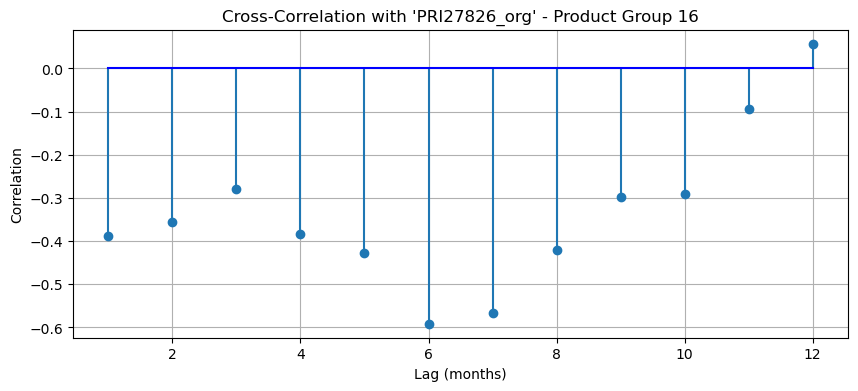

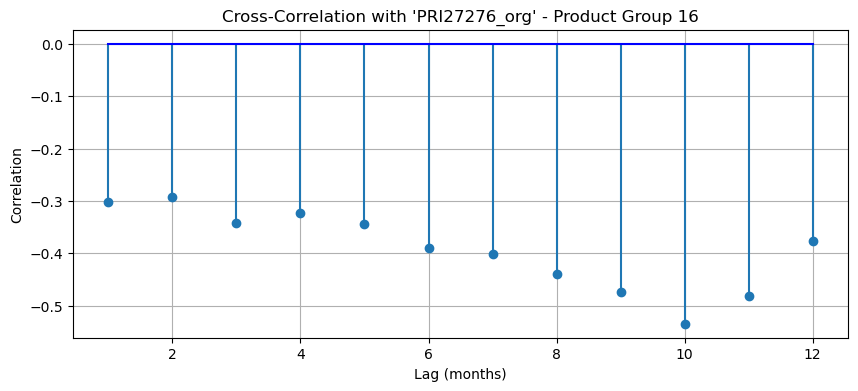

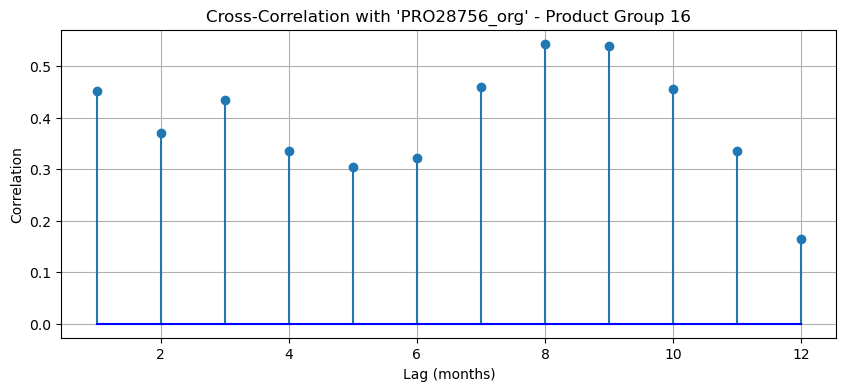

Selected Features for Product Group:
['MAB_ELE_PRO756', 'MAB_ELE_SHP756', 'PRI27826_org', 'PRI27276_org', 'PRO28756_org']


In [143]:
relevant_corr_16, selected_features_16 = plot_cross_correlation(
    sales_df=sales_agg16,
    market_df=df_market,
    product_group=16,
    max_lag=12,
    threshold=0.5
)

In [144]:
filtered_info_market = info_market[info_market['Index Code'].isin(selected_features_16)]

filtered_info_market

0           Region                                Index Name      Index Code
10     Switzerland  Production Index Machinery & Electricals  MAB_ELE_PRO756
11     Switzerland   Shipments Index Machinery & Electricals  MAB_ELE_SHP756
26  United Kingdom                      Electrical equipment    PRI27826_org
29         Germany                      Electrical equipment    PRI27276_org
33     Switzerland            Machinery and equipment n.e.c.    PRO28756_org

# Product Group 20

In [145]:
sales_agg20 = get_sales_by_product_group(df_sales, product_group=20)
sales_agg20.head()

DATE  Sales_EUR
0 2018-10-01    4563.14
1 2018-11-01    5798.14
2 2018-12-01     918.65
3 2019-01-01    2398.04
4 2019-02-01     620.66

In [146]:
shapiro_result20 = shapiro_wilk_test(sales_agg20['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.745145
p-value: 0.000000

❌ The p-value (0.000000) is less than 0.05.
   We reject the null hypothesis, meaning the data is not normally distributed.



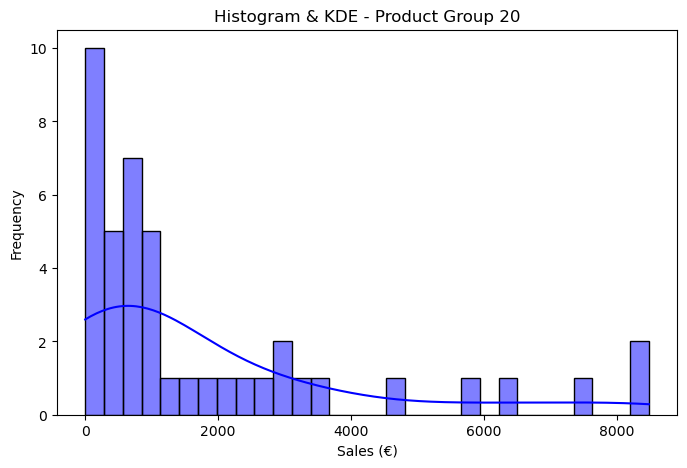

In [147]:
plot_distribution(sales_agg20['Sales_EUR'], product_group=20)

In [148]:
adf_result20 = adf_test(sales_agg20['Sales_EUR'], product_group=20)

Augmented Dickey-Fuller (ADF) Test - Product Group 20
ADF Statistic: -3.125179
p-value: 0.024745
Critical Values:
	1%: -3.601
	5%: -2.935
	10%: -2.606

✅ The p-value (0.024745) is ≤ 0.05.
   We reject the null hypothesis, meaning the data is stationary.



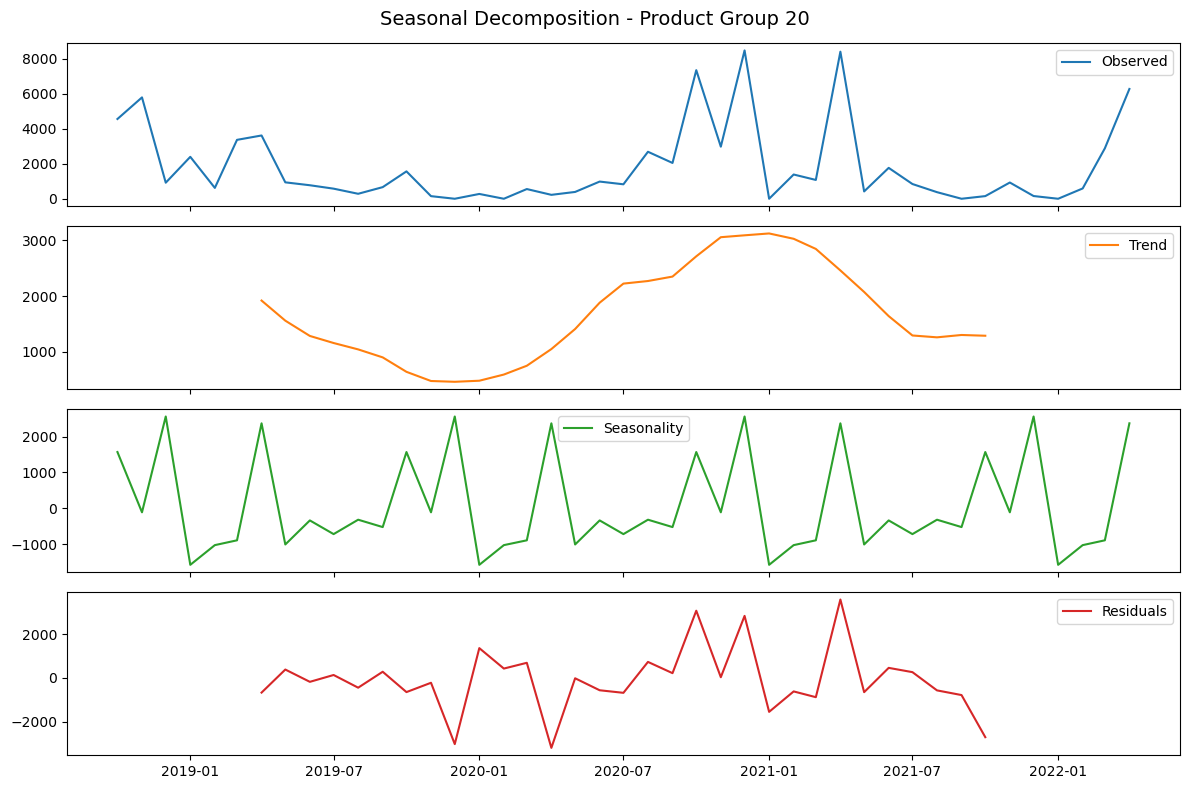

In [149]:
seasonal_decomposition(sales_agg20, product_group=20, date_column='DATE')

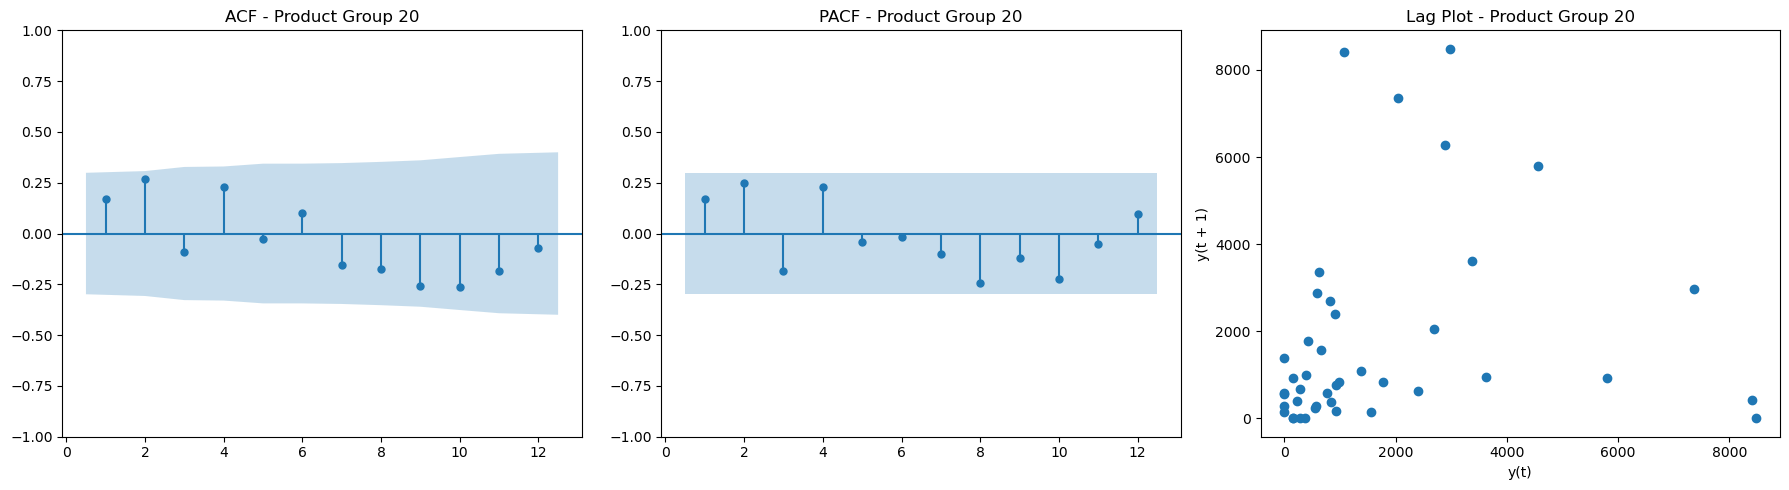

In [150]:
plot_acf_pacf(sales_agg20, product_group=20, max_lag=12)

## Feature selection

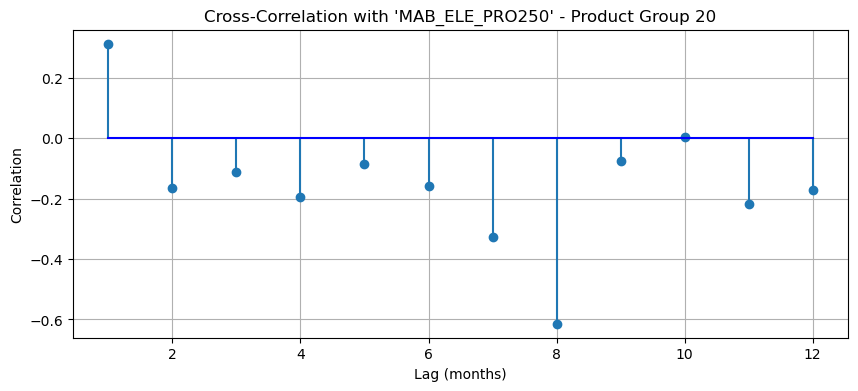

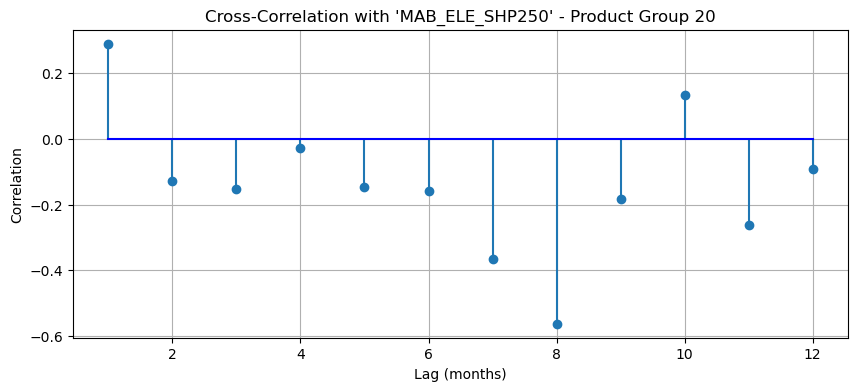

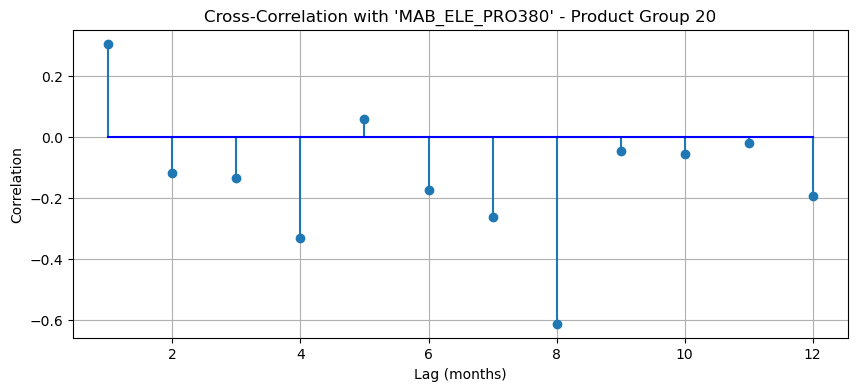

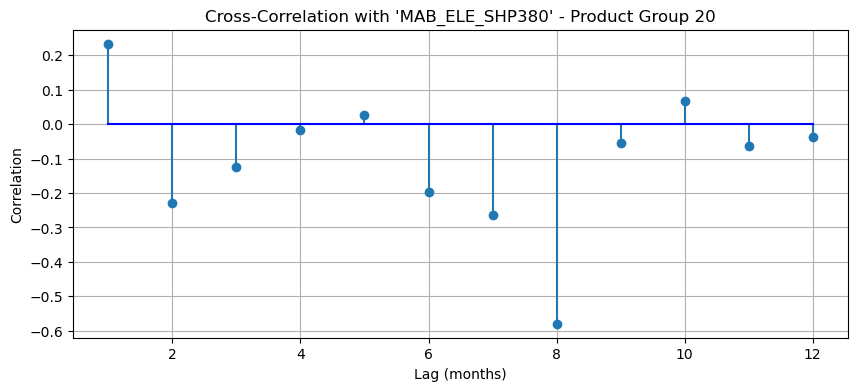

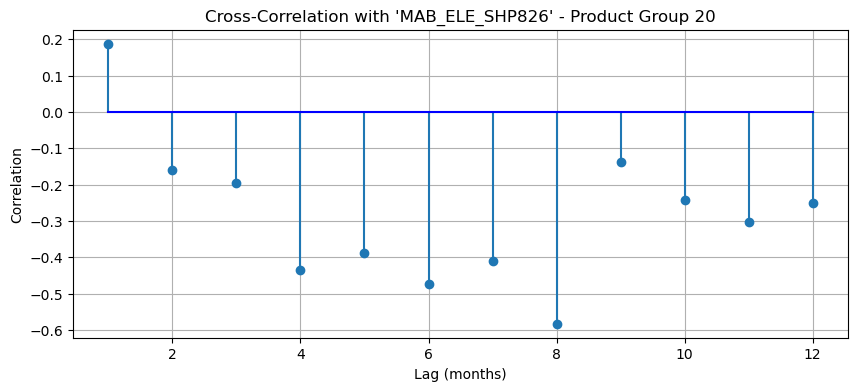

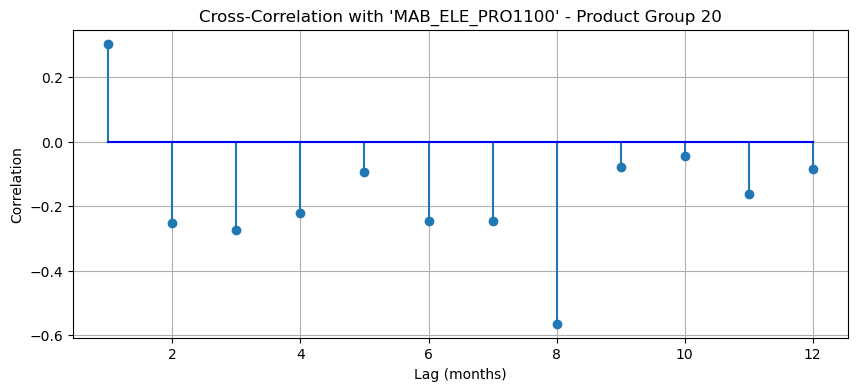

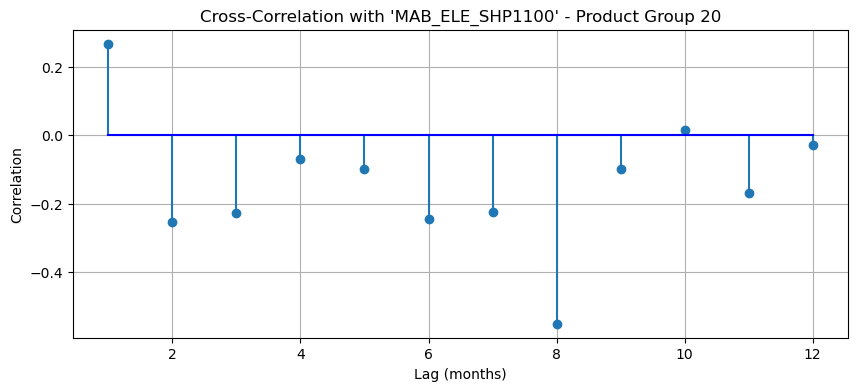

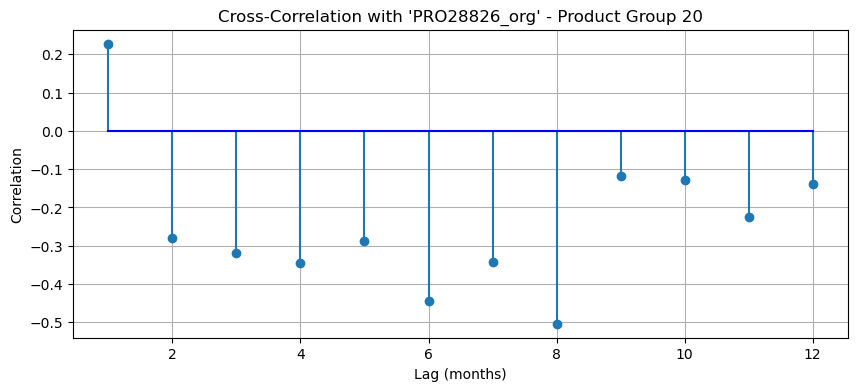

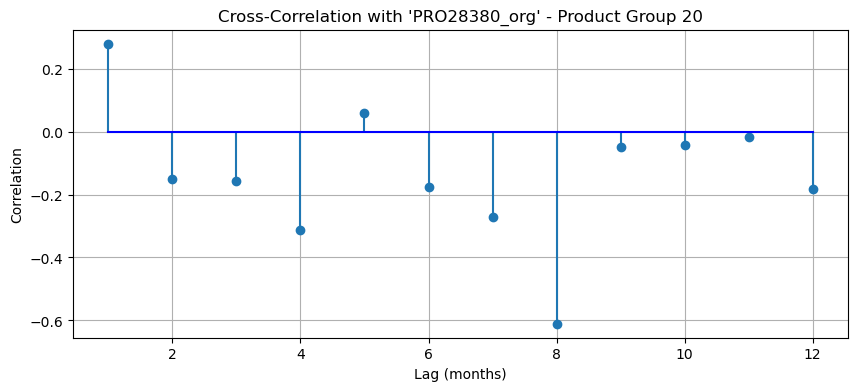

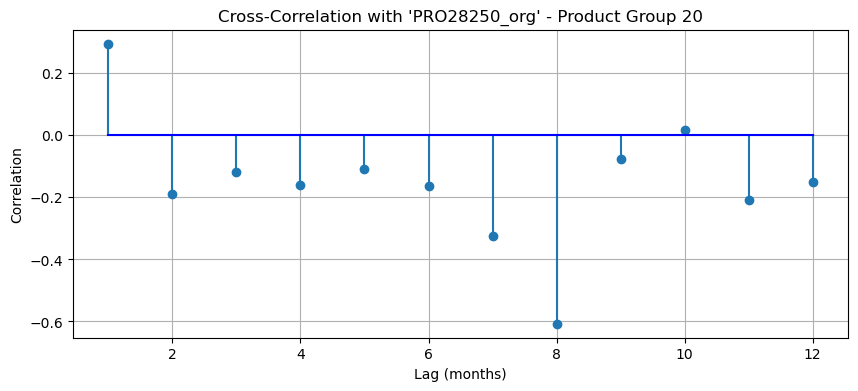

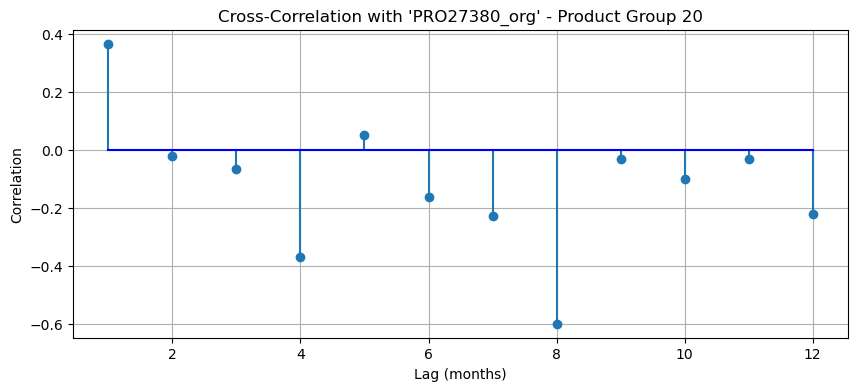

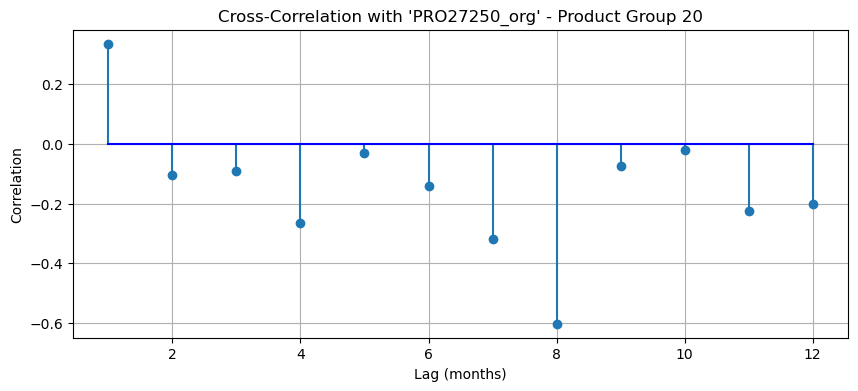

Selected Features for Product Group:
['MAB_ELE_PRO250', 'MAB_ELE_SHP250', 'MAB_ELE_PRO380', 'MAB_ELE_SHP380', 'MAB_ELE_SHP826', 'MAB_ELE_PRO1100', 'MAB_ELE_SHP1100', 'PRO28826_org', 'PRO28380_org', 'PRO28250_org', 'PRO27380_org', 'PRO27250_org']


In [151]:
relevant_corr_20, selected_features_20 = plot_cross_correlation(
    sales_df=sales_agg20,
    market_df=df_market,
    product_group=20,
    max_lag=12,
    threshold=0.5
)

In [152]:
filtered_info_market = info_market[info_market['Index Code'].isin(selected_features_20)]

filtered_info_market

0           Region                                Index Name       Index Code
2           France  Production Index Machinery & Electricals   MAB_ELE_PRO250
3           France   Shipments Index Machinery & Electricals   MAB_ELE_SHP250
6            Italy  Production Index Machinery & Electricals   MAB_ELE_PRO380
7            Italy   Shipments Index Machinery & Electricals   MAB_ELE_SHP380
13  United Kingdom   Shipments Index Machinery & Electricals   MAB_ELE_SHP826
16          Europe  Production Index Machinery & Electricals  MAB_ELE_PRO1100
17          Europe   Shipments Index Machinery & Electricals  MAB_ELE_SHP1100
34  United Kingdom            Machinery and equipment n.e.c.     PRO28826_org
35           Italy            Machinery and equipment n.e.c.     PRO28380_org
37          France            Machinery and equipment n.e.c.     PRO28250_org
43           Italy                      Electrical equipment     PRO27380_org
45          France                      Electrical equipment     PRO27250_org

# Product Group 36

In [153]:
sales_agg36 = get_sales_by_product_group(df_sales, product_group=36)
sales_agg36.head()

DATE  Sales_EUR
0 2018-10-01    6474.60
1 2018-11-01   21617.61
2 2018-12-01   13924.52
3 2019-01-01   15444.39
4 2019-02-01    8051.15

In [154]:
shapiro_result36 = shapiro_wilk_test(sales_agg36['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.433648
p-value: 0.000000

❌ The p-value (0.000000) is less than 0.05.
   We reject the null hypothesis, meaning the data is not normally distributed.



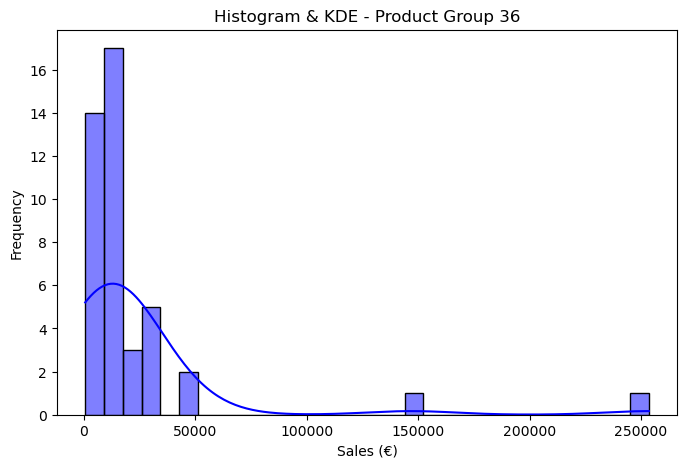

In [155]:
plot_distribution(sales_agg36['Sales_EUR'], product_group=36)

In [156]:
adf_result36 = adf_test(sales_agg36['Sales_EUR'], product_group=36)

Augmented Dickey-Fuller (ADF) Test - Product Group 36
ADF Statistic: -7.000027
p-value: 0.000000
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605

✅ The p-value (0.000000) is ≤ 0.05.
   We reject the null hypothesis, meaning the data is stationary.



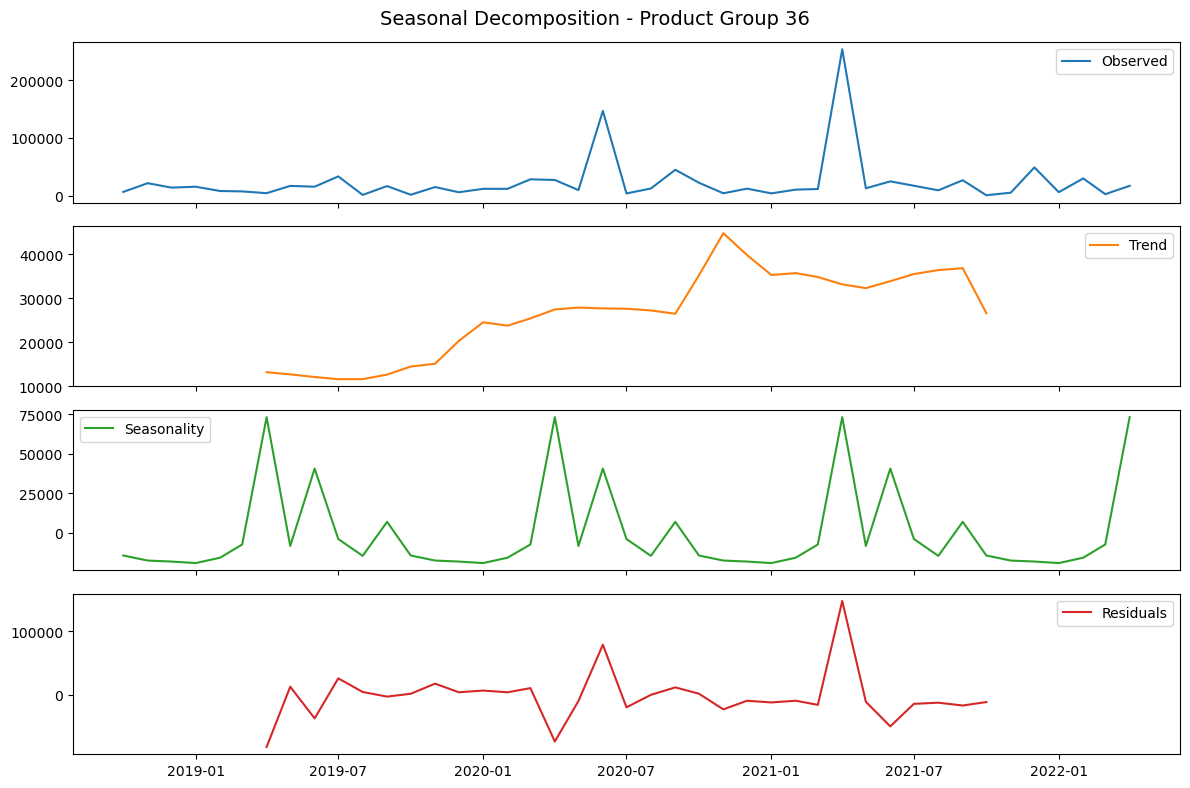

In [157]:
seasonal_decomposition(sales_agg36, product_group=36, date_column='DATE')

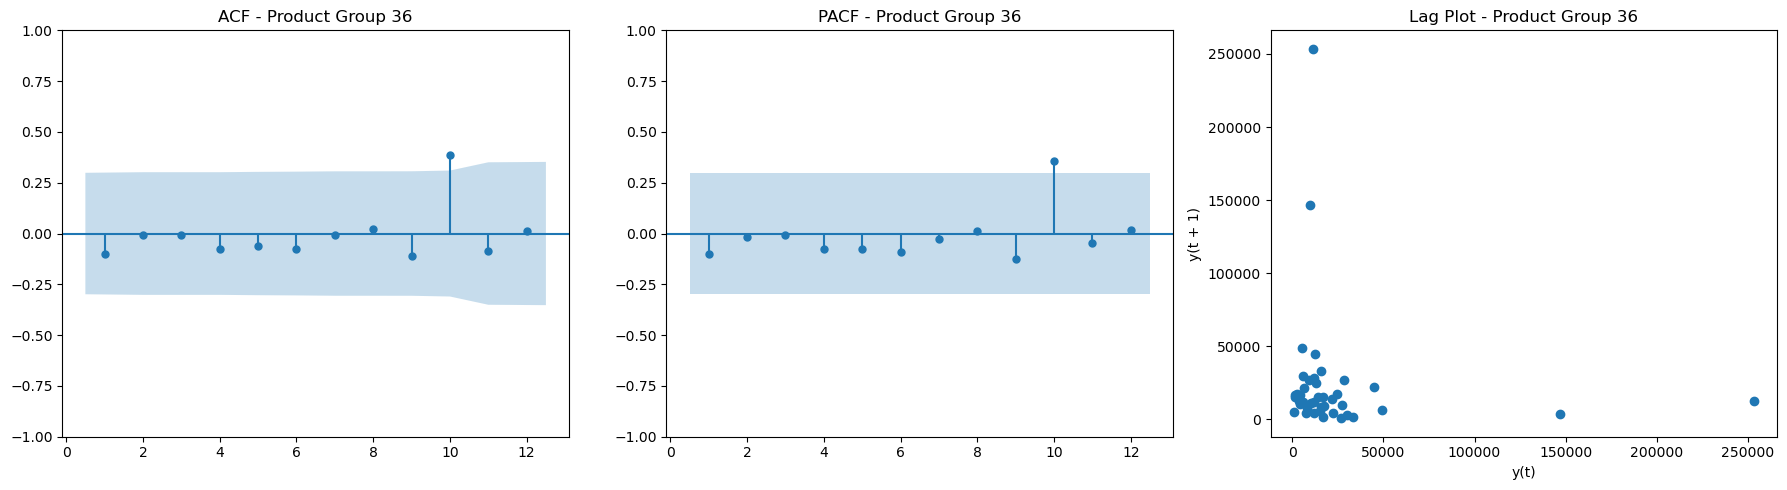

In [158]:
plot_acf_pacf(sales_agg36, product_group=36, max_lag=12)

## Feature selection

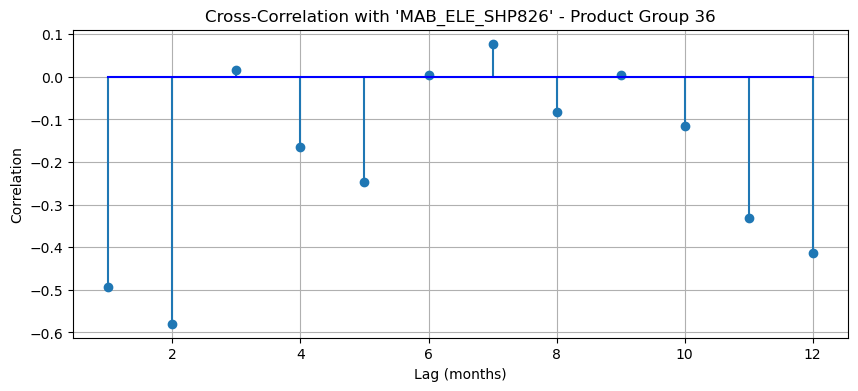

Selected Features for Product Group:
['MAB_ELE_SHP826']


In [159]:
relevant_corr_36, selected_features_36 = plot_cross_correlation(
    sales_df=sales_agg36,
    market_df=df_market,
    product_group=36,
    max_lag=12,
    threshold=0.5
)


In [160]:
filtered_info_market = info_market[info_market['Index Code'].isin(selected_features_36)]

filtered_info_market

0           Region                               Index Name      Index Code
13  United Kingdom  Shipments Index Machinery & Electricals  MAB_ELE_SHP826

# Export

In [163]:
selected_feature_goup = list(set(selected_features_1 + selected_features_3 + selected_features_4 + selected_features_5 + selected_features_6 + selected_features_8 + selected_features_9 + selected_features_11 + selected_features_12 + selected_features_13 + selected_features_14 + selected_features_16 + selected_features_20 + selected_features_36))
print(len(selected_feature_goup))

filtered_info_market = info_market[info_market['Index Code'].isin(selected_feature_goup)]

filtered_info_market

41


0           Region                                Index Name  \
0            China  Production Index Machinery & Electricals   
1            China   Shipments Index Machinery & Electricals   
2           France  Production Index Machinery & Electricals   
3           France   Shipments Index Machinery & Electricals   
4          Germany  Production Index Machinery & Electricals   
5          Germany   Shipments Index Machinery & Electricals   
6            Italy  Production Index Machinery & Electricals   
7            Italy   Shipments Index Machinery & Electricals   
8            Japan  Production Index Machinery & Electricals   
9            Japan   Shipments Index Machinery & Electricals   
10     Switzerland  Production Index Machinery & Electricals   
11     Switzerland   Shipments Index Machinery & Electricals   
12  United Kingdom  Production Index Machinery & Electricals   
13  United Kingdom   Shipments Index Machinery & Electricals   
14   United States  Production Index Machinery & Electricals   
15   United States   Shipments Index Machinery & Electricals   
16          Europe  Production Index Machinery & Electricals   
17          Europe   Shipments Index Machinery & Electricals   
18           World                      Price of Base Metals   
20           World               Price of Metals  & Minerals   
21           World                Price of Natural gas index   
23           World                           Price of Copper   
24   United States                                EUR in LCU   
25   United States                      Electrical equipment   
26  United Kingdom                      Electrical equipment   
27           Italy                      Electrical equipment   
28          France                      Electrical equipment   
29         Germany                      Electrical equipment   
30           China                      Electrical equipment   
31   United States            Machinery and equipment n.e.c.   
33     Switzerland            Machinery and equipment n.e.c.   
34  United Kingdom            Machinery and equipment n.e.c.   
35           Italy            Machinery and equipment n.e.c.   
36           Japan            Machinery and equipment n.e.c.   
37          France            Machinery and equipment n.e.c.   
38         Germany            Machinery and equipment n.e.c.   
39   United States                      Electrical equipment   
40           World                      Electrical equipment   
43           Italy                      Electrical equipment   
44           Japan                      Electrical equipment   
45          France                      Electrical equipment   

0            Index Code  
0        MAB_ELE_PRO156  
1        MAB_ELE_SHP156  
2        MAB_ELE_PRO250  
3        MAB_ELE_SHP250  
4        MAB_ELE_PRO276  
5        MAB_ELE_SHP276  
6        MAB_ELE_PRO380  
7        MAB_ELE_SHP380  
8        MAB_ELE_PRO392  
9        MAB_ELE_SHP392  
10       MAB_ELE_PRO756  
11       MAB_ELE_SHP756  
12       MAB_ELE_PRO826  
13       MAB_ELE_SHP826  
14       MAB_ELE_PRO840  
15       MAB_ELE_SHP840  
16      MAB_ELE_PRO1100  
17      MAB_ELE_SHP1100  
18  RohiBASEMET1000_org  
20   RohiMETMIN1000_org  
21   RohiNATGAS1000_org  
23    RohCOPPER1000_org  
24       WKLWEUR840_org  
25         PRI27840_org  
26         PRI27826_org  
27         PRI27380_org  
28         PRI27250_org  
29         PRI27276_org  
30         PRI27156_org  
31         PRO28840_org  
33         PRO28756_org  
34         PRO28826_org  
35         PRO28380_org  
36         PRO28392_org  
37         PRO28250_org  
38         PRO28276_org  
39         PRO27840_org  
40        PRO271000_org  
43         PRO27380_org  
44         PRO27392_org  
45         PRO27250_org

In [181]:
# Sales data for all product groups
sales_agg1.to_csv('../Data/sales_agg1.csv', index=False)
sales_agg3.to_csv('../Data/sales_agg3.csv', index=False)
sales_agg4.to_csv('../Data/sales_agg4.csv', index=False)
sales_agg5.to_csv('../Data/sales_agg5.csv', index=False)
sales_agg6.to_csv('../Data/sales_agg6.csv', index=False)
sales_agg8.to_csv('../Data/sales_agg8.csv', index=False)
sales_agg9.to_csv('../Data/sales_agg9.csv', index=False)
sales_agg11.to_csv('../Data/sales_agg11.csv', index=False)
sales_agg12.to_csv('../Data/sales_agg12.csv', index=False)
sales_agg13.to_csv('../Data/sales_agg13.csv', index=False)
sales_agg14.to_csv('../Data/sales_agg14.csv', index=False)
sales_agg16.to_csv('../Data/sales_agg16.csv', index=False)
sales_agg20.to_csv('../Data/sales_agg20.csv', index=False)
sales_agg36.to_csv('../Data/sales_agg36.csv', index=False)

# Market data
df_market.to_csv('../Data/df_market.csv', index=False)
info_market.to_csv('../Data/info_market.csv', index=False)
